In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import StratifiedKFold
import optuna
import plotly.express as px
from collections import Counter
from svae_model import SupervisedVAE

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fill_repeater_from_source(row, data):
    if row['Source'] == 'FRB20220912A':
        return 1
    else:
        return row['Repeater']

In [3]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)
frb_data['Repeater'] = frb_data.apply(fill_repeater_from_source, axis=1, data=frb_data)

frb_data['Repeater'].isna().sum()

np.int64(0)

In [4]:
labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 
    #'Scin_f'
]
base_features = [
    'Observing_band', 
    # 'GL', 'GB', 
    'SNR', 'Freq_high',
    'Freq_low', 'Freq_peak', 
    'Width'
    # 'Repeater',
    #'MJD'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [5]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = val_tensor.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [9]:
def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma, class_weight, classification_multiplier):
    reconstruction_loss_fn = nn.MSELoss(reduction='sum')
    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)
    classification_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # check this loss function
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_multiplier * classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss

In [10]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [11]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics

def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return f1, class_report, conf_matrix, all_preds, all_labels

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0})
print(original_data['Repeater'].isna().sum())

print(f"Number of NaN values in 'Repeater' column before processing: {original_data['Repeater'].isna().sum()}")
# Apply the function row-wise
original_data['Repeater'] = original_data.apply(fill_repeater_from_source, axis=1, data=original_data)

print(f"Number of NaN values in 'Repeater' column after processing: {original_data['Repeater'].isna().sum()}")

443
Number of NaN values in 'Repeater' column before processing: 443
Number of NaN values in 'Repeater' column after processing: 0


In [13]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [ ]:
i = 0
accuracy_max = 0
def objective(trial):
    global i, accuracy_max
    hidden_dim = trial.suggest_int('hidden_dim', 128, 2048)
    latent_dim = trial.suggest_int('latent_dim', 5, 40)
    beta = trial.suggest_float('beta', 0.1, 2.0)
    gamma = trial.suggest_float('gamma', 0.1, 2.0)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2)
    scheduler_patience = trial.suggest_int('scheduler_patience', 2, 7)
    class_weight = trial.suggest_float('class_weight', 0.05, 1)

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'ELU', 'SELU', 'GELU'])
    activation = get_activation_function(activation_name)
    classification_multiplier = trial.suggest_float('classification_multiplier', 5000, 15000)

    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)

    all_false_positives = []
    all_false_negatives = []
    all_true_positives = []
    all_true_negatives = []

    num_epochs = 100

    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
    full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)

    for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
        # print(f"\n=== Fold {fold + 1}/{n_folds} ===")
        
        train_data, val_data = frb_data_scaled[train_index], frb_data_scaled[val_index]
        train_labels, val_labels = labels.iloc[train_index], labels.iloc[val_index]
        
        train_tensor = torch.tensor(train_data, dtype=torch.float32)
        val_tensor = torch.tensor(val_data, dtype=torch.float32)
        train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
        val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
        
        train_dataset = TensorDataset(train_tensor, train_labels_tensor)
        val_dataset = TensorDataset(val_tensor, val_labels_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        best_model = SupervisedVAE(
            input_dim, 
            hidden_dim, 
            latent_dim, 
            dropout_rate, 
            activation
        ).to(device)
        
        optimizer = torch.optim.Adam(best_model.parameters(), lr=lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=scheduler_patience)
        
        # Train the model
        for epoch in range(1, num_epochs + 1):
            train_loss, _, _, _, train_accuracy = train_supervised(best_model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier)
            val_loss, _, _, _, val_accuracy = validate_supervised(best_model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier)
            scheduler.step(val_loss)
            
            # Early stopping
            if early_stopping([val_loss], stop_patience):
                print(f"Early stopping triggered at epoch {epoch}")
                break

        val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)
        
        # print(f"Validation Accuracy: {val_accuracy:.4f}")
        # print("Classification Report:\n", val_class_report)
        # print("Confusion Matrix:\n", val_conf_matrix)
        
        misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
        misclassified_indices = val_index[misclassified_non_repeaters]
        misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()
        
        false_positives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 1)], "Source"]
        false_negatives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 0)], "Source"]
        true_positives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 1)], "Source"]
        true_negatives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 0)], "Source"]
        
        # fold_false_positives = []
        for source in misclassified_sources:
            # fold_false_positives.append(source)
            if source in garcia_list or source in luo_list or source in zhu_ge_list:
                print(f"False positive in fold {fold + 1}: {source}")
                
        all_false_negatives.extend(false_negatives_fold)
        all_true_positives.extend(true_positives_fold)
        all_true_negatives.extend(true_negatives_fold)
        all_false_positives.extend(false_positives_fold)
        
        
    all_false_positives = pd.Series(all_false_positives)
    all_false_negatives = pd.Series(all_false_negatives)
    all_true_positives = pd.Series(all_true_positives)
    all_true_negatives = pd.Series(all_true_negatives)

    print("\n=== Summary ===")
    print(f"Total False Positives: {all_false_positives.nunique()}")
    print(f"Total False Negatives: {all_false_negatives.nunique()}")
    print(f"Total True Positives: {all_true_positives.nunique()}")
    print(f"Total True Negatives: {all_true_negatives.nunique()}")

    FP = all_false_positives.nunique()
    FN = all_false_negatives.nunique()
    TP = all_true_positives.nunique()
    TN = all_true_negatives.nunique()

    # Confusion matrix

    conf_mat_final = np.zeros((2, 2))
    conf_mat_final[0, 0] = TN
    conf_mat_final[0, 1] = FP
    conf_mat_final[1, 0] = FN
    conf_mat_final[1, 1] = TP

    print(conf_mat_final)

    precision = TP / (TP + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    recall = TP / (TP + FN)
    # f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print("\n=== Classification Metrics ===")
    # print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    if accuracy > accuracy_max:
        torch.save(best_model.state_dict(), f'optimized{i}.pth')
        accuracy_max = accuracy
    i+=1
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=350)

[I 2025-04-15 15:56:52,084] A new study created in memory with name: no-name-1a40b58c-ecb3-4366-b9e0-8a6c3252021e


False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190206A
False positive in fold 1: FRB20180928A
False positive in fold 1: FRB20190618A
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20180915B
False positive in fold 2: FRB20190106B
False positive in fold 2: FRB20190609A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180923A


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


=== Summary ===
Total False Positives: 125
Total False Negatives: 66
Total True Positives: 35
Total True Negatives: 622
[[622. 125.]
 [ 66.  35.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3465
Accuracy: 0.7748
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20180928A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20180915B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 16:07:18,483] Trial 1 finished with value: 0.8792899408284024 and parameters: {'hidden_dim': 165, 'latent_dim': 16, 'beta': 1.4077889478926817, 'gamma': 0.4410198891625907, 'dropout_rate': 0.4699686013921154, 'lr': 0.0062391327844270004, 'scheduler_patience': 7, 'class_weight': 0.6528305060934186, 'activation': 'ReLU', 'classification_multiplier': 11926.643357324789}. Best is trial 1 with value: 0.8792899408284024.



=== Summary ===
Total False Positives: 56
Total False Negatives: 46
Total True Positives: 51
Total True Negatives: 692
[[692.  56.]
 [ 46.  51.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5258
Accuracy: 0.8793
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 16:11:38,374] Trial 2 finished with value: 0.917550058892815 and parameters: {'hidden_dim': 681, 'latent_dim': 35, 'beta': 0.805883380748036, 'gamma': 0.8874990175403827, 'dropout_rate': 0.11026266439998614, 'lr': 0.0024925321358222905, 'scheduler_patience': 2, 'class_weight': 0.26056244286364744, 'activation': 'SELU', 'classification_multiplier': 6115.555005386323}. Best is trial 2 with value: 0.917550058892815.


False positive in fold 5: FRB20190423A

=== Summary ===
Total False Positives: 19
Total False Negatives: 51
Total True Positives: 51
Total True Negatives: 728
[[728.  19.]
 [ 51.  51.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5000
Accuracy: 0.9176
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20190221A


[I 2025-04-15 16:16:02,941] Trial 3 finished with value: 0.8836662749706228 and parameters: {'hidden_dim': 752, 'latent_dim': 27, 'beta': 0.4128900513727135, 'gamma': 1.8749881595714375, 'dropout_rate': 0.22462123082809837, 'lr': 0.005516590505453252, 'scheduler_patience': 6, 'class_weight': 0.27809074922869204, 'activation': 'SELU', 'classification_multiplier': 14963.311193500014}. Best is trial 2 with value: 0.917550058892815.


False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A

=== Summary ===
Total False Positives: 45
Total False Negatives: 54
Total True Positives: 50
Total True Negatives: 702
[[702.  45.]
 [ 54.  50.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4808
Accuracy: 0.8837
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-15 16:22:53,869] Trial 4 finished with value: 0.7701283547257877 and parameters: {'hidden_dim': 1724, 'latent_dim': 16, 'beta': 1.9502143292416676, 'gamma': 0.19967644082777436, 'dropout_rate': 0.17240029467039736, 'lr': 0.0055017788025767105, 'scheduler_patience': 4, 'class_weight': 0.852165367525476, 'activation': 'LeakyReLU', 'classification_multiplier': 10257.579694797621}. Best is trial 2 with value: 0.917550058892815.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20181030E
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190617A

=== Summary ===
Total False Positives: 145
Total False Negatives: 52
Total True Positives: 57
Total True Negatives: 603
[[603. 145.]
 [ 52.  57.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5229
Accuracy: 0.7701
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-15 16:27:19,104] Trial 5 finished with value: 0.918757467144564 and parameters: {'hidden_dim': 809, 'latent_dim': 20, 'beta': 0.23779496248345827, 'gamma': 1.5511453741032126, 'dropout_rate': 0.32079336010979076, 'lr': 0.0030116219027399344, 'scheduler_patience': 6, 'class_weight': 0.5307957866313131, 'activation': 'GELU', 'classification_multiplier': 10192.523898426509}. Best is trial 5 with value: 0.918757467144564.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 29
Total True Positives: 60
Total True Negatives: 709
[[709.  39.]
 [ 29.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6742
Accuracy: 0.9188


[I 2025-04-15 16:31:05,922] Trial 6 finished with value: 0.919431279620853 and parameters: {'hidden_dim': 181, 'latent_dim': 36, 'beta': 1.2037029345870751, 'gamma': 1.1527562252376853, 'dropout_rate': 0.45834973257283684, 'lr': 0.009003752463991118, 'scheduler_patience': 3, 'class_weight': 0.13822289443464977, 'activation': 'ReLU', 'classification_multiplier': 13628.883905109706}. Best is trial 6 with value: 0.919431279620853.



=== Summary ===
Total False Positives: 11
Total False Negatives: 57
Total True Positives: 40
Total True Negatives: 736
[[736.  11.]
 [ 57.  40.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4124
Accuracy: 0.9194


[I 2025-04-15 16:39:31,040] Trial 7 finished with value: 0.9015421115065243 and parameters: {'hidden_dim': 2025, 'latent_dim': 39, 'beta': 1.2633444480866536, 'gamma': 0.2416685455762041, 'dropout_rate': 0.13222913886567908, 'lr': 0.00486099636627797, 'scheduler_patience': 3, 'class_weight': 0.055991025846155465, 'activation': 'ReLU', 'classification_multiplier': 14890.159240915587}. Best is trial 6 with value: 0.919431279620853.



=== Summary ===
Total False Positives: 17
Total False Negatives: 66
Total True Positives: 30
Total True Negatives: 730
[[730.  17.]
 [ 66.  30.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3125
Accuracy: 0.9015
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 16:44:47,539] Trial 8 finished with value: 0.9057714958775029 and parameters: {'hidden_dim': 1183, 'latent_dim': 26, 'beta': 0.722632371816335, 'gamma': 0.11934772256886864, 'dropout_rate': 0.37153058752585966, 'lr': 0.0028830310969943274, 'scheduler_patience': 7, 'class_weight': 0.613861164796047, 'activation': 'ELU', 'classification_multiplier': 12301.732046262852}. Best is trial 6 with value: 0.919431279620853.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 36
Total False Negatives: 44
Total True Positives: 57
Total True Negatives: 712
[[712.  36.]
 [ 44.  57.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5644
Accuracy: 0.9058
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20180928A
False positive in fold 1: FRB20190618A
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20180915B
False positive in fold 2: FRB20190609A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181220A
False positive in fold 3: FRB20181125A
False positive in fold 3: FRB20190329A
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 3: FRB20190617B
False positive in fold 4: FRB20181231B


[I 2025-04-15 16:52:52,020] Trial 9 finished with value: 0.6576470588235294 and parameters: {'hidden_dim': 1946, 'latent_dim': 38, 'beta': 1.5558753882325869, 'gamma': 1.8131053541129758, 'dropout_rate': 0.4643535577047241, 'lr': 0.008807514316952076, 'scheduler_patience': 7, 'class_weight': 0.48071823309992484, 'activation': 'GELU', 'classification_multiplier': 6815.970163880409}. Best is trial 6 with value: 0.919431279620853.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20181030E
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190617A

=== Summary ===
Total False Positives: 234
Total False Negatives: 57
Total True Positives: 46
Total True Negatives: 513
[[513. 234.]
 [ 57.  46.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4466
Accuracy: 0.6576


[I 2025-04-15 16:56:38,531] Trial 10 finished with value: 0.8989298454221165 and parameters: {'hidden_dim': 239, 'latent_dim': 7, 'beta': 0.9822540773809165, 'gamma': 1.1701308279457348, 'dropout_rate': 0.36636816035168274, 'lr': 0.00013602871402864942, 'scheduler_patience': 2, 'class_weight': 0.10323951548675087, 'activation': 'ReLU', 'classification_multiplier': 8763.869057689055}. Best is trial 6 with value: 0.919431279620853.



=== Summary ===
Total False Positives: 25
Total False Negatives: 60
Total True Positives: 34
Total True Negatives: 722
[[722.  25.]
 [ 60.  34.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3617
Accuracy: 0.8989
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20180915B
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20190419A


[I 2025-04-15 17:00:39,264] Trial 11 finished with value: 0.8850710900473934 and parameters: {'hidden_dim': 594, 'latent_dim': 19, 'beta': 0.12381318157282875, 'gamma': 1.4337131619619718, 'dropout_rate': 0.3777582817414669, 'lr': 0.007966934831134469, 'scheduler_patience': 4, 'class_weight': 0.7712538650402869, 'activation': 'GELU', 'classification_multiplier': 9176.566261367954}. Best is trial 6 with value: 0.919431279620853.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 63
Total False Negatives: 34
Total True Positives: 62
Total True Negatives: 685
[[685.  63.]
 [ 34.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6458
Accuracy: 0.8851
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E


[I 2025-04-15 17:05:30,465] Trial 12 finished with value: 0.9240806642941874 and parameters: {'hidden_dim': 1073, 'latent_dim': 9, 'beta': 1.742800645891469, 'gamma': 1.4625449108465556, 'dropout_rate': 0.3036014422552689, 'lr': 0.00288537718393929, 'scheduler_patience': 5, 'class_weight': 0.44715797616505437, 'activation': 'GELU', 'classification_multiplier': 13458.47824395372}. Best is trial 12 with value: 0.9240806642941874.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 32
Total True Positives: 63
Total True Negatives: 716
[[716.  32.]
 [ 32.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6632
Accuracy: 0.9241
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 17:10:42,911] Trial 13 finished with value: 0.9230769230769231 and parameters: {'hidden_dim': 1189, 'latent_dim': 5, 'beta': 1.8070828140740105, 'gamma': 0.9741370614820566, 'dropout_rate': 0.43170523850117615, 'lr': 0.0010370219565065347, 'scheduler_patience': 3, 'class_weight': 0.18614426487999175, 'activation': 'LeakyReLU', 'classification_multiplier': 13400.886012407389}. Best is trial 12 with value: 0.9240806642941874.



=== Summary ===
Total False Positives: 13
Total False Negatives: 52
Total True Positives: 46
Total True Negatives: 734
[[734.  13.]
 [ 52.  46.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4694
Accuracy: 0.9231
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 17:15:58,224] Trial 14 finished with value: 0.930011862396204 and parameters: {'hidden_dim': 1227, 'latent_dim': 5, 'beta': 1.9753809673107943, 'gamma': 0.7601718633717457, 'dropout_rate': 0.2867280130232871, 'lr': 0.0003269605866414978, 'scheduler_patience': 5, 'class_weight': 0.39765046462858444, 'activation': 'LeakyReLU', 'classification_multiplier': 13225.167297523833}. Best is trial 14 with value: 0.930011862396204.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 36
Total True Positives: 59
Total True Negatives: 725
[[725.  23.]
 [ 36.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6211
Accuracy: 0.9300
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 17:21:43,652] Trial 15 finished with value: 0.9251781472684085 and parameters: {'hidden_dim': 1413, 'latent_dim': 10, 'beta': 1.7005998321854192, 'gamma': 0.6607752677316148, 'dropout_rate': 0.2834615608420484, 'lr': 0.0016275740251603648, 'scheduler_patience': 5, 'class_weight': 0.4238181676416429, 'activation': 'LeakyReLU', 'classification_multiplier': 13646.011163609273}. Best is trial 14 with value: 0.930011862396204.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 33
Total False Negatives: 30
Total True Positives: 64
Total True Negatives: 715
[[715.  33.]
 [ 30.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6809
Accuracy: 0.9252
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-15 17:27:31,324] Trial 16 finished with value: 0.930952380952381 and parameters: {'hidden_dim': 1443, 'latent_dim': 11, 'beta': 1.9761540400491528, 'gamma': 0.7222518984589471, 'dropout_rate': 0.23650455838132753, 'lr': 0.0015861577628215543, 'scheduler_patience': 6, 'class_weight': 0.3625674870293455, 'activation': 'LeakyReLU', 'classification_multiplier': 11076.785980583954}. Best is trial 16 with value: 0.930952380952381.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 26
Total True Positives: 66
Total True Negatives: 716
[[716.  32.]
 [ 26.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7174
Accuracy: 0.9310
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 17:33:34,710] Trial 17 finished with value: 0.9337278106508876 and parameters: {'hidden_dim': 1500, 'latent_dim': 12, 'beta': 1.9787926759211392, 'gamma': 0.6636492725390266, 'dropout_rate': 0.19503425742070646, 'lr': 0.0002701779519092349, 'scheduler_patience': 6, 'class_weight': 0.3299679239118334, 'activation': 'LeakyReLU', 'classification_multiplier': 11144.256853949331}. Best is trial 17 with value: 0.9337278106508876.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 37
Total True Positives: 60
Total True Negatives: 729
[[729.  19.]
 [ 37.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6186
Accuracy: 0.9337
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-15 17:39:44,100] Trial 18 finished with value: 0.9342105263157895 and parameters: {'hidden_dim': 1527, 'latent_dim': 13, 'beta': 1.5228731123468693, 'gamma': 0.5844219718533628, 'dropout_rate': 0.19572689646111344, 'lr': 0.0014331274746939237, 'scheduler_patience': 6, 'class_weight': 0.2893581055059872, 'activation': 'LeakyReLU', 'classification_multiplier': 11035.073142272639}. Best is trial 18 with value: 0.9342105263157895.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 23
Total True Positives: 65
Total True Negatives: 716
[[716.  32.]
 [ 23.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7386
Accuracy: 0.9342
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20180928A
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-15 17:46:32,207] Trial 19 finished with value: 0.8362369337979094 and parameters: {'hidden_dim': 1758, 'latent_dim': 13, 'beta': 1.458060704986393, 'gamma': 0.6061790388248258, 'dropout_rate': 0.16783142680016494, 'lr': 0.004404851438958041, 'scheduler_patience': 6, 'class_weight': 0.2186323936200772, 'activation': 'LeakyReLU', 'classification_multiplier': 8187.737014162015}. Best is trial 18 with value: 0.9342105263157895.



=== Summary ===
Total False Positives: 88
Total False Negatives: 53
Total True Positives: 61
Total True Negatives: 659
[[659.  88.]
 [ 53.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5351
Accuracy: 0.8362
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190601C


[I 2025-04-15 17:52:33,647] Trial 20 finished with value: 0.9106280193236715 and parameters: {'hidden_dim': 1492, 'latent_dim': 14, 'beta': 1.6287995120532863, 'gamma': 0.4842707977221962, 'dropout_rate': 0.18222801894984703, 'lr': 0.0012628998178755633, 'scheduler_patience': 6, 'class_weight': 0.9792199677451218, 'activation': 'LeakyReLU', 'classification_multiplier': 7637.1006201101}. Best is trial 18 with value: 0.9342105263157895.


False positive in fold 5: FRB20190423A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 61
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 687
[[687.  61.]
 [ 13.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8375
Accuracy: 0.9106
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-15 17:58:44,006] Trial 21 finished with value: 0.8857142857142857 and parameters: {'hidden_dim': 1513, 'latent_dim': 11, 'beta': 1.9966405162297005, 'gamma': 0.7575815115664029, 'dropout_rate': 0.22215205993874895, 'lr': 0.0020016885593193484, 'scheduler_patience': 6, 'class_weight': 0.30507093515842343, 'activation': 'LeakyReLU', 'classification_multiplier': 10945.86702377892}. Best is trial 18 with value: 0.9342105263157895.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 70
Total False Negatives: 26
Total True Positives: 66
Total True Negatives: 678
[[678.  70.]
 [ 26.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7174
Accuracy: 0.8857
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20190221A


[I 2025-04-15 18:04:28,980] Trial 22 finished with value: 0.8362573099415205 and parameters: {'hidden_dim': 1391, 'latent_dim': 22, 'beta': 1.8197638267731517, 'gamma': 0.5258084803995868, 'dropout_rate': 0.25004851768783054, 'lr': 0.003842209647728809, 'scheduler_patience': 7, 'class_weight': 0.5528246247142402, 'activation': 'LeakyReLU', 'classification_multiplier': 11074.380927414995}. Best is trial 18 with value: 0.9342105263157895.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 97
Total False Negatives: 43
Total True Positives: 64
Total True Negatives: 651
[[651.  97.]
 [ 43.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5981
Accuracy: 0.8363
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-15 18:09:09,257] Trial 23 finished with value: 0.9395734597156398 and parameters: {'hidden_dim': 951, 'latent_dim': 16, 'beta': 1.3483931504218523, 'gamma': 0.8566659685507542, 'dropout_rate': 0.20515171364337043, 'lr': 0.000943594496637684, 'scheduler_patience': 6, 'class_weight': 0.3429846613846082, 'activation': 'LeakyReLU', 'classification_multiplier': 11123.002799510037}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 18
Total False Negatives: 33
Total True Positives: 63
Total True Negatives: 730
[[730.  18.]
 [ 33.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6562
Accuracy: 0.9396
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-15 18:13:54,846] Trial 24 finished with value: 0.9372781065088758 and parameters: {'hidden_dim': 1006, 'latent_dim': 16, 'beta': 1.218247714126142, 'gamma': 0.872399252436128, 'dropout_rate': 0.19629680171568925, 'lr': 0.0007744892038206268, 'scheduler_patience': 5, 'class_weight': 0.3136347904596431, 'activation': 'LeakyReLU', 'classification_multiplier': 9526.641193301199}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 16
Total False Negatives: 37
Total True Positives: 61
Total True Negatives: 731
[[731.  16.]
 [ 37.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6224
Accuracy: 0.9373
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 18:18:38,177] Trial 25 finished with value: 0.927144535840188 and parameters: {'hidden_dim': 992, 'latent_dim': 17, 'beta': 1.1016064545919289, 'gamma': 0.910024166184323, 'dropout_rate': 0.1424482037644471, 'lr': 0.0037976719086589995, 'scheduler_patience': 4, 'class_weight': 0.22323512554085134, 'activation': 'ELU', 'classification_multiplier': 9582.985476029598}. Best is trial 23 with value: 0.9395734597156398.



=== Summary ===
Total False Positives: 14
Total False Negatives: 48
Total True Positives: 55
Total True Negatives: 734
[[734.  14.]
 [ 48.  55.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5340
Accuracy: 0.9271
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 18:22:35,815] Trial 26 finished with value: 0.9313609467455621 and parameters: {'hidden_dim': 478, 'latent_dim': 24, 'beta': 1.373239553780456, 'gamma': 1.1350634464655407, 'dropout_rate': 0.2073739673634415, 'lr': 0.000984248939858534, 'scheduler_patience': 5, 'class_weight': 0.16080122798717528, 'activation': 'LeakyReLU', 'classification_multiplier': 10066.652319216819}. Best is trial 23 with value: 0.9395734597156398.



=== Summary ===
Total False Positives: 15
Total False Negatives: 43
Total True Positives: 55
Total True Negatives: 732
[[732.  15.]
 [ 43.  55.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5612
Accuracy: 0.9314
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 18:27:06,437] Trial 27 finished with value: 0.9268867924528302 and parameters: {'hidden_dim': 881, 'latent_dim': 19, 'beta': 0.937465573270416, 'gamma': 1.071704695038561, 'dropout_rate': 0.15111619788584055, 'lr': 0.0021130125546600566, 'scheduler_patience': 5, 'class_weight': 0.4645826874213017, 'activation': 'SELU', 'classification_multiplier': 8166.108450104436}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 39
Total True Positives: 61
Total True Negatives: 725
[[725.  23.]
 [ 39.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6100
Accuracy: 0.9269
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 18:31:47,699] Trial 28 finished with value: 0.936094674556213 and parameters: {'hidden_dim': 966, 'latent_dim': 22, 'beta': 1.2149012157749577, 'gamma': 1.273751506686183, 'dropout_rate': 0.2694692057430262, 'lr': 0.0006640972397925655, 'scheduler_patience': 7, 'class_weight': 0.29745974797979596, 'activation': 'LeakyReLU', 'classification_multiplier': 12608.139624835127}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 15
Total False Negatives: 39
Total True Positives: 59
Total True Negatives: 732
[[732.  15.]
 [ 39.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6020
Accuracy: 0.9361
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 18:36:24,470] Trial 29 finished with value: 0.9165687426556992 and parameters: {'hidden_dim': 928, 'latent_dim': 30, 'beta': 1.2661038816859926, 'gamma': 1.3143088881722444, 'dropout_rate': 0.2616042838896365, 'lr': 0.0007290659875918324, 'scheduler_patience': 7, 'class_weight': 0.360610627567702, 'activation': 'ELU', 'classification_multiplier': 12256.686330426937}. Best is trial 23 with value: 0.9395734597156398.



=== Summary ===
Total False Positives: 26
Total False Negatives: 45
Total True Positives: 58
Total True Negatives: 722
[[722.  26.]
 [ 45.  58.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5631
Accuracy: 0.9166
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 18:40:22,249] Trial 30 finished with value: 0.9212410501193318 and parameters: {'hidden_dim': 409, 'latent_dim': 30, 'beta': 0.5409581403457058, 'gamma': 1.624447942990601, 'dropout_rate': 0.3369191506651089, 'lr': 0.0024297826541915153, 'scheduler_patience': 7, 'class_weight': 0.6070369511169096, 'activation': 'LeakyReLU', 'classification_multiplier': 11718.281948112179}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 40
Total False Negatives: 26
Total True Positives: 64
Total True Negatives: 708
[[708.  40.]
 [ 26.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7111
Accuracy: 0.9212
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 4: FRB20181218C


[I 2025-04-15 18:45:16,094] Trial 31 finished with value: 0.9268004722550177 and parameters: {'hidden_dim': 1051, 'latent_dim': 22, 'beta': 1.0868796411506625, 'gamma': 1.266420504013873, 'dropout_rate': 0.27323995305652415, 'lr': 0.0007392492030378271, 'scheduler_patience': 6, 'class_weight': 0.2764655937541117, 'activation': 'LeakyReLU', 'classification_multiplier': 12882.593415748828}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 39
Total True Positives: 60
Total True Negatives: 725
[[725.  23.]
 [ 39.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6061
Accuracy: 0.9268
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-15 18:50:42,804] Trial 32 finished with value: 0.9189511323003575 and parameters: {'hidden_dim': 1294, 'latent_dim': 17, 'beta': 1.4819387650196436, 'gamma': 0.8341346550457779, 'dropout_rate': 0.20383597634121206, 'lr': 0.001686560660134946, 'scheduler_patience': 5, 'class_weight': 0.345234493495254, 'activation': 'LeakyReLU', 'classification_multiplier': 11706.69233892199}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 41
Total False Negatives: 27
Total True Positives: 65
Total True Negatives: 706
[[706.  41.]
 [ 27.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7065
Accuracy: 0.9190
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-15 18:55:17,495] Trial 33 finished with value: 0.9247058823529412 and parameters: {'hidden_dim': 890, 'latent_dim': 15, 'beta': 1.3503657080921019, 'gamma': 0.3681775570229633, 'dropout_rate': 0.10017048821789051, 'lr': 0.0035670133773547503, 'scheduler_patience': 7, 'class_weight': 0.23603716961050358, 'activation': 'LeakyReLU', 'classification_multiplier': 5094.147078338913}. Best is trial 23 with value: 0.9395734597156398.



=== Summary ===
Total False Positives: 23
Total False Negatives: 41
Total True Positives: 61
Total True Negatives: 725
[[725.  23.]
 [ 41.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5980
Accuracy: 0.9247
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20181013E


[I 2025-04-15 18:59:31,446] Trial 34 finished with value: 0.8625146886016452 and parameters: {'hidden_dim': 727, 'latent_dim': 20, 'beta': 1.160743087090939, 'gamma': 0.9809729870160238, 'dropout_rate': 0.23468252893307687, 'lr': 0.00668711486083322, 'scheduler_patience': 6, 'class_weight': 0.37945089321640246, 'activation': 'SELU', 'classification_multiplier': 10625.44641089875}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 74
Total False Negatives: 43
Total True Positives: 60
Total True Negatives: 674
[[674.  74.]
 [ 43.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5825
Accuracy: 0.8625
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-15 19:03:34,333] Trial 35 finished with value: 0.9322235434007135 and parameters: {'hidden_dim': 639, 'latent_dim': 14, 'beta': 0.9606766088253929, 'gamma': 0.8466839332130743, 'dropout_rate': 0.21114289777303194, 'lr': 0.00124478096777705, 'scheduler_patience': 7, 'class_weight': 0.29491827410025573, 'activation': 'LeakyReLU', 'classification_multiplier': 9508.718006643854}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 27
Total True Positives: 66
Total True Negatives: 718
[[718.  30.]
 [ 27.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7097
Accuracy: 0.9322
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E


[I 2025-04-15 19:09:51,907] Trial 36 finished with value: 0.9203747072599532 and parameters: {'hidden_dim': 1622, 'latent_dim': 18, 'beta': 1.5445698855930543, 'gamma': 0.5585121740718029, 'dropout_rate': 0.16302508190195744, 'lr': 0.0022983234434553884, 'scheduler_patience': 4, 'class_weight': 0.09604844377931249, 'activation': 'LeakyReLU', 'classification_multiplier': 12442.563807650835}. Best is trial 23 with value: 0.9395734597156398.



=== Summary ===
Total False Positives: 16
Total False Negatives: 52
Total True Positives: 55
Total True Negatives: 731
[[731.  16.]
 [ 52.  55.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5140
Accuracy: 0.9204
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 19:14:18,759] Trial 37 finished with value: 0.9268004722550177 and parameters: {'hidden_dim': 837, 'latent_dim': 25, 'beta': 0.7323410767513671, 'gamma': 0.3920504078401956, 'dropout_rate': 0.18641051280694382, 'lr': 0.0006969952003078498, 'scheduler_patience': 6, 'class_weight': 0.25444531885409777, 'activation': 'SELU', 'classification_multiplier': 14254.508500658392}. Best is trial 23 with value: 0.9395734597156398.



=== Summary ===
Total False Positives: 9
Total False Negatives: 53
Total True Positives: 47
Total True Negatives: 738
[[738.   9.]
 [ 53.  47.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4700
Accuracy: 0.9268
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20180923C


[I 2025-04-15 19:19:16,163] Trial 38 finished with value: 0.8744131455399061 and parameters: {'hidden_dim': 1112, 'latent_dim': 28, 'beta': 1.2926355957196358, 'gamma': 1.2919352909249917, 'dropout_rate': 0.12434271277458059, 'lr': 0.00664589562615614, 'scheduler_patience': 5, 'class_weight': 0.5025535707576154, 'activation': 'ReLU', 'classification_multiplier': 11455.052695288097}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 61
Total False Negatives: 46
Total True Positives: 58
Total True Negatives: 687
[[687.  61.]
 [ 46.  58.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5577
Accuracy: 0.8744
False positive in fold 3: FRB20180907E


[I 2025-04-15 19:23:51,791] Trial 39 finished with value: 0.9294117647058824 and parameters: {'hidden_dim': 963, 'latent_dim': 23, 'beta': 0.8327450081748273, 'gamma': 0.9862781071322896, 'dropout_rate': 0.2500535291200716, 'lr': 0.0033149247504731362, 'scheduler_patience': 7, 'class_weight': 0.1833491535913048, 'activation': 'ELU', 'classification_multiplier': 10619.77007540347}. Best is trial 23 with value: 0.9395734597156398.



=== Summary ===
Total False Positives: 13
Total False Negatives: 47
Total True Positives: 55
Total True Negatives: 735
[[735.  13.]
 [ 47.  55.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5392
Accuracy: 0.9294
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-15 19:29:13,125] Trial 40 finished with value: 0.9138755980861244 and parameters: {'hidden_dim': 1288, 'latent_dim': 16, 'beta': 1.1922517463021232, 'gamma': 1.6276166088984547, 'dropout_rate': 0.33902769737359667, 'lr': 0.0017655856479142406, 'scheduler_patience': 6, 'class_weight': 0.41663301840609374, 'activation': 'LeakyReLU', 'classification_multiplier': 10294.231551435741}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 47
Total False Negatives: 25
Total True Positives: 63
Total True Negatives: 701
[[701.  47.]
 [ 25.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7159
Accuracy: 0.9139
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 19:35:28,419] Trial 41 finished with value: 0.9221698113207547 and parameters: {'hidden_dim': 1624, 'latent_dim': 12, 'beta': 1.6133145667271862, 'gamma': 0.6664952999394542, 'dropout_rate': 0.19451730134421455, 'lr': 0.000144230792940335, 'scheduler_patience': 6, 'class_weight': 0.32108747729550535, 'activation': 'LeakyReLU', 'classification_multiplier': 11412.406934410481}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 45
Total True Positives: 55
Total True Negatives: 727
[[727.  21.]
 [ 45.  55.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5500
Accuracy: 0.9222
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 19:42:44,592] Trial 42 finished with value: 0.9256198347107438 and parameters: {'hidden_dim': 1876, 'latent_dim': 8, 'beta': 1.3696503588785025, 'gamma': 0.8232071061107603, 'dropout_rate': 0.22869085445048004, 'lr': 0.0005104621237972825, 'scheduler_patience': 6, 'class_weight': 0.3104180008277994, 'activation': 'LeakyReLU', 'classification_multiplier': 12541.18704776819}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 27
Total False Negatives: 36
Total True Positives: 64
Total True Negatives: 720
[[720.  27.]
 [ 36.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6400
Accuracy: 0.9256
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-15 19:47:01,167] Trial 43 finished with value: 0.9300947867298578 and parameters: {'hidden_dim': 780, 'latent_dim': 21, 'beta': 1.48650941096136, 'gamma': 0.2606506554819833, 'dropout_rate': 0.1658798399643621, 'lr': 0.0012021441399693725, 'scheduler_patience': 6, 'class_weight': 0.25786489454155404, 'activation': 'LeakyReLU', 'classification_multiplier': 9602.541319581616}. Best is trial 23 with value: 0.9395734597156398.



=== Summary ===
Total False Positives: 23
Total False Negatives: 36
Total True Positives: 60
Total True Negatives: 725
[[725.  23.]
 [ 36.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6250
Accuracy: 0.9301
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 19:51:58,997] Trial 44 finished with value: 0.9288256227758007 and parameters: {'hidden_dim': 1138, 'latent_dim': 15, 'beta': 1.8156090870913437, 'gamma': 1.0557589765344213, 'dropout_rate': 0.1278048677549924, 'lr': 0.00012084501078660987, 'scheduler_patience': 7, 'class_weight': 0.7114059862367741, 'activation': 'GELU', 'classification_multiplier': 11996.059484812762}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 32
Total True Positives: 63
Total True Negatives: 720
[[720.  28.]
 [ 32.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6632
Accuracy: 0.9288
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20181226E
False positive in fold 4: FRB20190206B
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-15 19:57:33,035] Trial 45 finished with value: 0.8333333333333334 and parameters: {'hidden_dim': 1327, 'latent_dim': 13, 'beta': 1.054856110329922, 'gamma': 0.9071766801383226, 'dropout_rate': 0.3045871703365723, 'lr': 0.002607308776148629, 'scheduler_patience': 4, 'class_weight': 0.5495502700001584, 'activation': 'ReLU', 'classification_multiplier': 8974.109727401925}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 119
Total False Negatives: 20
Total True Positives: 66
Total True Negatives: 629
[[629. 119.]
 [ 20.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7674
Accuracy: 0.8333
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 20:04:24,838] Trial 46 finished with value: 0.9384615384615385 and parameters: {'hidden_dim': 1770, 'latent_dim': 7, 'beta': 1.2564339382186958, 'gamma': 0.6530184966252264, 'dropout_rate': 0.19133332055799115, 'lr': 0.0013512295454132944, 'scheduler_patience': 5, 'class_weight': 0.35345867449900537, 'activation': 'LeakyReLU', 'classification_multiplier': 10426.153651702012}. Best is trial 23 with value: 0.9395734597156398.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 31
Total True Positives: 66
Total True Negatives: 727
[[727.  21.]
 [ 31.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6804
Accuracy: 0.9385
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 20:11:17,376] Trial 47 finished with value: 0.9413173652694611 and parameters: {'hidden_dim': 1757, 'latent_dim': 7, 'beta': 1.28448896200987, 'gamma': 1.1994843563794264, 'dropout_rate': 0.21545129053245565, 'lr': 0.0011693990794840593, 'scheduler_patience': 5, 'class_weight': 0.40956073798737114, 'activation': 'LeakyReLU', 'classification_multiplier': 10531.077752308984}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 23
Total True Positives: 65
Total True Negatives: 721
[[721.  26.]
 [ 23.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7386
Accuracy: 0.9413
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 20:18:23,795] Trial 48 finished with value: 0.9344457687723481 and parameters: {'hidden_dim': 1822, 'latent_dim': 7, 'beta': 1.1869333961967339, 'gamma': 1.3857928020419776, 'dropout_rate': 0.2666230689888448, 'lr': 0.0008645902138660426, 'scheduler_patience': 5, 'class_weight': 0.43345627387293106, 'activation': 'LeakyReLU', 'classification_multiplier': 8568.85630567087}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 26
Total True Positives: 65
Total True Negatives: 719
[[719.  29.]
 [ 26.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7143
Accuracy: 0.9344
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190106A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-15 20:26:07,655] Trial 49 finished with value: 0.8871548619447779 and parameters: {'hidden_dim': 1954, 'latent_dim': 9, 'beta': 1.2798054075788925, 'gamma': 1.1826422759377206, 'dropout_rate': 0.21521100903082568, 'lr': 0.0026823633654847866, 'scheduler_patience': 5, 'class_weight': 0.4895108001728741, 'activation': 'GELU', 'classification_multiplier': 10439.023791281674}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 74
Total False Negatives: 20
Total True Positives: 65
Total True Negatives: 674
[[674.  74.]
 [ 20.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7647
Accuracy: 0.8872
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-15 20:32:53,115] Trial 50 finished with value: 0.9324644549763034 and parameters: {'hidden_dim': 1719, 'latent_dim': 5, 'beta': 0.8744685536776319, 'gamma': 1.099765621113544, 'dropout_rate': 0.24882154884054086, 'lr': 0.00199138760100978, 'scheduler_patience': 4, 'class_weight': 0.40433215138939915, 'activation': 'LeakyReLU', 'classification_multiplier': 9839.581683022941}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 31
Total True Positives: 65
Total True Negatives: 722
[[722.  26.]
 [ 31.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6771
Accuracy: 0.9325
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 20:40:26,404] Trial 51 finished with value: 0.9394299287410927 and parameters: {'hidden_dim': 1861, 'latent_dim': 7, 'beta': 1.1689419061214683, 'gamma': 1.4176078112394221, 'dropout_rate': 0.2738863449024269, 'lr': 0.00080151873390902, 'scheduler_patience': 5, 'class_weight': 0.4342651686604038, 'activation': 'LeakyReLU', 'classification_multiplier': 8725.850915453233}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 32
Total True Positives: 62
Total True Negatives: 729
[[729.  19.]
 [ 32.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6596
Accuracy: 0.9394
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 20:48:20,978] Trial 52 finished with value: 0.925531914893617 and parameters: {'hidden_dim': 1948, 'latent_dim': 7, 'beta': 1.154009853573045, 'gamma': 1.5421239809476728, 'dropout_rate': 0.29208808682909504, 'lr': 0.00045953980534534696, 'scheduler_patience': 5, 'class_weight': 0.3685183101339466, 'activation': 'LeakyReLU', 'classification_multiplier': 7588.292071168415}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 39
Total True Positives: 59
Total True Negatives: 724
[[724.  24.]
 [ 39.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6020
Accuracy: 0.9255
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-15 20:53:11,922] Trial 53 finished with value: 0.918854415274463 and parameters: {'hidden_dim': 1013, 'latent_dim': 9, 'beta': 1.0224816668681096, 'gamma': 1.2161029445289018, 'dropout_rate': 0.22889269099704015, 'lr': 0.0013321621722976497, 'scheduler_patience': 5, 'class_weight': 0.44378824267879746, 'activation': 'LeakyReLU', 'classification_multiplier': 9312.552875672813}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 45
Total False Negatives: 23
Total True Positives: 67
Total True Negatives: 703
[[703.  45.]
 [ 23.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7444
Accuracy: 0.9189
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20180928A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181220A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190111A
False positive in fold 3: FRB20181125A
False positive in fold 3: FRB20190329A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20190125B
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20190221A


[I 2025-04-15 21:01:23,363] Trial 54 finished with value: 0.7334123222748815 and parameters: {'hidden_dim': 2031, 'latent_dim': 6, 'beta': 1.408017706745053, 'gamma': 1.3812169043633884, 'dropout_rate': 0.31591096915159994, 'lr': 0.005629422313388474, 'scheduler_patience': 4, 'class_weight': 0.5843515052283086, 'activation': 'LeakyReLU', 'classification_multiplier': 9960.55353212114}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190418A

=== Summary ===
Total False Positives: 171
Total False Negatives: 54
Total True Positives: 43
Total True Negatives: 576
[[576. 171.]
 [ 54.  43.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4433
Accuracy: 0.7334
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 21:08:01,639] Trial 55 finished with value: 0.9266272189349113 and parameters: {'hidden_dim': 1690, 'latent_dim': 28, 'beta': 1.3025264349026449, 'gamma': 1.4980746573668453, 'dropout_rate': 0.4848667888894243, 'lr': 0.0009680766761309021, 'scheduler_patience': 5, 'class_weight': 0.38829527534919894, 'activation': 'ReLU', 'classification_multiplier': 8632.677168325234}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 37
Total True Positives: 60
Total True Negatives: 723
[[723.  25.]
 [ 37.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6186
Accuracy: 0.9266
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 21:15:17,694] Trial 56 finished with value: 0.9310344827586207 and parameters: {'hidden_dim': 1837, 'latent_dim': 10, 'beta': 1.223987095388167, 'gamma': 1.6434697878261983, 'dropout_rate': 0.18293164663334316, 'lr': 0.0014725742149215224, 'scheduler_patience': 3, 'class_weight': 0.5050468494037845, 'activation': 'LeakyReLU', 'classification_multiplier': 7544.559956224373}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 28
Total True Positives: 65
Total True Negatives: 718
[[718.  30.]
 [ 28.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6989
Accuracy: 0.9310
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 21:22:10,263] Trial 57 finished with value: 0.9233490566037735 and parameters: {'hidden_dim': 1778, 'latent_dim': 8, 'beta': 1.1138540539816604, 'gamma': 1.8711312518476344, 'dropout_rate': 0.27937553121194403, 'lr': 0.0018566119340886528, 'scheduler_patience': 5, 'class_weight': 0.33216518418874913, 'activation': 'SELU', 'classification_multiplier': 9046.095390277467}. Best is trial 47 with value: 0.9413173652694611.



=== Summary ===
Total False Positives: 18
Total False Negatives: 47
Total True Positives: 54
Total True Negatives: 729
[[729.  18.]
 [ 47.  54.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5347
Accuracy: 0.9233
False positive in fold 1: FRB20190220A
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20180915B


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20180923C


[I 2025-04-15 21:29:36,563] Trial 58 finished with value: 0.7907801418439716 and parameters: {'hidden_dim': 1900, 'latent_dim': 11, 'beta': 1.390140104440474, 'gamma': 1.021707830337703, 'dropout_rate': 0.15215096026914654, 'lr': 0.009213764560685529, 'scheduler_patience': 2, 'class_weight': 0.20476121281272358, 'activation': 'LeakyReLU', 'classification_multiplier': 8179.793941070147}. Best is trial 47 with value: 0.9413173652694611.



=== Summary ===
Total False Positives: 111
Total False Negatives: 66
Total True Positives: 33
Total True Negatives: 636
[[636. 111.]
 [ 66.  33.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3333
Accuracy: 0.7908
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 21:34:49,648] Trial 59 finished with value: 0.917743830787309 and parameters: {'hidden_dim': 1189, 'latent_dim': 6, 'beta': 1.4380861078435727, 'gamma': 1.2232533258651652, 'dropout_rate': 0.4153861341763392, 'lr': 0.0031095565512634996, 'scheduler_patience': 5, 'class_weight': 0.47277054971552385, 'activation': 'ELU', 'classification_multiplier': 10779.318539324102}. Best is trial 47 with value: 0.9413173652694611.



=== Summary ===
Total False Positives: 23
Total False Negatives: 47
Total True Positives: 56
Total True Negatives: 725
[[725.  23.]
 [ 47.  56.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5437
Accuracy: 0.9177
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 21:41:11,991] Trial 60 finished with value: 0.9310344827586207 and parameters: {'hidden_dim': 1567, 'latent_dim': 34, 'beta': 0.9975831408766641, 'gamma': 1.398614845310965, 'dropout_rate': 0.2399313404386522, 'lr': 0.0004787221569477382, 'scheduler_patience': 4, 'class_weight': 0.33917402017208353, 'activation': 'LeakyReLU', 'classification_multiplier': 7040.668729817409}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 39
Total True Positives: 54
Total True Negatives: 729
[[729.  19.]
 [ 39.  54.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5806
Accuracy: 0.9310
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 21:48:17,452] Trial 61 finished with value: 0.9345238095238095 and parameters: {'hidden_dim': 1820, 'latent_dim': 7, 'beta': 1.196811038561676, 'gamma': 1.3355428568338001, 'dropout_rate': 0.26264614926272567, 'lr': 0.0008840406218154726, 'scheduler_patience': 5, 'class_weight': 0.4308335232229212, 'activation': 'LeakyReLU', 'classification_multiplier': 8763.088654470488}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 26
Total True Positives: 66
Total True Negatives: 719
[[719.  29.]
 [ 26.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7174
Accuracy: 0.9345
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 21:54:50,727] Trial 62 finished with value: 0.9360189573459715 and parameters: {'hidden_dim': 1688, 'latent_dim': 8, 'beta': 1.3235406271198256, 'gamma': 1.4540546890207176, 'dropout_rate': 0.2590810250803522, 'lr': 0.0011129235091217888, 'scheduler_patience': 5, 'class_weight': 0.4534856114582599, 'activation': 'LeakyReLU', 'classification_multiplier': 9904.22417844947}. Best is trial 47 with value: 0.9413173652694611.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 33
Total True Positives: 63
Total True Negatives: 727
[[727.  21.]
 [ 33.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6562
Accuracy: 0.9360
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 21:59:44,309] Trial 63 finished with value: 0.9414575866188769 and parameters: {'hidden_dim': 1052, 'latent_dim': 10, 'beta': 1.2997351221711155, 'gamma': 1.7397172386815931, 'dropout_rate': 0.22342565046527219, 'lr': 0.0022065951525594893, 'scheduler_patience': 5, 'class_weight': 0.5386368693281894, 'activation': 'LeakyReLU', 'classification_multiplier': 9864.314861589357}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 23
Total True Positives: 66
Total True Negatives: 722
[[722.  26.]
 [ 23.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7416
Accuracy: 0.9415
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-15 22:04:38,416] Trial 64 finished with value: 0.9102870813397129 and parameters: {'hidden_dim': 1069, 'latent_dim': 10, 'beta': 1.2298913115612742, 'gamma': 1.719209391769122, 'dropout_rate': 0.21499543020368672, 'lr': 0.0021896463590026826, 'scheduler_patience': 5, 'class_weight': 0.6967564046392491, 'activation': 'LeakyReLU', 'classification_multiplier': 10237.373411592376}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 54
Total False Negatives: 21
Total True Positives: 67
Total True Negatives: 694
[[694.  54.]
 [ 21.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7614
Accuracy: 0.9103
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A


[I 2025-04-15 22:09:06,705] Trial 65 finished with value: 0.9117997616209773 and parameters: {'hidden_dim': 843, 'latent_dim': 5, 'beta': 1.127310729747352, 'gamma': 1.7887878632898455, 'dropout_rate': 0.1729932110734665, 'lr': 0.0016062266768495088, 'scheduler_patience': 5, 'class_weight': 0.5315359757084657, 'activation': 'LeakyReLU', 'classification_multiplier': 9241.718559440566}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 48
Total False Negatives: 26
Total True Positives: 65
Total True Negatives: 700
[[700.  48.]
 [ 26.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7143
Accuracy: 0.9118
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 22:13:38,972] Trial 66 finished with value: 0.9299287410926366 and parameters: {'hidden_dim': 939, 'latent_dim': 12, 'beta': 1.0755927368999374, 'gamma': 0.7472144202184375, 'dropout_rate': 0.2237461231232974, 'lr': 0.0005925851210595197, 'scheduler_patience': 5, 'class_weight': 0.3961430393744245, 'activation': 'GELU', 'classification_multiplier': 11412.44414554194}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 35
Total True Positives: 60
Total True Negatives: 723
[[723.  24.]
 [ 35.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6316
Accuracy: 0.9299
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 22:17:54,278] Trial 67 finished with value: 0.9225352112676056 and parameters: {'hidden_dim': 713, 'latent_dim': 6, 'beta': 1.5912265773605734, 'gamma': 0.9453669209909106, 'dropout_rate': 0.19980101055593213, 'lr': 0.004492368165987036, 'scheduler_patience': 4, 'class_weight': 0.2746557678932049, 'activation': 'LeakyReLU', 'classification_multiplier': 12959.100952240407}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A

=== Summary ===
Total False Positives: 22
Total False Negatives: 44
Total True Positives: 61
Total True Negatives: 725
[[725.  22.]
 [ 44.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5810
Accuracy: 0.9225
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190106A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A


[I 2025-04-15 22:22:37,637] Trial 68 finished with value: 0.8177514792899409 and parameters: {'hidden_dim': 1019, 'latent_dim': 9, 'beta': 1.2500166611850259, 'gamma': 1.1347683386812164, 'dropout_rate': 0.18291180202173535, 'lr': 0.007639792946598866, 'scheduler_patience': 6, 'class_weight': 0.889448990831983, 'activation': 'LeakyReLU', 'classification_multiplier': 14026.225017346176}. Best is trial 63 with value: 0.9414575866188769.



=== Summary ===
Total False Positives: 122
Total False Negatives: 32
Total True Positives: 65
Total True Negatives: 626
[[626. 122.]
 [ 32.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6701
Accuracy: 0.8178
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-15 22:27:36,798] Trial 69 finished with value: 0.9342105263157895 and parameters: {'hidden_dim': 1119, 'latent_dim': 20, 'beta': 0.9235710118503949, 'gamma': 0.826502406216584, 'dropout_rate': 0.23829210304767728, 'lr': 0.0014604099221941437, 'scheduler_patience': 5, 'class_weight': 0.5826913991683436, 'activation': 'LeakyReLU', 'classification_multiplier': 9673.477388400102}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 34
Total False Negatives: 21
Total True Positives: 67
Total True Negatives: 714
[[714.  34.]
 [ 21.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7614
Accuracy: 0.9342
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 22:32:53,367] Trial 70 finished with value: 0.937424789410349 and parameters: {'hidden_dim': 1230, 'latent_dim': 14, 'beta': 1.347364843504567, 'gamma': 0.4663426249681095, 'dropout_rate': 0.14999820030792885, 'lr': 0.0010802552968845664, 'scheduler_patience': 6, 'class_weight': 0.6367463971181746, 'activation': 'LeakyReLU', 'classification_multiplier': 10472.582020106971}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 35
Total False Negatives: 17
Total True Positives: 66
Total True Negatives: 713
[[713.  35.]
 [ 17.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7952
Accuracy: 0.9374
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181218C


[I 2025-04-15 22:38:14,831] Trial 71 finished with value: 0.9337349397590361 and parameters: {'hidden_dim': 1253, 'latent_dim': 18, 'beta': 1.3357475558707903, 'gamma': 0.26503795568056226, 'dropout_rate': 0.1463695180356298, 'lr': 0.000991291608726092, 'scheduler_patience': 6, 'class_weight': 0.6359834594414728, 'activation': 'LeakyReLU', 'classification_multiplier': 10500.05143585933}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 16
Total True Positives: 66
Total True Negatives: 709
[[709.  39.]
 [ 16.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8049
Accuracy: 0.9337
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 22:42:48,131] Trial 72 finished with value: 0.9356376638855781 and parameters: {'hidden_dim': 895, 'latent_dim': 14, 'beta': 1.431228096683882, 'gamma': 0.5988433993300881, 'dropout_rate': 0.15944877267365265, 'lr': 0.000424227542271573, 'scheduler_patience': 6, 'class_weight': 0.7017061050792065, 'activation': 'LeakyReLU', 'classification_multiplier': 10865.05203980447}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 26
Total True Positives: 65
Total True Negatives: 720
[[720.  28.]
 [ 26.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7143
Accuracy: 0.9356
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-15 22:48:27,557] Trial 73 finished with value: 0.9207683073229291 and parameters: {'hidden_dim': 1376, 'latent_dim': 15, 'beta': 1.5146258209485253, 'gamma': 1.951717473543165, 'dropout_rate': 0.17473217020802523, 'lr': 0.0017713121200941878, 'scheduler_patience': 7, 'class_weight': 0.6648223459198246, 'activation': 'LeakyReLU', 'classification_multiplier': 10077.331976197846}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 47
Total False Negatives: 19
Total True Positives: 66
Total True Negatives: 701
[[701.  47.]
 [ 19.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7765
Accuracy: 0.9208
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-15 22:52:32,107] Trial 74 finished with value: 0.8865248226950354 and parameters: {'hidden_dim': 534, 'latent_dim': 11, 'beta': 1.2560250674069944, 'gamma': 0.6841645543598046, 'dropout_rate': 0.19486069742732046, 'lr': 0.0012034423765668804, 'scheduler_patience': 5, 'class_weight': 0.3655322938101871, 'activation': 'LeakyReLU', 'classification_multiplier': 9445.363239899281}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 62
Total False Negatives: 34
Total True Positives: 64
Total True Negatives: 686
[[686.  62.]
 [ 34.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6531
Accuracy: 0.8865
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-15 22:57:41,245] Trial 75 finished with value: 0.9071428571428571 and parameters: {'hidden_dim': 1152, 'latent_dim': 16, 'beta': 1.3633434526306933, 'gamma': 0.5067276497267699, 'dropout_rate': 0.13676141242161816, 'lr': 0.0007526362208750359, 'scheduler_patience': 5, 'class_weight': 0.7703478029374009, 'activation': 'ELU', 'classification_multiplier': 11207.088084406023}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 51
Total False Negatives: 27
Total True Positives: 65
Total True Negatives: 697
[[697.  51.]
 [ 27.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7065
Accuracy: 0.9071
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-15 23:02:25,697] Trial 76 finished with value: 0.9371293001186239 and parameters: {'hidden_dim': 971, 'latent_dim': 13, 'beta': 1.1546021372905317, 'gamma': 0.47338208961749706, 'dropout_rate': 0.20892469503909766, 'lr': 0.002325328155287092, 'scheduler_patience': 6, 'class_weight': 0.2943633408197429, 'activation': 'LeakyReLU', 'classification_multiplier': 11797.599877090137}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 34
Total True Positives: 61
Total True Negatives: 729
[[729.  19.]
 [ 34.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6421
Accuracy: 0.9371
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 23:07:19,847] Trial 77 finished with value: 0.8748538011695907 and parameters: {'hidden_dim': 1054, 'latent_dim': 13, 'beta': 1.6739866360741649, 'gamma': 0.4174718985947472, 'dropout_rate': 0.20738542938696825, 'lr': 0.002299461898311598, 'scheduler_patience': 6, 'class_weight': 0.5293262548945405, 'activation': 'SELU', 'classification_multiplier': 11902.747354543768}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190423A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 63
Total False Negatives: 44
Total True Positives: 63
Total True Negatives: 685
[[685.  63.]
 [ 44.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5888
Accuracy: 0.8749
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-15 23:11:14,403] Trial 78 finished with value: 0.9257950530035336 and parameters: {'hidden_dim': 274, 'latent_dim': 12, 'beta': 1.1455132894209898, 'gamma': 0.32254082190261035, 'dropout_rate': 0.21797886655693943, 'lr': 0.002869038271026299, 'scheduler_patience': 6, 'class_weight': 0.2432062272532243, 'activation': 'ReLU', 'classification_multiplier': 10729.056810939835}. Best is trial 63 with value: 0.9414575866188769.



=== Summary ===
Total False Positives: 16
Total False Negatives: 47
Total True Positives: 55
Total True Negatives: 731
[[731.  16.]
 [ 47.  55.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5392
Accuracy: 0.9258
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 23:15:40,204] Trial 79 finished with value: 0.937799043062201 and parameters: {'hidden_dim': 782, 'latent_dim': 17, 'beta': 1.0346288959357217, 'gamma': 0.45460429431164423, 'dropout_rate': 0.1888572756844859, 'lr': 0.0021144871140145794, 'scheduler_patience': 6, 'class_weight': 0.57083806715202, 'activation': 'LeakyReLU', 'classification_multiplier': 11616.071234429739}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 718
[[718.  30.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9378
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-15 23:20:03,043] Trial 80 finished with value: 0.9269461077844311 and parameters: {'hidden_dim': 782, 'latent_dim': 18, 'beta': 1.0327851380604949, 'gamma': 0.6255167339529387, 'dropout_rate': 0.12095175999424596, 'lr': 0.0019473563193500008, 'scheduler_patience': 6, 'class_weight': 0.5754386219658094, 'activation': 'LeakyReLU', 'classification_multiplier': 10338.32045997719}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 22
Total True Positives: 65
Total True Negatives: 709
[[709.  39.]
 [ 22.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7471
Accuracy: 0.9269
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A


[I 2025-04-15 23:24:36,473] Trial 81 finished with value: 0.8902291917973462 and parameters: {'hidden_dim': 857, 'latent_dim': 17, 'beta': 1.3149905865913993, 'gamma': 0.46742368228294906, 'dropout_rate': 0.18737623068366357, 'lr': 0.0015306307315266566, 'scheduler_patience': 6, 'class_weight': 0.6476056539413217, 'activation': 'LeakyReLU', 'classification_multiplier': 11709.239188472506}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 77
Total False Negatives: 14
Total True Positives: 67
Total True Negatives: 671
[[671.  77.]
 [ 14.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8272
Accuracy: 0.8902
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20180928A
False positive in fold 1: FRB20190106A
False positive in fold 1: FRB20190618A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-15 23:28:49,145] Trial 82 finished with value: 0.8745519713261649 and parameters: {'hidden_dim': 629, 'latent_dim': 14, 'beta': 1.107495778847656, 'gamma': 0.5468157514527375, 'dropout_rate': 0.20466139214970186, 'lr': 0.002465066374388525, 'scheduler_patience': 6, 'class_weight': 0.611778183096526, 'activation': 'LeakyReLU', 'classification_multiplier': 11333.626446079266}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 80
Total False Negatives: 25
Total True Positives: 64
Total True Negatives: 668
[[668.  80.]
 [ 25.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7191
Accuracy: 0.8746
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-15 23:33:25,493] Trial 83 finished with value: 0.8923976608187134 and parameters: {'hidden_dim': 913, 'latent_dim': 10, 'beta': 1.172810891653809, 'gamma': 0.136238103239622, 'dropout_rate': 0.15577802441520933, 'lr': 0.00217500556179221, 'scheduler_patience': 5, 'class_weight': 0.5101701350730854, 'activation': 'LeakyReLU', 'classification_multiplier': 11103.830542731814}. Best is trial 63 with value: 0.9414575866188769.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A

=== Summary ===
Total False Positives: 48
Total False Negatives: 44
Total True Positives: 64
Total True Negatives: 699
[[699.  48.]
 [ 44.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5926
Accuracy: 0.8924
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-15 23:38:11,893] Trial 84 finished with value: 0.9463007159904535 and parameters: {'hidden_dim': 997, 'latent_dim': 15, 'beta': 0.8996421731463063, 'gamma': 0.4408405141912773, 'dropout_rate': 0.17420256003183185, 'lr': 0.0012739551250682052, 'scheduler_patience': 6, 'class_weight': 0.5626592347219349, 'activation': 'LeakyReLU', 'classification_multiplier': 11607.912109830344}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 25
Total True Positives: 65
Total True Negatives: 728
[[728.  20.]
 [ 25.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7222
Accuracy: 0.9463
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 23:44:30,715] Trial 85 finished with value: 0.9392857142857143 and parameters: {'hidden_dim': 1560, 'latent_dim': 19, 'beta': 0.7164746041278935, 'gamma': 0.791094624845503, 'dropout_rate': 0.17404690172117993, 'lr': 0.0010743278808144903, 'scheduler_patience': 5, 'class_weight': 0.5565323122608103, 'activation': 'LeakyReLU', 'classification_multiplier': 12176.568109141308}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 27
Total True Positives: 66
Total True Negatives: 723
[[723.  24.]
 [ 27.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7097
Accuracy: 0.9393
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-15 23:50:59,034] Trial 86 finished with value: 0.9278846153846154 and parameters: {'hidden_dim': 1591, 'latent_dim': 19, 'beta': 0.7655214098587713, 'gamma': 0.32979575095424335, 'dropout_rate': 0.11509216485813926, 'lr': 0.001319454945360537, 'scheduler_patience': 6, 'class_weight': 0.5613467332914772, 'activation': 'LeakyReLU', 'classification_multiplier': 12081.357991814126}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 42
Total False Negatives: 18
Total True Positives: 66
Total True Negatives: 706
[[706.  42.]
 [ 18.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7857
Accuracy: 0.9279
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-15 23:56:53,913] Trial 87 finished with value: 0.929678188319428 and parameters: {'hidden_dim': 1473, 'latent_dim': 21, 'beta': 0.6412769519530717, 'gamma': 0.44450716559215536, 'dropout_rate': 0.1756120409890339, 'lr': 0.00035228035770455235, 'scheduler_patience': 5, 'class_weight': 0.6286536468709356, 'activation': 'GELU', 'classification_multiplier': 12204.13872466273}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 31
Total False Negatives: 28
Total True Positives: 63
Total True Negatives: 717
[[717.  31.]
 [ 28.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6923
Accuracy: 0.9297
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190601C


[I 2025-04-16 00:03:27,806] Trial 88 finished with value: 0.8936678614097969 and parameters: {'hidden_dim': 1688, 'latent_dim': 16, 'beta': 0.6065655452723071, 'gamma': 0.7124406324962618, 'dropout_rate': 0.13575677648828938, 'lr': 0.0011370513487234163, 'scheduler_patience': 6, 'class_weight': 0.4779240636687697, 'activation': 'LeakyReLU', 'classification_multiplier': 11553.406400695625}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 66
Total False Negatives: 23
Total True Positives: 66
Total True Negatives: 682
[[682.  66.]
 [ 23.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7416
Accuracy: 0.8937
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 00:10:12,947] Trial 89 finished with value: 0.8843373493975903 and parameters: {'hidden_dim': 1751, 'latent_dim': 19, 'beta': 0.9202112548566105, 'gamma': 0.7838305522961643, 'dropout_rate': 0.18940269457185513, 'lr': 0.001633685959587151, 'scheduler_patience': 5, 'class_weight': 0.6792345097345571, 'activation': 'LeakyReLU', 'classification_multiplier': 11017.748534868077}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 80
Total False Negatives: 16
Total True Positives: 66
Total True Negatives: 668
[[668.  80.]
 [ 16.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8049
Accuracy: 0.8843
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 00:18:02,806] Trial 90 finished with value: 0.9157641395908543 and parameters: {'hidden_dim': 1973, 'latent_dim': 8, 'beta': 0.8586328347853245, 'gamma': 0.36709026848443493, 'dropout_rate': 0.16446359238248814, 'lr': 0.0010142647224564544, 'scheduler_patience': 6, 'class_weight': 0.5948713114773473, 'activation': 'LeakyReLU', 'classification_multiplier': 12731.988532397885}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 53
Total False Negatives: 17
Total True Positives: 66
Total True Negatives: 695
[[695.  53.]
 [ 17.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7952
Accuracy: 0.9158
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 00:22:55,112] Trial 91 finished with value: 0.9326241134751773 and parameters: {'hidden_dim': 1023, 'latent_dim': 17, 'beta': 0.6750252690407967, 'gamma': 0.8572046964601538, 'dropout_rate': 0.1971841524141453, 'lr': 0.0007440973081078366, 'scheduler_patience': 5, 'class_weight': 0.5438865219870468, 'activation': 'LeakyReLU', 'classification_multiplier': 9706.147641359545}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 33
Total True Positives: 65
Total True Negatives: 724
[[724.  24.]
 [ 33.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6633
Accuracy: 0.9326
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 00:28:09,476] Trial 92 finished with value: 0.9346793349168646 and parameters: {'hidden_dim': 1183, 'latent_dim': 15, 'beta': 0.5267000027103637, 'gamma': 0.9353127152354864, 'dropout_rate': 0.17510561062903762, 'lr': 0.00021244360855907952, 'scheduler_patience': 5, 'class_weight': 0.5170778411899651, 'activation': 'LeakyReLU', 'classification_multiplier': 10464.305354297896}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 32
Total True Positives: 62
Total True Negatives: 725
[[725.  23.]
 [ 32.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6596
Accuracy: 0.9347
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E


[I 2025-04-16 00:35:32,036] Trial 93 finished with value: 0.8966745843230404 and parameters: {'hidden_dim': 1884, 'latent_dim': 18, 'beta': 0.2696912319600555, 'gamma': 0.6363461764268666, 'dropout_rate': 0.14386955183873434, 'lr': 0.0018799302035945424, 'scheduler_patience': 5, 'class_weight': 0.5633054868077363, 'activation': 'LeakyReLU', 'classification_multiplier': 10157.215874441074}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 58
Total False Negatives: 29
Total True Positives: 65
Total True Negatives: 690
[[690.  58.]
 [ 29.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6915
Accuracy: 0.8967
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 00:40:29,584] Trial 94 finished with value: 0.932061978545888 and parameters: {'hidden_dim': 1080, 'latent_dim': 15, 'beta': 0.7885627574499894, 'gamma': 0.5650743822216244, 'dropout_rate': 0.2241315423434285, 'lr': 0.0012736203022567702, 'scheduler_patience': 5, 'class_weight': 0.4054174152844058, 'activation': 'LeakyReLU', 'classification_multiplier': 8380.140887085076}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 25
Total True Positives: 66
Total True Negatives: 716
[[716.  32.]
 [ 25.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7253
Accuracy: 0.9321
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 00:44:53,227] Trial 95 finished with value: 0.9243498817966903 and parameters: {'hidden_dim': 790, 'latent_dim': 16, 'beta': 1.2918508724354685, 'gamma': 1.0241084629914643, 'dropout_rate': 0.23255541186254836, 'lr': 0.001479328800678655, 'scheduler_patience': 4, 'class_weight': 0.49371830795625127, 'activation': 'SELU', 'classification_multiplier': 10678.326526471183}. Best is trial 84 with value: 0.9463007159904535.



=== Summary ===
Total False Positives: 24
Total False Negatives: 40
Total True Positives: 58
Total True Negatives: 724
[[724.  24.]
 [ 40.  58.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5918
Accuracy: 0.9243
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 00:50:05,396] Trial 96 finished with value: 0.9126328217237308 and parameters: {'hidden_dim': 1234, 'latent_dim': 6, 'beta': 0.9762679834159026, 'gamma': 0.7776605103226455, 'dropout_rate': 0.16662287401220088, 'lr': 0.0005858003945541023, 'scheduler_patience': 6, 'class_weight': 0.45992419454430716, 'activation': 'ELU', 'classification_multiplier': 12444.121608930924}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 33
Total False Negatives: 41
Total True Positives: 58
Total True Negatives: 715
[[715.  33.]
 [ 41.  58.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5859
Accuracy: 0.9126
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20181013E


[I 2025-04-16 00:57:02,082] Trial 97 finished with value: 0.8923976608187134 and parameters: {'hidden_dim': 1782, 'latent_dim': 11, 'beta': 0.3856258133487216, 'gamma': 0.8989846757931422, 'dropout_rate': 0.24489188717204283, 'lr': 0.0008837684579147114, 'scheduler_patience': 5, 'class_weight': 0.34349950918131295, 'activation': 'LeakyReLU', 'classification_multiplier': 8939.28197592387}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 49
Total False Negatives: 43
Total True Positives: 64
Total True Negatives: 699
[[699.  49.]
 [ 43.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5981
Accuracy: 0.8924
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20180915B
False positive in fold 2: FRB20190128C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190125A
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181220A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20180

[I 2025-04-16 01:04:53,394] Trial 98 finished with value: 0.8166465621230398 and parameters: {'hidden_dim': 1995, 'latent_dim': 17, 'beta': 1.4911225251071696, 'gamma': 0.7100799177948048, 'dropout_rate': 0.19134330051825857, 'lr': 0.002025023217345989, 'scheduler_patience': 5, 'class_weight': 0.41968576374555566, 'activation': 'ReLU', 'classification_multiplier': 11574.251996504945}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 137
Total False Negatives: 15
Total True Positives: 66
Total True Negatives: 611
[[611. 137.]
 [ 15.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8148
Accuracy: 0.8166
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190106A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 01:11:21,031] Trial 99 finished with value: 0.8960096735187424 and parameters: {'hidden_dim': 1658, 'latent_dim': 14, 'beta': 1.4104838210161865, 'gamma': 1.7043961375956767, 'dropout_rate': 0.15605853492873434, 'lr': 0.0027667161799927935, 'scheduler_patience': 6, 'class_weight': 0.6069771344734979, 'activation': 'LeakyReLU', 'classification_multiplier': 9829.823215314835}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 74
Total False Negatives: 12
Total True Positives: 67
Total True Negatives: 674
[[674.  74.]
 [ 12.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8481
Accuracy: 0.8960
False positive in fold 1: FRB20190220A
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A


[I 2025-04-16 01:18:55,642] Trial 100 finished with value: 0.84192037470726 and parameters: {'hidden_dim': 1919, 'latent_dim': 9, 'beta': 1.2178990138203343, 'gamma': 0.5143068519714948, 'dropout_rate': 0.18293980883800948, 'lr': 0.0031261138107123313, 'scheduler_patience': 5, 'class_weight': 0.3166097193923511, 'activation': 'LeakyReLU', 'classification_multiplier': 11241.06392154755}. Best is trial 84 with value: 0.9463007159904535.



=== Summary ===
Total False Positives: 89
Total False Negatives: 46
Total True Positives: 60
Total True Negatives: 659
[[659.  89.]
 [ 46.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5660
Accuracy: 0.8419
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 01:23:35,974] Trial 101 finished with value: 0.944047619047619 and parameters: {'hidden_dim': 975, 'latent_dim': 12, 'beta': 1.076276129791666, 'gamma': 0.41288455351160225, 'dropout_rate': 0.21016872639446932, 'lr': 0.001723290763159216, 'scheduler_patience': 6, 'class_weight': 0.2934602502391759, 'activation': 'LeakyReLU', 'classification_multiplier': 10919.444543423935}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 15
Total False Negatives: 32
Total True Positives: 60
Total True Negatives: 733
[[733.  15.]
 [ 32.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6522
Accuracy: 0.9440
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 01:28:12,580] Trial 102 finished with value: 0.9175627240143369 and parameters: {'hidden_dim': 925, 'latent_dim': 12, 'beta': 1.0269344718946194, 'gamma': 0.4065997141094766, 'dropout_rate': 0.21817729039130448, 'lr': 0.001752587475841797, 'scheduler_patience': 6, 'class_weight': 0.3742942684603544, 'activation': 'LeakyReLU', 'classification_multiplier': 10902.56186994118}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 45
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 703
[[703.  45.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9176
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 01:32:57,960] Trial 103 finished with value: 0.9178571428571428 and parameters: {'hidden_dim': 970, 'latent_dim': 13, 'beta': 1.0825369506105633, 'gamma': 0.8105310701075766, 'dropout_rate': 0.20062717675357736, 'lr': 0.001329535676198456, 'scheduler_patience': 6, 'class_weight': 0.2832460701710279, 'activation': 'LeakyReLU', 'classification_multiplier': 7878.570280178339}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 42
Total False Negatives: 27
Total True Positives: 65
Total True Negatives: 706
[[706.  42.]
 [ 27.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7065
Accuracy: 0.9179
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-16 01:40:09,638] Trial 104 finished with value: 0.9168674698795181 and parameters: {'hidden_dim': 1844, 'latent_dim': 7, 'beta': 0.9007011701370742, 'gamma': 0.8820390726405025, 'dropout_rate': 0.25378330058297094, 'lr': 0.0010573242586374358, 'scheduler_patience': 6, 'class_weight': 0.5326057225032247, 'activation': 'LeakyReLU', 'classification_multiplier': 10581.306059968249}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 54
Total False Negatives: 15
Total True Positives: 67
Total True Negatives: 694
[[694.  54.]
 [ 15.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8171
Accuracy: 0.9169
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-16 01:44:35,800] Trial 105 finished with value: 0.8839712918660287 and parameters: {'hidden_dim': 818, 'latent_dim': 10, 'beta': 0.9955568640334125, 'gamma': 0.2565395297998714, 'dropout_rate': 0.17891572132199993, 'lr': 0.0008063076500278434, 'scheduler_patience': 5, 'class_weight': 0.734657528714451, 'activation': 'LeakyReLU', 'classification_multiplier': 9399.957701456686}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 76
Total False Negatives: 21
Total True Positives: 67
Total True Negatives: 672
[[672.  76.]
 [ 21.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7614
Accuracy: 0.8840
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 01:50:49,067] Trial 106 finished with value: 0.9311981020166074 and parameters: {'hidden_dim': 1556, 'latent_dim': 16, 'beta': 1.2556296506009181, 'gamma': 0.3128748611952469, 'dropout_rate': 0.20995647688535318, 'lr': 0.0016582046917836902, 'scheduler_patience': 6, 'class_weight': 0.3591676976857213, 'activation': 'LeakyReLU', 'classification_multiplier': 10282.546479908386}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 29
Total True Positives: 66
Total True Negatives: 719
[[719.  29.]
 [ 29.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6947
Accuracy: 0.9312
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 01:55:18,156] Trial 107 finished with value: 0.9208037825059102 and parameters: {'hidden_dim': 873, 'latent_dim': 14, 'beta': 1.346282282932192, 'gamma': 0.21588981773586305, 'dropout_rate': 0.3402088890490733, 'lr': 0.00028886663490649785, 'scheduler_patience': 7, 'class_weight': 0.6260431511201621, 'activation': 'LeakyReLU', 'classification_multiplier': 9130.880246427241}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 37
Total True Positives: 61
Total True Negatives: 718
[[718.  30.]
 [ 37.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6224
Accuracy: 0.9208
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 01:59:32,074] Trial 108 finished with value: 0.9289099526066351 and parameters: {'hidden_dim': 732, 'latent_dim': 15, 'beta': 1.063965493486447, 'gamma': 1.5508373755672813, 'dropout_rate': 0.17041165099697853, 'lr': 0.0005051729139861326, 'scheduler_patience': 5, 'class_weight': 0.44414563897166315, 'activation': 'GELU', 'classification_multiplier': 10110.925841883498}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 37
Total True Positives: 59
Total True Negatives: 725
[[725.  23.]
 [ 37.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6146
Accuracy: 0.9289
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 02:04:18,552] Trial 109 finished with value: 0.9251781472684085 and parameters: {'hidden_dim': 998, 'latent_dim': 11, 'beta': 0.9572274925018008, 'gamma': 0.5747895667998536, 'dropout_rate': 0.19966948222333927, 'lr': 0.001101758281510117, 'scheduler_patience': 4, 'class_weight': 0.38720176940214646, 'activation': 'LeakyReLU', 'classification_multiplier': 10899.746181364668}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 33
Total False Negatives: 30
Total True Positives: 64
Total True Negatives: 715
[[715.  33.]
 [ 30.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6809
Accuracy: 0.9252
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20180928A
False positive in fold 1: FRB20190106A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 02:09:15,715] Trial 110 finished with value: 0.8429951690821256 and parameters: {'hidden_dim': 1102, 'latent_dim': 8, 'beta': 1.449719436174995, 'gamma': 0.4508052784429419, 'dropout_rate': 0.22937470513690922, 'lr': 0.002574961135863819, 'scheduler_patience': 6, 'class_weight': 0.5892956420656202, 'activation': 'LeakyReLU', 'classification_multiplier': 12099.539306025204}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 116
Total False Negatives: 14
Total True Positives: 67
Total True Negatives: 631
[[631. 116.]
 [ 14.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8272
Accuracy: 0.8430
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 02:13:54,446] Trial 111 finished with value: 0.9204275534441805 and parameters: {'hidden_dim': 954, 'latent_dim': 13, 'beta': 1.2002550590545584, 'gamma': 0.5206442801013846, 'dropout_rate': 0.21182722270753682, 'lr': 0.0014246202218189319, 'scheduler_patience': 6, 'class_weight': 0.3024778135157083, 'activation': 'LeakyReLU', 'classification_multiplier': 11967.90361976398}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 38
Total False Negatives: 29
Total True Positives: 65
Total True Negatives: 710
[[710.  38.]
 [ 29.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6915
Accuracy: 0.9204
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 02:18:02,219] Trial 112 finished with value: 0.9110320284697508 and parameters: {'hidden_dim': 675, 'latent_dim': 17, 'beta': 1.136636602705664, 'gamma': 0.364162734495708, 'dropout_rate': 0.2058938073324736, 'lr': 0.0023408743332829726, 'scheduler_patience': 6, 'class_weight': 0.2725262519752911, 'activation': 'LeakyReLU', 'classification_multiplier': 11692.33092198821}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190410A

=== Summary ===
Total False Positives: 45
Total False Negatives: 30
Total True Positives: 65
Total True Negatives: 703
[[703.  45.]
 [ 30.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6842
Accuracy: 0.9110
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 02:22:47,046] Trial 113 finished with value: 0.9392857142857143 and parameters: {'hidden_dim': 1037, 'latent_dim': 13, 'beta': 1.1671613071853322, 'gamma': 0.4790874110075932, 'dropout_rate': 0.1893211407053337, 'lr': 0.0021172397425773697, 'scheduler_patience': 6, 'class_weight': 0.32631241425262264, 'activation': 'LeakyReLU', 'classification_multiplier': 11295.385397218479}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 30
Total True Positives: 62
Total True Negatives: 727
[[727.  21.]
 [ 30.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6739
Accuracy: 0.9393
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 02:27:53,941] Trial 114 finished with value: 0.9394299287410927 and parameters: {'hidden_dim': 1170, 'latent_dim': 7, 'beta': 1.266030466507233, 'gamma': 0.40174850512092, 'dropout_rate': 0.1897713629280328, 'lr': 0.0020097843742135904, 'scheduler_patience': 6, 'class_weight': 0.34393454823593794, 'activation': 'LeakyReLU', 'classification_multiplier': 11447.224651082022}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 30
Total True Positives: 64
Total True Negatives: 727
[[727.  21.]
 [ 30.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6809
Accuracy: 0.9394
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 02:33:20,717] Trial 115 finished with value: 0.8934426229508197 and parameters: {'hidden_dim': 1346, 'latent_dim': 5, 'beta': 1.2765588926169507, 'gamma': 0.4086258488016169, 'dropout_rate': 0.19207258066091065, 'lr': 0.0020333734061176835, 'scheduler_patience': 6, 'class_weight': 0.3294149646488589, 'activation': 'LeakyReLU', 'classification_multiplier': 11497.525159401155}. Best is trial 84 with value: 0.9463007159904535.



=== Summary ===
Total False Positives: 46
Total False Negatives: 45
Total True Positives: 61
Total True Negatives: 702
[[702.  46.]
 [ 45.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5755
Accuracy: 0.8934
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-16 02:39:03,383] Trial 116 finished with value: 0.8775510204081632 and parameters: {'hidden_dim': 1443, 'latent_dim': 7, 'beta': 1.3666717672713828, 'gamma': 0.4860712189303047, 'dropout_rate': 0.15013345774476816, 'lr': 0.0018172327977521315, 'scheduler_patience': 6, 'class_weight': 0.35068040208683876, 'activation': 'LeakyReLU', 'classification_multiplier': 11276.488219444549}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 84
Total False Negatives: 18
Total True Positives: 67
Total True Negatives: 664
[[664.  84.]
 [ 18.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7882
Accuracy: 0.8776
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 4: FRB20181218C


[I 2025-04-16 02:44:03,162] Trial 117 finished with value: 0.9020070838252656 and parameters: {'hidden_dim': 1145, 'latent_dim': 9, 'beta': 1.2376356261047827, 'gamma': 0.4390267076713104, 'dropout_rate': 0.16146788684002591, 'lr': 0.0022039089046174565, 'scheduler_patience': 6, 'class_weight': 0.5693417220675852, 'activation': 'LeakyReLU', 'classification_multiplier': 10995.647992603677}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 49
Total False Negatives: 34
Total True Positives: 65
Total True Negatives: 699
[[699.  49.]
 [ 34.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6566
Accuracy: 0.9020
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-16 02:48:47,097] Trial 118 finished with value: 0.8836930455635491 and parameters: {'hidden_dim': 1038, 'latent_dim': 6, 'beta': 1.307433316346974, 'gamma': 0.6279174924358507, 'dropout_rate': 0.18450688983082228, 'lr': 0.0015695214322770123, 'scheduler_patience': 6, 'class_weight': 0.4161636637266942, 'activation': 'LeakyReLU', 'classification_multiplier': 12338.306876637776}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 77
Total False Negatives: 20
Total True Positives: 66
Total True Negatives: 671
[[671.  77.]
 [ 20.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7674
Accuracy: 0.8837


[I 2025-04-16 02:53:51,554] Trial 119 finished with value: 0.8918918918918919 and parameters: {'hidden_dim': 1209, 'latent_dim': 12, 'beta': 0.10194792322516177, 'gamma': 0.2936525372273718, 'dropout_rate': 0.22335194844373324, 'lr': 0.0032950697590101727, 'scheduler_patience': 7, 'class_weight': 0.22167729029642222, 'activation': 'ELU', 'classification_multiplier': 10687.2115971838}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190410A

=== Summary ===
Total False Positives: 34
Total False Negatives: 58
Total True Positives: 45
Total True Negatives: 714
[[714.  34.]
 [ 58.  45.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4369
Accuracy: 0.8919
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 02:59:08,121] Trial 120 finished with value: 0.937799043062201 and parameters: {'hidden_dim': 1279, 'latent_dim': 10, 'beta': 0.8281842804343246, 'gamma': 0.3730443102891991, 'dropout_rate': 0.17096697813312947, 'lr': 0.001245882563206096, 'scheduler_patience': 6, 'class_weight': 0.6565753035845391, 'activation': 'LeakyReLU', 'classification_multiplier': 11143.810533196813}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 718
[[718.  30.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9378
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 03:04:10,308] Trial 121 finished with value: 0.9040284360189573 and parameters: {'hidden_dim': 1166, 'latent_dim': 8, 'beta': 0.6982862665009999, 'gamma': 0.3885658038576662, 'dropout_rate': 0.16944237387686306, 'lr': 0.005200816192021576, 'scheduler_patience': 6, 'class_weight': 0.6672153325487891, 'activation': 'LeakyReLU', 'classification_multiplier': 11241.18984871854}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 50
Total False Negatives: 31
Total True Positives: 65
Total True Negatives: 698
[[698.  50.]
 [ 31.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6771
Accuracy: 0.9040
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 03:09:03,919] Trial 122 finished with value: 0.9247311827956989 and parameters: {'hidden_dim': 1103, 'latent_dim': 9, 'beta': 0.8357598520421002, 'gamma': 0.3383111447844436, 'dropout_rate': 0.18919672057370146, 'lr': 0.0013193800250697178, 'scheduler_patience': 6, 'class_weight': 0.5438813941973858, 'activation': 'LeakyReLU', 'classification_multiplier': 11772.050895822738}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 38
Total False Negatives: 25
Total True Positives: 64
Total True Negatives: 710
[[710.  38.]
 [ 25.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7191
Accuracy: 0.9247
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-16 03:14:19,415] Trial 123 finished with value: 0.8447653429602888 and parameters: {'hidden_dim': 1255, 'latent_dim': 10, 'beta': 0.7902884402795838, 'gamma': 0.4871025234809727, 'dropout_rate': 0.18141959502386965, 'lr': 0.001695091400987897, 'scheduler_patience': 6, 'class_weight': 0.6497612468654432, 'activation': 'LeakyReLU', 'classification_multiplier': 5769.96341254933}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20181030E
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 113
Total False Negatives: 16
Total True Positives: 67
Total True Negatives: 635
[[635. 113.]
 [ 16.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8072
Accuracy: 0.8448
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 03:19:44,533] Trial 124 finished with value: 0.921146953405018 and parameters: {'hidden_dim': 1284, 'latent_dim': 11, 'beta': 0.7376699304255574, 'gamma': 0.2935568111824206, 'dropout_rate': 0.17610726059636922, 'lr': 0.000946346461417118, 'scheduler_patience': 6, 'class_weight': 0.32439489886916134, 'activation': 'LeakyReLU', 'classification_multiplier': 11101.102451557048}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 41
Total False Negatives: 25
Total True Positives: 64
Total True Negatives: 707
[[707.  41.]
 [ 25.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7191
Accuracy: 0.9211
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20180928A
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20180915B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 03:26:41,670] Trial 125 finished with value: 0.7978848413631022 and parameters: {'hidden_dim': 1790, 'latent_dim': 5, 'beta': 1.1744816655172148, 'gamma': 0.44043607539519597, 'dropout_rate': 0.20133858858695408, 'lr': 0.0019669834183669694, 'scheduler_patience': 6, 'class_weight': 0.6170682308606952, 'activation': 'SELU', 'classification_multiplier': 11428.210680722375}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190423A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 129
Total False Negatives: 43
Total True Positives: 60
Total True Negatives: 619
[[619. 129.]
 [ 43.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5825
Accuracy: 0.7979
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 03:31:31,564] Trial 126 finished with value: 0.9177592371871275 and parameters: {'hidden_dim': 1070, 'latent_dim': 7, 'beta': 0.868700920550594, 'gamma': 0.5457575625991877, 'dropout_rate': 0.13127390388092974, 'lr': 0.0011780482702018597, 'scheduler_patience': 6, 'class_weight': 0.3818691898276434, 'activation': 'LeakyReLU', 'classification_multiplier': 10806.871244340831}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 44
Total False Negatives: 25
Total True Positives: 66
Total True Negatives: 704
[[704.  44.]
 [ 25.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7253
Accuracy: 0.9178
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181220A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 03:36:59,902] Trial 127 finished with value: 0.8953068592057761 and parameters: {'hidden_dim': 1330, 'latent_dim': 14, 'beta': 1.1083062428260515, 'gamma': 0.18652689707052061, 'dropout_rate': 0.1400396871808713, 'lr': 0.0015103865103751513, 'scheduler_patience': 6, 'class_weight': 0.5963854768589409, 'activation': 'LeakyReLU', 'classification_multiplier': 10556.982863413521}. Best is trial 84 with value: 0.9463007159904535.



=== Summary ===
Total False Positives: 70
Total False Negatives: 17
Total True Positives: 66
Total True Negatives: 678
[[678.  70.]
 [ 17.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7952
Accuracy: 0.8953
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 03:43:42,918] Trial 128 finished with value: 0.9045893719806763 and parameters: {'hidden_dim': 1742, 'latent_dim': 8, 'beta': 1.3852314161977852, 'gamma': 1.100084108555235, 'dropout_rate': 0.24009753014593344, 'lr': 0.0025386174973100013, 'scheduler_patience': 6, 'class_weight': 0.4897021588823384, 'activation': 'ReLU', 'classification_multiplier': 11573.659449148605}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 66
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 682
[[682.  66.]
 [ 13.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8375
Accuracy: 0.9046
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20180907E


[I 2025-04-16 03:48:28,986] Trial 129 finished with value: 0.8990610328638498 and parameters: {'hidden_dim': 1045, 'latent_dim': 7, 'beta': 1.0532002946348054, 'gamma': 0.5943970145591206, 'dropout_rate': 0.1599090872165017, 'lr': 0.0020744000040606118, 'scheduler_patience': 3, 'class_weight': 0.24398948079419838, 'activation': 'LeakyReLU', 'classification_multiplier': 10371.497722485297}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 42
Total False Negatives: 44
Total True Positives: 60
Total True Negatives: 706
[[706.  42.]
 [ 44.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5769
Accuracy: 0.8991
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 03:53:40,496] Trial 130 finished with value: 0.9028776978417267 and parameters: {'hidden_dim': 1216, 'latent_dim': 12, 'beta': 0.8270861707547983, 'gamma': 0.37500699013708355, 'dropout_rate': 0.21689892121980686, 'lr': 0.0006988848140177045, 'scheduler_patience': 5, 'class_weight': 0.7218552071286053, 'activation': 'LeakyReLU', 'classification_multiplier': 11977.872000055082}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 60
Total False Negatives: 21
Total True Positives: 65
Total True Negatives: 688
[[688.  60.]
 [ 21.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7558
Accuracy: 0.9029
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 03:58:26,834] Trial 131 finished with value: 0.9301775147928995 and parameters: {'hidden_dim': 999, 'latent_dim': 15, 'beta': 1.2120600979640341, 'gamma': 0.7397210331597159, 'dropout_rate': 0.19473539095427445, 'lr': 0.0009084061206169655, 'scheduler_patience': 5, 'class_weight': 0.33875174906378974, 'activation': 'LeakyReLU', 'classification_multiplier': 10047.068132983031}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 34
Total True Positives: 63
Total True Negatives: 723
[[723.  25.]
 [ 34.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6495
Accuracy: 0.9302
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 04:03:02,188] Trial 132 finished with value: 0.9359430604982206 and parameters: {'hidden_dim': 908, 'latent_dim': 18, 'beta': 1.2714179162612205, 'gamma': 0.9536450273119457, 'dropout_rate': 0.18736797309376055, 'lr': 0.0006108196354011313, 'scheduler_patience': 5, 'class_weight': 0.31460138733035425, 'activation': 'LeakyReLU', 'classification_multiplier': 9817.654974585683}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 34
Total True Positives: 62
Total True Negatives: 727
[[727.  20.]
 [ 34.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6458
Accuracy: 0.9359
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 04:07:59,485] Trial 133 finished with value: 0.9184397163120568 and parameters: {'hidden_dim': 1123, 'latent_dim': 16, 'beta': 1.3235660908472446, 'gamma': 1.5941984211320956, 'dropout_rate': 0.17223121426409624, 'lr': 0.0011397305508621055, 'scheduler_patience': 5, 'class_weight': 0.3625230105686527, 'activation': 'LeakyReLU', 'classification_multiplier': 11113.268876817554}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 36
Total False Negatives: 33
Total True Positives: 65
Total True Negatives: 712
[[712.  36.]
 [ 33.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6633
Accuracy: 0.9184
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 04:12:39,213] Trial 134 finished with value: 0.9038004750593824 and parameters: {'hidden_dim': 985, 'latent_dim': 19, 'beta': 1.1569176552889846, 'gamma': 1.9562747714513211, 'dropout_rate': 0.20519587185066862, 'lr': 0.00147323034028349, 'scheduler_patience': 5, 'class_weight': 0.26760775185580016, 'activation': 'LeakyReLU', 'classification_multiplier': 10824.455477535288}. Best is trial 84 with value: 0.9463007159904535.



=== Summary ===
Total False Positives: 52
Total False Negatives: 29
Total True Positives: 65
Total True Negatives: 696
[[696.  52.]
 [ 29.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6915
Accuracy: 0.9038
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 04:19:52,848] Trial 135 finished with value: 0.9097387173396675 and parameters: {'hidden_dim': 1850, 'latent_dim': 10, 'beta': 1.246297187877144, 'gamma': 1.2388615416304234, 'dropout_rate': 0.293576496410454, 'lr': 0.0018089134759725226, 'scheduler_patience': 6, 'class_weight': 0.29807229176106265, 'activation': 'LeakyReLU', 'classification_multiplier': 10443.00963778321}. Best is trial 84 with value: 0.9463007159904535.



=== Summary ===
Total False Positives: 46
Total False Negatives: 30
Total True Positives: 65
Total True Negatives: 701
[[701.  46.]
 [ 30.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6842
Accuracy: 0.9097
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 04:24:45,628] Trial 136 finished with value: 0.9225268176400476 and parameters: {'hidden_dim': 1060, 'latent_dim': 37, 'beta': 1.296180925497987, 'gamma': 0.6820549749329184, 'dropout_rate': 0.2743835815798112, 'lr': 0.001330191986417068, 'scheduler_patience': 5, 'class_weight': 0.5511288659643172, 'activation': 'GELU', 'classification_multiplier': 11353.319945764719}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 26
Total True Positives: 65
Total True Negatives: 709
[[709.  39.]
 [ 26.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7143
Accuracy: 0.9225
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 04:29:19,384] Trial 137 finished with value: 0.9301775147928995 and parameters: {'hidden_dim': 938, 'latent_dim': 14, 'beta': 1.4141561726447467, 'gamma': 1.8519493098052462, 'dropout_rate': 0.14984420342423452, 'lr': 0.00012071959024932168, 'scheduler_patience': 6, 'class_weight': 0.5190207926604553, 'activation': 'LeakyReLU', 'classification_multiplier': 13053.23911032659}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 22
Total False Negatives: 37
Total True Positives: 60
Total True Negatives: 726
[[726.  22.]
 [ 37.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6186
Accuracy: 0.9302
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 04:34:16,945] Trial 138 finished with value: 0.9069212410501193 and parameters: {'hidden_dim': 1152, 'latent_dim': 13, 'beta': 1.1215839411443713, 'gamma': 0.4917667052217423, 'dropout_rate': 0.1966503992134533, 'lr': 0.004190902840168152, 'scheduler_patience': 6, 'class_weight': 0.4012185406253194, 'activation': 'LeakyReLU', 'classification_multiplier': 12676.75835044892}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 54
Total False Negatives: 24
Total True Positives: 66
Total True Negatives: 694
[[694.  54.]
 [ 24.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7333
Accuracy: 0.9069
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 04:40:53,252] Trial 139 finished with value: 0.937873357228196 and parameters: {'hidden_dim': 1711, 'latent_dim': 16, 'beta': 1.1912931965201148, 'gamma': 0.8753506250222156, 'dropout_rate': 0.18039779135789558, 'lr': 0.0008380207503995876, 'scheduler_patience': 5, 'class_weight': 0.4684528723873216, 'activation': 'LeakyReLU', 'classification_multiplier': 11794.508340332533}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 23
Total True Positives: 66
Total True Negatives: 719
[[719.  29.]
 [ 23.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7416
Accuracy: 0.9379
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 04:47:27,433] Trial 140 finished with value: 0.936374549819928 and parameters: {'hidden_dim': 1703, 'latent_dim': 20, 'beta': 0.8957121091508408, 'gamma': 1.3519584346911129, 'dropout_rate': 0.16732346901078937, 'lr': 0.0008554220329787853, 'scheduler_patience': 5, 'class_weight': 0.4318881439042522, 'activation': 'LeakyReLU', 'classification_multiplier': 11746.415792853371}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 34
Total False Negatives: 19
Total True Positives: 66
Total True Negatives: 714
[[714.  34.]
 [ 19.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7765
Accuracy: 0.9364
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190206A
False positive in fold 1: FRB20180928A
False positive in fold 1: FRB20190618A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181220A
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B

=== Summary ===
Total False Positives: 159
Total False Negatives: 66
Total True Positives: 42
Total True Negatives: 588
[[588. 159.]
 [ 66.  42.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3889
Accuracy: 0.7368
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 05:00:03,169] Trial 142 finished with value: 0.9312796208530806 and parameters: {'hidden_dim': 1666, 'latent_dim': 16, 'beta': 1.3327728639061358, 'gamma': 0.8085073417453694, 'dropout_rate': 0.21261008757109665, 'lr': 0.00039208235789075846, 'scheduler_patience': 5, 'class_weight': 0.4827371388399449, 'activation': 'LeakyReLU', 'classification_multiplier': 11609.07672484432}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 33
Total True Positives: 63
Total True Negatives: 723
[[723.  25.]
 [ 33.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6562
Accuracy: 0.9313
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 05:07:02,827] Trial 143 finished with value: 0.9333333333333333 and parameters: {'hidden_dim': 1804, 'latent_dim': 16, 'beta': 1.01132407742988, 'gamma': 0.8743724753143975, 'dropout_rate': 0.18950340284378125, 'lr': 0.0010571701261466112, 'scheduler_patience': 5, 'class_weight': 0.3456364811762564, 'activation': 'LeakyReLU', 'classification_multiplier': 12247.435532016612}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 27
Total True Positives: 65
Total True Negatives: 719
[[719.  29.]
 [ 27.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7065
Accuracy: 0.9333
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 05:13:52,949] Trial 144 finished with value: 0.9357142857142857 and parameters: {'hidden_dim': 1743, 'latent_dim': 15, 'beta': 1.2406496123272324, 'gamma': 0.9104200244775993, 'dropout_rate': 0.17829213087003992, 'lr': 0.0007221372284002874, 'scheduler_patience': 5, 'class_weight': 0.3759024646045805, 'activation': 'LeakyReLU', 'classification_multiplier': 11371.975099761175}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 28
Total True Positives: 64
Total True Negatives: 722
[[722.  26.]
 [ 28.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6957
Accuracy: 0.9357
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 05:18:40,915] Trial 145 finished with value: 0.9377245508982036 and parameters: {'hidden_dim': 1024, 'latent_dim': 12, 'beta': 1.18436684941235, 'gamma': 1.504303354720099, 'dropout_rate': 0.20046667785979347, 'lr': 0.0013029176835436954, 'scheduler_patience': 6, 'class_weight': 0.44438042736531586, 'activation': 'LeakyReLU', 'classification_multiplier': 10191.782307802276}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 22
Total True Positives: 65
Total True Negatives: 718
[[718.  30.]
 [ 22.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7471
Accuracy: 0.9377
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 05:25:09,083] Trial 146 finished with value: 0.9212410501193318 and parameters: {'hidden_dim': 1648, 'latent_dim': 12, 'beta': 1.083327991629084, 'gamma': 1.4963030989338693, 'dropout_rate': 0.20224025334268292, 'lr': 0.0012987279479940309, 'scheduler_patience': 6, 'class_weight': 0.5048179434180462, 'activation': 'LeakyReLU', 'classification_multiplier': 11096.764884140497}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 41
Total False Negatives: 25
Total True Positives: 65
Total True Negatives: 707
[[707.  41.]
 [ 25.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7222
Accuracy: 0.9212
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 05:32:42,295] Trial 147 finished with value: 0.9451073985680191 and parameters: {'hidden_dim': 1924, 'latent_dim': 13, 'beta': 1.1699520608671121, 'gamma': 1.9977725989459654, 'dropout_rate': 0.15799225507345513, 'lr': 0.0016829607596163744, 'scheduler_patience': 6, 'class_weight': 0.4686016702481699, 'activation': 'LeakyReLU', 'classification_multiplier': 10752.64127702663}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 22
Total False Negatives: 24
Total True Positives: 66
Total True Negatives: 726
[[726.  22.]
 [ 24.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7333
Accuracy: 0.9451
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190618A
False positive in fold 2: FRB20181130A
False positive in fold 3: FRB20190308B


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif


=== Summary ===
Total False Positives: 113
Total False Negatives: 67
Total True Positives: 35
Total True Negatives: 634
[[634. 113.]
 [ 67.  35.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3431
Accuracy: 0.7880
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20190419A


[I 2025-04-16 05:48:21,291] Trial 149 finished with value: 0.9080188679245284 and parameters: {'hidden_dim': 2027, 'latent_dim': 11, 'beta': 1.127337163497484, 'gamma': 1.8155917619855835, 'dropout_rate': 0.3955529123004536, 'lr': 0.0016184644498379187, 'scheduler_patience': 6, 'class_weight': 0.41898921061088074, 'activation': 'ELU', 'classification_multiplier': 10716.306465186402}. Best is trial 84 with value: 0.9463007159904535.



=== Summary ===
Total False Positives: 37
Total False Negatives: 41
Total True Positives: 59
Total True Negatives: 711
[[711.  37.]
 [ 41.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5900
Accuracy: 0.9080
False positive in fold 2: FRB20190625A


[I 2025-04-16 05:55:42,467] Trial 150 finished with value: 0.8626309662398137 and parameters: {'hidden_dim': 1876, 'latent_dim': 9, 'beta': 0.9490494657574384, 'gamma': 1.4346076010933626, 'dropout_rate': 0.21829427922648129, 'lr': 0.001907445442728614, 'scheduler_patience': 6, 'class_weight': 0.4644485346324624, 'activation': 'SELU', 'classification_multiplier': 10291.91064532555}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 64
Total False Negatives: 54
Total True Positives: 57
Total True Negatives: 684
[[684.  64.]
 [ 54.  57.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5135
Accuracy: 0.8626
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 06:00:33,181] Trial 151 finished with value: 0.930622009569378 and parameters: {'hidden_dim': 1094, 'latent_dim': 14, 'beta': 1.2187490177066411, 'gamma': 1.5883227740248187, 'dropout_rate': 0.16552102525130738, 'lr': 0.0011719074696127285, 'scheduler_patience': 6, 'class_weight': 0.5246143741159417, 'activation': 'LeakyReLU', 'classification_multiplier': 10567.86394894097}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 36
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 712
[[712.  36.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9306
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 06:06:13,922] Trial 152 finished with value: 0.901323706377858 and parameters: {'hidden_dim': 1403, 'latent_dim': 11, 'beta': 1.2748213626520772, 'gamma': 1.7681412793565792, 'dropout_rate': 0.18296831603694827, 'lr': 0.001728308219785949, 'scheduler_patience': 6, 'class_weight': 0.4788832232422842, 'activation': 'LeakyReLU', 'classification_multiplier': 7245.345791334546}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 64
Total False Negatives: 18
Total True Positives: 65
Total True Negatives: 684
[[684.  64.]
 [ 18.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7831
Accuracy: 0.9013
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 06:11:01,213] Trial 153 finished with value: 0.8480096501809409 and parameters: {'hidden_dim': 1027, 'latent_dim': 6, 'beta': 0.5915450529437265, 'gamma': 1.6530920657464345, 'dropout_rate': 0.15343741376317133, 'lr': 0.0021815029141303613, 'scheduler_patience': 6, 'class_weight': 0.6884334849198, 'activation': 'LeakyReLU', 'classification_multiplier': 10911.472996468725}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20181030E
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 111
Total False Negatives: 15
Total True Positives: 67
Total True Negatives: 636
[[636. 111.]
 [ 15.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8171
Accuracy: 0.8480
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181218C


[I 2025-04-16 06:18:16,003] Trial 154 finished with value: 0.9122596153846154 and parameters: {'hidden_dim': 1819, 'latent_dim': 12, 'beta': 1.1924655434663862, 'gamma': 0.41157837205051734, 'dropout_rate': 0.19450487861138863, 'lr': 0.001483072489625879, 'scheduler_patience': 6, 'class_weight': 0.39774185754160374, 'activation': 'LeakyReLU', 'classification_multiplier': 11211.79835323372}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 54
Total False Negatives: 19
Total True Positives: 65
Total True Negatives: 694
[[694.  54.]
 [ 19.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7738
Accuracy: 0.9123
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 06:26:06,042] Trial 155 finished with value: 0.937873357228196 and parameters: {'hidden_dim': 1989, 'latent_dim': 15, 'beta': 1.3425661280738097, 'gamma': 1.9918382051834547, 'dropout_rate': 0.1742248355694587, 'lr': 0.0009858623421656232, 'scheduler_patience': 6, 'class_weight': 0.5625649616438777, 'activation': 'LeakyReLU', 'classification_multiplier': 10219.889378477626}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 720
[[720.  28.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9379
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 06:33:56,509] Trial 156 finished with value: 0.9280575539568345 and parameters: {'hidden_dim': 1974, 'latent_dim': 15, 'beta': 1.1086660153193288, 'gamma': 1.9956956313348153, 'dropout_rate': 0.17207532147102678, 'lr': 0.000983555009176893, 'scheduler_patience': 6, 'class_weight': 0.5711941749027813, 'activation': 'LeakyReLU', 'classification_multiplier': 10164.986188642773}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 21
Total True Positives: 65
Total True Negatives: 709
[[709.  39.]
 [ 21.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7558
Accuracy: 0.9281
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 06:41:16,875] Trial 157 finished with value: 0.9303721488595438 and parameters: {'hidden_dim': 1857, 'latent_dim': 8, 'beta': 1.0455878200694935, 'gamma': 1.8909906842822022, 'dropout_rate': 0.18695403250178544, 'lr': 0.0024222725387864196, 'scheduler_patience': 6, 'class_weight': 0.5018127072360642, 'activation': 'ReLU', 'classification_multiplier': 11494.349267874317}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 19
Total True Positives: 66
Total True Negatives: 709
[[709.  39.]
 [ 19.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7765
Accuracy: 0.9304
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 06:48:44,667] Trial 158 finished with value: 0.9315726290516206 and parameters: {'hidden_dim': 1918, 'latent_dim': 10, 'beta': 0.7547346548615593, 'gamma': 1.9156440332661568, 'dropout_rate': 0.20994648309977432, 'lr': 0.0013083709661154417, 'scheduler_patience': 7, 'class_weight': 0.45368760606581765, 'activation': 'LeakyReLU', 'classification_multiplier': 12039.472005424956}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 18
Total True Positives: 67
Total True Negatives: 709
[[709.  39.]
 [ 18.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7882
Accuracy: 0.9316
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 06:56:26,111] Trial 159 finished with value: 0.945041816009558 and parameters: {'hidden_dim': 1950, 'latent_dim': 13, 'beta': 1.377351721261238, 'gamma': 1.9614086120581729, 'dropout_rate': 0.20007406530228244, 'lr': 0.0006118035446585362, 'scheduler_patience': 6, 'class_weight': 0.5353198573018219, 'activation': 'LeakyReLU', 'classification_multiplier': 10655.784867049362}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 22
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 726
[[726.  22.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9450
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 07:04:13,141] Trial 160 finished with value: 0.9356376638855781 and parameters: {'hidden_dim': 1978, 'latent_dim': 13, 'beta': 1.3851622571420454, 'gamma': 1.998033310351722, 'dropout_rate': 0.2290129971151576, 'lr': 0.0005618090905601851, 'scheduler_patience': 6, 'class_weight': 0.5431199499965365, 'activation': 'LeakyReLU', 'classification_multiplier': 10713.431049337425}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 26
Total True Positives: 65
Total True Negatives: 720
[[720.  28.]
 [ 26.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7143
Accuracy: 0.9356
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 07:11:43,967] Trial 161 finished with value: 0.934052757793765 and parameters: {'hidden_dim': 1922, 'latent_dim': 13, 'beta': 1.3034769618477413, 'gamma': 1.83024705917876, 'dropout_rate': 0.20121722066216954, 'lr': 0.000856053346917009, 'scheduler_patience': 6, 'class_weight': 0.5596640506506985, 'activation': 'LeakyReLU', 'classification_multiplier': 9953.546782766713}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 34
Total False Negatives: 21
Total True Positives: 65
Total True Negatives: 714
[[714.  34.]
 [ 21.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7558
Accuracy: 0.9341
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 07:19:12,999] Trial 162 finished with value: 0.93935790725327 and parameters: {'hidden_dim': 1889, 'latent_dim': 15, 'beta': 1.4662686741226183, 'gamma': 1.9522831381247294, 'dropout_rate': 0.17640968857177539, 'lr': 0.0006523913497735489, 'scheduler_patience': 6, 'class_weight': 0.5296078526824168, 'activation': 'LeakyReLU', 'classification_multiplier': 10486.623484225396}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 30
Total True Positives: 64
Total True Negatives: 726
[[726.  21.]
 [ 30.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6809
Accuracy: 0.9394
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 07:27:20,861] Trial 163 finished with value: 0.9438470728793309 and parameters: {'hidden_dim': 2044, 'latent_dim': 15, 'beta': 1.45479168794575, 'gamma': 1.9644170594750072, 'dropout_rate': 0.18395631887243286, 'lr': 0.00044585853905618536, 'scheduler_patience': 6, 'class_weight': 0.5229148948807519, 'activation': 'LeakyReLU', 'classification_multiplier': 10488.276556571387}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 725
[[725.  23.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9438
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 07:35:16,975] Trial 164 finished with value: 0.9348341232227488 and parameters: {'hidden_dim': 2008, 'latent_dim': 16, 'beta': 1.5112655119998764, 'gamma': 1.9378071465698121, 'dropout_rate': 0.17655256068860817, 'lr': 0.00032247613134385727, 'scheduler_patience': 6, 'class_weight': 0.5800451877718455, 'activation': 'LeakyReLU', 'classification_multiplier': 10882.523622333494}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 32
Total True Positives: 64
Total True Negatives: 725
[[725.  23.]
 [ 32.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6667
Accuracy: 0.9348
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 07:42:59,244] Trial 165 finished with value: 0.9246411483253588 and parameters: {'hidden_dim': 1943, 'latent_dim': 15, 'beta': 1.4722672273653423, 'gamma': 1.9633117527184696, 'dropout_rate': 0.19048416701892856, 'lr': 0.0005315648488688471, 'scheduler_patience': 6, 'class_weight': 0.529743917835479, 'activation': 'LeakyReLU', 'classification_multiplier': 10488.822425186823}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 40
Total False Negatives: 23
Total True Positives: 65
Total True Negatives: 708
[[708.  40.]
 [ 23.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7386
Accuracy: 0.9246
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 07:51:09,039] Trial 166 finished with value: 0.9439140811455847 and parameters: {'hidden_dim': 2043, 'latent_dim': 14, 'beta': 1.5608477325721977, 'gamma': 1.8622359553377723, 'dropout_rate': 0.1823879291835774, 'lr': 0.0006467598432608839, 'scheduler_patience': 6, 'class_weight': 0.5131696792166732, 'activation': 'LeakyReLU', 'classification_multiplier': 10315.271018177176}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 23
Total True Positives: 67
Total True Negatives: 724
[[724.  24.]
 [ 23.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7444
Accuracy: 0.9439
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 07:59:18,592] Trial 167 finished with value: 0.9354838709677419 and parameters: {'hidden_dim': 2015, 'latent_dim': 40, 'beta': 1.5354998183667565, 'gamma': 1.8689347582692044, 'dropout_rate': 0.1616461234218681, 'lr': 0.0003871350927468662, 'scheduler_patience': 6, 'class_weight': 0.5056048947996412, 'activation': 'LeakyReLU', 'classification_multiplier': 9974.323492689224}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 718
[[718.  30.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9355
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 08:07:21,801] Trial 168 finished with value: 0.9225268176400476 and parameters: {'hidden_dim': 2038, 'latent_dim': 14, 'beta': 1.5843450457557824, 'gamma': 1.9214338774055988, 'dropout_rate': 0.3238120595395917, 'lr': 0.0006808137351741445, 'scheduler_patience': 6, 'class_weight': 0.520188955079668, 'activation': 'LeakyReLU', 'classification_multiplier': 10290.575931511215}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 40
Total False Negatives: 25
Total True Positives: 66
Total True Negatives: 708
[[708.  40.]
 [ 25.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7253
Accuracy: 0.9225
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 08:15:10,782] Trial 169 finished with value: 0.9033412887828163 and parameters: {'hidden_dim': 1967, 'latent_dim': 15, 'beta': 1.4098822859776787, 'gamma': 1.8969039656949669, 'dropout_rate': 0.17889917894443733, 'lr': 0.0007983825055323461, 'scheduler_patience': 6, 'class_weight': 0.4871935843976342, 'activation': 'GELU', 'classification_multiplier': 10599.704084759922}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 52
Total False Negatives: 29
Total True Positives: 61
Total True Negatives: 696
[[696.  52.]
 [ 29.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6778
Accuracy: 0.9033
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 08:23:16,763] Trial 170 finished with value: 0.9311981020166074 and parameters: {'hidden_dim': 2044, 'latent_dim': 14, 'beta': 1.6821586146001108, 'gamma': 1.9888738964925423, 'dropout_rate': 0.18399438520934736, 'lr': 0.0001912191239373103, 'scheduler_patience': 5, 'class_weight': 0.5376116398782903, 'activation': 'LeakyReLU', 'classification_multiplier': 9617.7043379366}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 34
Total True Positives: 61
Total True Negatives: 724
[[724.  24.]
 [ 34.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6421
Accuracy: 0.9312
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 08:30:39,078] Trial 171 finished with value: 0.9461722488038278 and parameters: {'hidden_dim': 1883, 'latent_dim': 17, 'beta': 1.4375887185217016, 'gamma': 1.957240918207412, 'dropout_rate': 0.19475919448123258, 'lr': 0.0005741556911748484, 'scheduler_patience': 6, 'class_weight': 0.5471545096899687, 'activation': 'LeakyReLU', 'classification_multiplier': 10377.80707374652}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 22
Total False Negatives: 23
Total True Positives: 65
Total True Negatives: 726
[[726.  22.]
 [ 23.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7386
Accuracy: 0.9462
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 08:38:17,052] Trial 172 finished with value: 0.9288256227758007 and parameters: {'hidden_dim': 1948, 'latent_dim': 17, 'beta': 1.430399402748191, 'gamma': 1.9549038091561497, 'dropout_rate': 0.4540432585588617, 'lr': 0.0005425775227852652, 'scheduler_patience': 6, 'class_weight': 0.5110952833955439, 'activation': 'LeakyReLU', 'classification_multiplier': 10452.289725317425}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 31
Total True Positives: 64
Total True Negatives: 719
[[719.  29.]
 [ 31.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6737
Accuracy: 0.9288
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 08:45:37,178] Trial 173 finished with value: 0.9134615384615384 and parameters: {'hidden_dim': 1873, 'latent_dim': 15, 'beta': 1.5639160540648966, 'gamma': 1.8774554707511526, 'dropout_rate': 0.1947948800852431, 'lr': 0.0009448964802074066, 'scheduler_patience': 6, 'class_weight': 0.5541598514602465, 'activation': 'LeakyReLU', 'classification_multiplier': 10735.865322163228}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 53
Total False Negatives: 19
Total True Positives: 65
Total True Negatives: 695
[[695.  53.]
 [ 19.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7738
Accuracy: 0.9135
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 08:52:57,282] Trial 174 finished with value: 0.94026284348865 and parameters: {'hidden_dim': 1879, 'latent_dim': 14, 'beta': 1.4589463752613296, 'gamma': 1.7663571004200804, 'dropout_rate': 0.21295025832163028, 'lr': 0.0006787321404222119, 'scheduler_patience': 6, 'class_weight': 0.541783892513055, 'activation': 'LeakyReLU', 'classification_multiplier': 10373.590359184698}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 27
Total False Negatives: 23
Total True Positives: 66
Total True Negatives: 721
[[721.  27.]
 [ 23.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7416
Accuracy: 0.9403
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 09:00:20,865] Trial 175 finished with value: 0.9244391971664699 and parameters: {'hidden_dim': 1902, 'latent_dim': 14, 'beta': 1.457823293955864, 'gamma': 1.7530344546724552, 'dropout_rate': 0.22368309220408847, 'lr': 0.00030622692875471787, 'scheduler_patience': 6, 'class_weight': 0.46865189383757594, 'activation': 'LeakyReLU', 'classification_multiplier': 10450.081315202791}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 36
Total True Positives: 63
Total True Negatives: 720
[[720.  28.]
 [ 36.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6364
Accuracy: 0.9244
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 09:07:11,959] Trial 176 finished with value: 0.9427890345649583 and parameters: {'hidden_dim': 1776, 'latent_dim': 13, 'beta': 1.4978045928614625, 'gamma': 1.840014679410398, 'dropout_rate': 0.21038735553856858, 'lr': 0.0006032103424718068, 'scheduler_patience': 6, 'class_weight': 0.5376309300673714, 'activation': 'LeakyReLU', 'classification_multiplier': 9827.38642058823}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 28
Total True Positives: 63
Total True Negatives: 728
[[728.  20.]
 [ 28.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6923
Accuracy: 0.9428
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 09:14:17,546] Trial 177 finished with value: 0.9242603550295858 and parameters: {'hidden_dim': 1816, 'latent_dim': 13, 'beta': 1.6084528713870798, 'gamma': 1.888708233533347, 'dropout_rate': 0.21806616796736278, 'lr': 0.00011102540692748937, 'scheduler_patience': 6, 'class_weight': 0.599587003588817, 'activation': 'LeakyReLU', 'classification_multiplier': 9829.834448733582}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 38
Total True Positives: 59
Total True Negatives: 722
[[722.  26.]
 [ 38.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6082
Accuracy: 0.9243
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 09:21:33,953] Trial 178 finished with value: 0.9430604982206405 and parameters: {'hidden_dim': 1872, 'latent_dim': 24, 'beta': 1.4758711764957697, 'gamma': 1.8444224371415456, 'dropout_rate': 0.21010761582130924, 'lr': 0.0004279340218139605, 'scheduler_patience': 6, 'class_weight': 0.5481583571876076, 'activation': 'LeakyReLU', 'classification_multiplier': 10097.605748503922}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 16
Total False Negatives: 32
Total True Positives: 64
Total True Negatives: 731
[[731.  16.]
 [ 32.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6667
Accuracy: 0.9431
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 09:28:59,178] Trial 179 finished with value: 0.9301775147928995 and parameters: {'hidden_dim': 1886, 'latent_dim': 27, 'beta': 1.498915237028011, 'gamma': 1.849551872096816, 'dropout_rate': 0.21040198310245614, 'lr': 0.00044089525209542923, 'scheduler_patience': 6, 'class_weight': 0.5401480441911475, 'activation': 'LeakyReLU', 'classification_multiplier': 9676.634345017104}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 35
Total True Positives: 62
Total True Negatives: 724
[[724.  24.]
 [ 35.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6392
Accuracy: 0.9302
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 09:36:21,560] Trial 180 finished with value: 0.9406175771971497 and parameters: {'hidden_dim': 1849, 'latent_dim': 25, 'beta': 1.5265970090719867, 'gamma': 1.7903954290969266, 'dropout_rate': 0.21262936712185143, 'lr': 0.0006444002921024218, 'scheduler_patience': 6, 'class_weight': 0.5201884922246872, 'activation': 'LeakyReLU', 'classification_multiplier': 10033.504151363577}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 30
Total True Positives: 64
Total True Negatives: 728
[[728.  20.]
 [ 30.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6809
Accuracy: 0.9406
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 09:43:36,535] Trial 181 finished with value: 0.920332936979786 and parameters: {'hidden_dim': 1841, 'latent_dim': 22, 'beta': 1.5470188243167478, 'gamma': 1.7799056915654372, 'dropout_rate': 0.23405384478620878, 'lr': 0.0006603336231410246, 'scheduler_patience': 6, 'class_weight': 0.5228232433583981, 'activation': 'LeakyReLU', 'classification_multiplier': 10053.292513765142}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 28
Total True Positives: 65
Total True Negatives: 709
[[709.  39.]
 [ 28.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6989
Accuracy: 0.9203
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 09:50:29,040] Trial 182 finished with value: 0.9333333333333333 and parameters: {'hidden_dim': 1764, 'latent_dim': 25, 'beta': 1.6476402823938157, 'gamma': 1.7576962014518924, 'dropout_rate': 0.20817483411155854, 'lr': 0.0005904435785130943, 'scheduler_patience': 6, 'class_weight': 0.543015980619548, 'activation': 'LeakyReLU', 'classification_multiplier': 9463.456161078862}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 27
Total True Positives: 66
Total True Negatives: 718
[[718.  29.]
 [ 27.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7097
Accuracy: 0.9333
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 09:58:01,003] Trial 183 finished with value: 0.9182464454976303 and parameters: {'hidden_dim': 1895, 'latent_dim': 25, 'beta': 1.4772685891130726, 'gamma': 1.8117677194429986, 'dropout_rate': 0.2200946174795744, 'lr': 0.00040008693346285976, 'scheduler_patience': 6, 'class_weight': 0.4968175165537454, 'activation': 'LeakyReLU', 'classification_multiplier': 9969.504110804985}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 40
Total False Negatives: 29
Total True Positives: 67
Total True Negatives: 708
[[708.  40.]
 [ 29.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6979
Accuracy: 0.9182
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 10:05:35,187] Trial 184 finished with value: 0.9236276849642004 and parameters: {'hidden_dim': 1940, 'latent_dim': 24, 'beta': 1.4440590400154811, 'gamma': 1.92011674092642, 'dropout_rate': 0.20762290741895498, 'lr': 0.0006709231229833729, 'scheduler_patience': 6, 'class_weight': 0.5815719003727261, 'activation': 'LeakyReLU', 'classification_multiplier': 10285.747987998746}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 40
Total False Negatives: 24
Total True Positives: 66
Total True Negatives: 708
[[708.  40.]
 [ 24.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7333
Accuracy: 0.9236
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 10:12:51,657] Trial 185 finished with value: 0.9227110582639715 and parameters: {'hidden_dim': 1854, 'latent_dim': 24, 'beta': 1.5197733511928628, 'gamma': 1.8521240218805564, 'dropout_rate': 0.24310918590865083, 'lr': 0.00033380322729876377, 'scheduler_patience': 6, 'class_weight': 0.5562463652007356, 'activation': 'LeakyReLU', 'classification_multiplier': 9781.234121243928}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 38
Total False Negatives: 27
Total True Positives: 66
Total True Negatives: 710
[[710.  38.]
 [ 27.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7097
Accuracy: 0.9227


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180923A
False positive in fold 4: FRB20180923C


[I 2025-04-16 10:20:43,443] Trial 186 finished with value: 0.8274231678486997 and parameters: {'hidden_dim': 1998, 'latent_dim': 26, 'beta': 1.5621698755710738, 'gamma': 1.6661601729738102, 'dropout_rate': 0.2283568554630656, 'lr': 0.007472463635214105, 'scheduler_patience': 6, 'class_weight': 0.5184982172974905, 'activation': 'LeakyReLU', 'classification_multiplier': 10640.395240342961}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B

=== Summary ===
Total False Positives: 80
Total False Negatives: 66
Total True Positives: 33
Total True Negatives: 667
[[667.  80.]
 [ 66.  33.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3333
Accuracy: 0.8274
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 10:27:50,623] Trial 187 finished with value: 0.9182692307692307 and parameters: {'hidden_dim': 1808, 'latent_dim': 23, 'beta': 1.4665270931768084, 'gamma': 1.8064246356788258, 'dropout_rate': 0.20137584558341023, 'lr': 0.0007640274188972595, 'scheduler_patience': 6, 'class_weight': 0.5343607780405927, 'activation': 'LeakyReLU', 'classification_multiplier': 10955.04424611214}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 50
Total False Negatives: 18
Total True Positives: 66
Total True Negatives: 698
[[698.  50.]
 [ 18.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7857
Accuracy: 0.9183
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 10:35:12,388] Trial 188 finished with value: 0.9323040380047506 and parameters: {'hidden_dim': 1885, 'latent_dim': 13, 'beta': 1.382853496653448, 'gamma': 1.9400029198480886, 'dropout_rate': 0.21383933669320754, 'lr': 0.0005181164680677054, 'scheduler_patience': 6, 'class_weight': 0.5720339005028992, 'activation': 'LeakyReLU', 'classification_multiplier': 10328.067490945514}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 27
Total True Positives: 67
Total True Negatives: 718
[[718.  30.]
 [ 27.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7128
Accuracy: 0.9323
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 10:42:55,407] Trial 189 finished with value: 0.9183431952662722 and parameters: {'hidden_dim': 1949, 'latent_dim': 24, 'beta': 1.5076078935615367, 'gamma': 1.7344105408276764, 'dropout_rate': 0.19890414890918778, 'lr': 0.00010599776872434219, 'scheduler_patience': 6, 'class_weight': 0.48754207055210724, 'activation': 'ELU', 'classification_multiplier': 10145.429632209894}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 27
Total False Negatives: 42
Total True Positives: 55
Total True Negatives: 721
[[721.  27.]
 [ 42.  55.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5670
Accuracy: 0.9183
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 10:49:58,176] Trial 190 finished with value: 0.9415971394517283 and parameters: {'hidden_dim': 1773, 'latent_dim': 14, 'beta': 1.4238413500718226, 'gamma': 1.9078253563739802, 'dropout_rate': 0.22054235972530262, 'lr': 0.001073418208452249, 'scheduler_patience': 6, 'class_weight': 0.515978128005876, 'activation': 'LeakyReLU', 'classification_multiplier': 10761.56590229833}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 25
Total True Positives: 66
Total True Negatives: 724
[[724.  24.]
 [ 25.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7253
Accuracy: 0.9416
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 10:57:03,166] Trial 191 finished with value: 0.9345238095238095 and parameters: {'hidden_dim': 1788, 'latent_dim': 14, 'beta': 1.437723025459453, 'gamma': 1.9071775543711273, 'dropout_rate': 0.2209932106630157, 'lr': 0.0010713794669739347, 'scheduler_patience': 6, 'class_weight': 0.509901015365445, 'activation': 'LeakyReLU', 'classification_multiplier': 10739.7979950955}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 25
Total True Positives: 67
Total True Negatives: 718
[[718.  30.]
 [ 25.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7283
Accuracy: 0.9345
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 11:04:37,018] Trial 192 finished with value: 0.9377245508982036 and parameters: {'hidden_dim': 1849, 'latent_dim': 26, 'beta': 1.4276046220593241, 'gamma': 1.9615773804824677, 'dropout_rate': 0.20739679364163016, 'lr': 0.0008056307624777951, 'scheduler_patience': 6, 'class_weight': 0.5431077909359568, 'activation': 'LeakyReLU', 'classification_multiplier': 10470.610126497058}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 31
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 717
[[717.  31.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.9377
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20190419A


[I 2025-04-16 11:12:22,880] Trial 193 finished with value: 0.9068100358422939 and parameters: {'hidden_dim': 1898, 'latent_dim': 12, 'beta': 1.38325682394977, 'gamma': 1.837649799665882, 'dropout_rate': 0.2349480092618768, 'lr': 0.0009982671040360443, 'scheduler_patience': 6, 'class_weight': 0.5601248547298369, 'activation': 'LeakyReLU', 'classification_multiplier': 10984.864888935042}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 52
Total False Negatives: 26
Total True Positives: 63
Total True Negatives: 696
[[696.  52.]
 [ 26.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7079
Accuracy: 0.9068
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 11:19:28,424] Trial 194 finished with value: 0.9337278106508876 and parameters: {'hidden_dim': 1792, 'latent_dim': 14, 'beta': 1.4774383843898695, 'gamma': 1.7996208883909153, 'dropout_rate': 0.2148360538318257, 'lr': 0.000624951599691897, 'scheduler_patience': 6, 'class_weight': 0.5168542342555502, 'activation': 'SELU', 'classification_multiplier': 10588.875222523184}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 18
Total False Negatives: 38
Total True Positives: 60
Total True Negatives: 729
[[729.  18.]
 [ 38.  60.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6122
Accuracy: 0.9337
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 11:27:55,116] Trial 195 finished with value: 0.9124700239808153 and parameters: {'hidden_dim': 2047, 'latent_dim': 13, 'beta': 1.3592726205077372, 'gamma': 1.9252279366075165, 'dropout_rate': 0.19345749030575346, 'lr': 0.0011086199626878955, 'scheduler_patience': 6, 'class_weight': 0.4961969521409188, 'activation': 'LeakyReLU', 'classification_multiplier': 10799.193974044743}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 54
Total False Negatives: 19
Total True Positives: 67
Total True Negatives: 694
[[694.  54.]
 [ 19.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7791
Accuracy: 0.9125
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 11:34:52,889] Trial 196 finished with value: 0.9307875894988067 and parameters: {'hidden_dim': 1740, 'latent_dim': 13, 'beta': 1.537552079949586, 'gamma': 1.8701758388228198, 'dropout_rate': 0.3555505547838045, 'lr': 0.0008403518776135973, 'scheduler_patience': 6, 'class_weight': 0.530377223495164, 'activation': 'LeakyReLU', 'classification_multiplier': 10128.27533087917}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 26
Total True Positives: 64
Total True Negatives: 716
[[716.  32.]
 [ 26.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7111
Accuracy: 0.9308
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 11:42:06,251] Trial 197 finished with value: 0.9406880189798339 and parameters: {'hidden_dim': 1832, 'latent_dim': 16, 'beta': 1.4133472570764587, 'gamma': 1.951372353274689, 'dropout_rate': 0.2280845010486994, 'lr': 0.00042509802169070343, 'scheduler_patience': 6, 'class_weight': 0.5854591930894141, 'activation': 'ReLU', 'classification_multiplier': 9312.40068009737}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 31
Total True Positives: 64
Total True Negatives: 729
[[729.  19.]
 [ 31.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6737
Accuracy: 0.9407
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 11:49:22,997] Trial 198 finished with value: 0.944047619047619 and parameters: {'hidden_dim': 1834, 'latent_dim': 16, 'beta': 1.4076847431489616, 'gamma': 1.9678338618921334, 'dropout_rate': 0.2504975795410001, 'lr': 0.0003102928402248079, 'scheduler_patience': 6, 'class_weight': 0.5951034169286186, 'activation': 'ReLU', 'classification_multiplier': 9273.775174228704}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 27
Total True Positives: 65
Total True Negatives: 728
[[728.  20.]
 [ 27.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7065
Accuracy: 0.9440
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 11:56:36,024] Trial 199 finished with value: 0.9383155397390273 and parameters: {'hidden_dim': 1840, 'latent_dim': 16, 'beta': 1.4160151238612546, 'gamma': 1.9500870414625335, 'dropout_rate': 0.26215537328765987, 'lr': 0.00030707269121397324, 'scheduler_patience': 6, 'class_weight': 0.5898284112260199, 'activation': 'ReLU', 'classification_multiplier': 8622.482849907168}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 31
Total True Positives: 64
Total True Negatives: 727
[[727.  21.]
 [ 31.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6737
Accuracy: 0.9383
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 12:04:08,370] Trial 200 finished with value: 0.9310344827586207 and parameters: {'hidden_dim': 1918, 'latent_dim': 15, 'beta': 1.4834217148302442, 'gamma': 1.972623845821068, 'dropout_rate': 0.22479247361615642, 'lr': 0.0004170429657807636, 'scheduler_patience': 6, 'class_weight': 0.6159698974014838, 'activation': 'ReLU', 'classification_multiplier': 9274.729586197142}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 29
Total True Positives: 64
Total True Negatives: 719
[[719.  29.]
 [ 29.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6882
Accuracy: 0.9310
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 12:11:18,800] Trial 201 finished with value: 0.9369047619047619 and parameters: {'hidden_dim': 1820, 'latent_dim': 17, 'beta': 1.359701053841951, 'gamma': 1.9188909601793713, 'dropout_rate': 0.248625017600622, 'lr': 0.0005666453351982156, 'scheduler_patience': 6, 'class_weight': 0.5973173020029806, 'activation': 'ReLU', 'classification_multiplier': 8872.994915632291}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 27
Total True Positives: 65
Total True Negatives: 722
[[722.  26.]
 [ 27.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7065
Accuracy: 0.9369
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 12:18:43,682] Trial 202 finished with value: 0.9303423848878394 and parameters: {'hidden_dim': 1878, 'latent_dim': 34, 'beta': 1.888566787001531, 'gamma': 1.8907925111023485, 'dropout_rate': 0.2321708275501184, 'lr': 0.0002642035359415694, 'scheduler_patience': 6, 'class_weight': 0.5727261787329044, 'activation': 'ReLU', 'classification_multiplier': 9266.69297791362}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 36
Total True Positives: 63
Total True Negatives: 725
[[725.  23.]
 [ 36.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6364
Accuracy: 0.9303
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 12:25:29,058] Trial 203 finished with value: 0.930011862396204 and parameters: {'hidden_dim': 1752, 'latent_dim': 16, 'beta': 1.4020771530030904, 'gamma': 1.9985490017905012, 'dropout_rate': 0.25725312216760815, 'lr': 0.0006970106843191906, 'scheduler_patience': 2, 'class_weight': 0.5604559931703844, 'activation': 'ReLU', 'classification_multiplier': 9680.390502435252}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 31
Total True Positives: 64
Total True Negatives: 720
[[720.  28.]
 [ 31.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6737
Accuracy: 0.9300
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 12:32:25,557] Trial 204 finished with value: 0.9383886255924171 and parameters: {'hidden_dim': 1789, 'latent_dim': 18, 'beta': 1.4520217261005959, 'gamma': 1.8508078816414808, 'dropout_rate': 0.21632761710646786, 'lr': 0.0004624172155426318, 'scheduler_patience': 6, 'class_weight': 0.5447352194476595, 'activation': 'ReLU', 'classification_multiplier': 9516.347377747097}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 31
Total True Positives: 65
Total True Negatives: 727
[[727.  21.]
 [ 31.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6771
Accuracy: 0.9384
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 12:40:10,272] Trial 205 finished with value: 0.9366786140979689 and parameters: {'hidden_dim': 1961, 'latent_dim': 15, 'beta': 1.3240378203165133, 'gamma': 1.9498894057785416, 'dropout_rate': 0.27270530945814064, 'lr': 0.0008695939968771218, 'scheduler_patience': 6, 'class_weight': 0.5869940358259279, 'activation': 'ReLU', 'classification_multiplier': 9018.181467989218}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 31
Total False Negatives: 22
Total True Positives: 67
Total True Negatives: 717
[[717.  31.]
 [ 22.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7528
Accuracy: 0.9367
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 12:47:30,012] Trial 206 finished with value: 0.931980906921241 and parameters: {'hidden_dim': 1844, 'latent_dim': 15, 'beta': 0.4584617660952971, 'gamma': 1.901627325307301, 'dropout_rate': 0.24022132218911013, 'lr': 0.0006147980543583229, 'scheduler_patience': 6, 'class_weight': 0.5247279110406847, 'activation': 'ReLU', 'classification_multiplier': 9982.924802120193}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 25
Total True Positives: 65
Total True Negatives: 716
[[716.  32.]
 [ 25.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7222
Accuracy: 0.9320
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 12:55:10,048] Trial 207 finished with value: 0.9315230224321134 and parameters: {'hidden_dim': 1919, 'latent_dim': 17, 'beta': 1.592491211821126, 'gamma': 1.8210049727738205, 'dropout_rate': 0.22486410929420805, 'lr': 0.00011003872775286624, 'scheduler_patience': 6, 'class_weight': 0.549098630851245, 'activation': 'ReLU', 'classification_multiplier': 9124.32675273566}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 37
Total True Positives: 62
Total True Negatives: 727
[[727.  21.]
 [ 37.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6263
Accuracy: 0.9315
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 13:03:05,377] Trial 208 finished with value: 0.9294258373205742 and parameters: {'hidden_dim': 1987, 'latent_dim': 14, 'beta': 1.5141008260850095, 'gamma': 1.9655319575974899, 'dropout_rate': 0.2851834515508547, 'lr': 0.0011415660811330806, 'scheduler_patience': 6, 'class_weight': 0.5008307832327693, 'activation': 'LeakyReLU', 'classification_multiplier': 9810.822835518615}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 37
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 711
[[711.  37.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9294
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 13:10:25,970] Trial 209 finished with value: 0.9219858156028369 and parameters: {'hidden_dim': 1874, 'latent_dim': 16, 'beta': 1.4197260690126423, 'gamma': 1.188185365266003, 'dropout_rate': 0.20551317964314755, 'lr': 0.0004420179108892004, 'scheduler_patience': 6, 'class_weight': 0.5757672340879912, 'activation': 'GELU', 'classification_multiplier': 10323.70114183237}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 31
Total False Negatives: 35
Total True Positives: 63
Total True Negatives: 717
[[717.  31.]
 [ 35.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6429
Accuracy: 0.9220


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

False positive in fold 2: FRB20181130A


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

False positive in fold 5: FRB20181030E
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B

=== Summary ===
Total False Positives: 82
Total False Negatives: 67
Total True Positives: 31
Total True Negatives: 665
[[665.  82.]
 [ 67.  31.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3163
Accuracy: 0.8237
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 13:21:56,994] Trial 211 finished with value: 0.9323040380047506 and parameters: {'hidden_dim': 978, 'latent_dim': 14, 'beta': 1.4548689539140598, 'gamma': 1.7867243344299377, 'dropout_rate': 0.19807819369608445, 'lr': 0.0008204070589148381, 'scheduler_patience': 6, 'class_weight': 0.5289927383859565, 'activation': 'LeakyReLU', 'classification_multiplier': 10619.014392980393}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 29
Total True Positives: 65
Total True Negatives: 720
[[720.  28.]
 [ 29.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6915
Accuracy: 0.9323
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 13:26:33,469] Trial 212 finished with value: 0.9406880189798339 and parameters: {'hidden_dim': 946, 'latent_dim': 12, 'beta': 1.3561073285705658, 'gamma': 1.6783193085270205, 'dropout_rate': 0.18782857759842914, 'lr': 0.0009612969255323238, 'scheduler_patience': 6, 'class_weight': 0.3069609650217293, 'activation': 'LeakyReLU', 'classification_multiplier': 11230.564351255447}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 18
Total False Negatives: 32
Total True Positives: 63
Total True Negatives: 730
[[730.  18.]
 [ 32.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6632
Accuracy: 0.9407
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 13:31:13,364] Trial 213 finished with value: 0.9390681003584229 and parameters: {'hidden_dim': 968, 'latent_dim': 12, 'beta': 1.3746947767812294, 'gamma': 1.676239830417354, 'dropout_rate': 0.20782213687868017, 'lr': 0.0009216166260041761, 'scheduler_patience': 6, 'class_weight': 0.5578717749280258, 'activation': 'LeakyReLU', 'classification_multiplier': 11113.083909805411}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 25
Total True Positives: 64
Total True Negatives: 722
[[722.  26.]
 [ 25.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7191
Accuracy: 0.9391
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 13:35:43,928] Trial 214 finished with value: 0.9323040380047506 and parameters: {'hidden_dim': 902, 'latent_dim': 15, 'beta': 1.3360167814594053, 'gamma': 1.7028108640482953, 'dropout_rate': 0.21324428746529242, 'lr': 0.0007054093945072384, 'scheduler_patience': 6, 'class_weight': 0.28798035706078284, 'activation': 'LeakyReLU', 'classification_multiplier': 10364.578113505035}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 27
Total False Negatives: 30
Total True Positives: 64
Total True Negatives: 721
[[721.  27.]
 [ 30.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6809
Accuracy: 0.9323
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 13:42:52,635] Trial 215 finished with value: 0.9338942307692307 and parameters: {'hidden_dim': 1817, 'latent_dim': 25, 'beta': 1.4059611700968517, 'gamma': 1.7505345334669804, 'dropout_rate': 0.19442817218506173, 'lr': 0.001059451831039186, 'scheduler_patience': 6, 'class_weight': 0.5102835323726284, 'activation': 'LeakyReLU', 'classification_multiplier': 10111.379538736734}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 36
Total False Negatives: 19
Total True Positives: 65
Total True Negatives: 712
[[712.  36.]
 [ 19.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7738
Accuracy: 0.9339
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 13:47:26,542] Trial 216 finished with value: 0.93935790725327 and parameters: {'hidden_dim': 852, 'latent_dim': 13, 'beta': 1.7330364399147902, 'gamma': 1.8491654207641186, 'dropout_rate': 0.1854035545125821, 'lr': 0.00027208994146142823, 'scheduler_patience': 6, 'class_weight': 0.9735133372731062, 'activation': 'LeakyReLU', 'classification_multiplier': 10883.595098050722}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 28
Total True Positives: 65
Total True Negatives: 725
[[725.  23.]
 [ 28.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6989
Accuracy: 0.9394
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 13:51:58,284] Trial 217 finished with value: 0.9272943980929678 and parameters: {'hidden_dim': 851, 'latent_dim': 12, 'beta': 1.7722701494095034, 'gamma': 1.8436486437667703, 'dropout_rate': 0.18754001179531044, 'lr': 0.00032612687558959593, 'scheduler_patience': 6, 'class_weight': 0.9869462807918842, 'activation': 'LeakyReLU', 'classification_multiplier': 10863.770867598749}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 33
Total False Negatives: 28
Total True Positives: 63
Total True Negatives: 715
[[715.  33.]
 [ 28.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6923
Accuracy: 0.9273
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 13:56:36,955] Trial 218 finished with value: 0.9359430604982206 and parameters: {'hidden_dim': 932, 'latent_dim': 11, 'beta': 1.2866202032795313, 'gamma': 1.8769040242643968, 'dropout_rate': 0.2032093477200036, 'lr': 0.000249479854411795, 'scheduler_patience': 6, 'class_weight': 0.8262196156699961, 'activation': 'LeakyReLU', 'classification_multiplier': 10618.391918799854}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 29
Total True Positives: 66
Total True Negatives: 723
[[723.  25.]
 [ 29.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6947
Accuracy: 0.9359
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 14:01:08,559] Trial 219 finished with value: 0.9263657957244655 and parameters: {'hidden_dim': 881, 'latent_dim': 14, 'beta': 1.4910918301570937, 'gamma': 1.2948638459159605, 'dropout_rate': 0.23040232049576592, 'lr': 0.0005074603216005469, 'scheduler_patience': 6, 'class_weight': 0.9138523127644154, 'activation': 'LeakyReLU', 'classification_multiplier': 11267.80089343423}. Best is trial 84 with value: 0.9463007159904535.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 34
Total False Negatives: 28
Total True Positives: 66
Total True Negatives: 714
[[714.  34.]
 [ 28.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7021
Accuracy: 0.9264
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 14:08:44,848] Trial 220 finished with value: 0.9487485101311085 and parameters: {'hidden_dim': 1938, 'latent_dim': 13, 'beta': 1.7623455779999526, 'gamma': 1.7984737656789513, 'dropout_rate': 0.18619622163537172, 'lr': 0.0007171203664133382, 'scheduler_patience': 6, 'class_weight': 0.43070358136595843, 'activation': 'LeakyReLU', 'classification_multiplier': 14904.847016291082}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 16
Total False Negatives: 27
Total True Positives: 65
Total True Negatives: 731
[[731.  16.]
 [ 27.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7065
Accuracy: 0.9487
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 14:16:22,279] Trial 221 finished with value: 0.9330943847072879 and parameters: {'hidden_dim': 1937, 'latent_dim': 13, 'beta': 1.737376350749442, 'gamma': 1.81330480200553, 'dropout_rate': 0.18375338685775197, 'lr': 0.0005517709225576796, 'scheduler_patience': 6, 'class_weight': 0.42429259917523093, 'activation': 'LeakyReLU', 'classification_multiplier': 13886.14025402954}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 716
[[716.  32.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9331
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 14:23:54,709] Trial 222 finished with value: 0.9413875598086124 and parameters: {'hidden_dim': 1893, 'latent_dim': 13, 'beta': 1.803176694191739, 'gamma': 1.7823258147256018, 'dropout_rate': 0.19568137078570996, 'lr': 0.0007593880686130089, 'scheduler_patience': 6, 'class_weight': 0.8400231251303802, 'activation': 'LeakyReLU', 'classification_multiplier': 6413.272928693552}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 722
[[722.  25.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9414
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 14:31:26,080] Trial 223 finished with value: 0.9401197604790419 and parameters: {'hidden_dim': 1892, 'latent_dim': 12, 'beta': 1.887880715082077, 'gamma': 1.782453252683854, 'dropout_rate': 0.19944348799557904, 'lr': 0.00083858512040543, 'scheduler_patience': 6, 'class_weight': 0.7512007035589459, 'activation': 'LeakyReLU', 'classification_multiplier': 14511.73047882515}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 719
[[719.  29.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.9401
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 14:39:27,761] Trial 224 finished with value: 0.9473684210526315 and parameters: {'hidden_dim': 1997, 'latent_dim': 12, 'beta': 1.9344979193752276, 'gamma': 1.7211169132688002, 'dropout_rate': 0.20050996086414963, 'lr': 0.0008388970477951159, 'scheduler_patience': 6, 'class_weight': 0.4448672058410186, 'activation': 'LeakyReLU', 'classification_multiplier': 6402.977724358019}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 22
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 726
[[726.  22.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9474
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 14:47:17,261] Trial 225 finished with value: 0.9383155397390273 and parameters: {'hidden_dim': 1959, 'latent_dim': 11, 'beta': 1.8762380256544209, 'gamma': 1.7366550022824012, 'dropout_rate': 0.20062099188676674, 'lr': 0.0008966187177528777, 'scheduler_patience': 6, 'class_weight': 0.3075099277923734, 'activation': 'LeakyReLU', 'classification_multiplier': 14988.937944482605}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 16
Total False Negatives: 36
Total True Positives: 59
Total True Negatives: 732
[[732.  16.]
 [ 36.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6211
Accuracy: 0.9383
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 14:55:15,962] Trial 226 finished with value: 0.9182464454976303 and parameters: {'hidden_dim': 2001, 'latent_dim': 12, 'beta': 1.9265671215467424, 'gamma': 1.6974844611547877, 'dropout_rate': 0.21183591694361892, 'lr': 0.0007573423910273762, 'scheduler_patience': 6, 'class_weight': 0.8105665498368503, 'activation': 'LeakyReLU', 'classification_multiplier': 14660.980129556927}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 35
Total False Negatives: 34
Total True Positives: 62
Total True Negatives: 713
[[713.  35.]
 [ 34.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6458
Accuracy: 0.9182
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 15:03:16,456] Trial 227 finished with value: 0.9425837320574163 and parameters: {'hidden_dim': 2009, 'latent_dim': 13, 'beta': 1.9440033012211133, 'gamma': 1.7637491803163587, 'dropout_rate': 0.22111293004921342, 'lr': 0.0009961313020303423, 'scheduler_patience': 6, 'class_weight': 0.4732988058685236, 'activation': 'LeakyReLU', 'classification_multiplier': 6179.555732773303}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 722
[[722.  26.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9426
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 15:11:15,862] Trial 228 finished with value: 0.9066985645933014 and parameters: {'hidden_dim': 2014, 'latent_dim': 13, 'beta': 1.9370012189196575, 'gamma': 1.7755632772472743, 'dropout_rate': 0.21977451599737788, 'lr': 0.001186973344736277, 'scheduler_patience': 6, 'class_weight': 0.45472107465005396, 'activation': 'LeakyReLU', 'classification_multiplier': 6133.444985131468}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 56
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 692
[[692.  56.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9067
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-16 15:19:09,586] Trial 229 finished with value: 0.9025270758122743 and parameters: {'hidden_dim': 1987, 'latent_dim': 12, 'beta': 1.8320753478910827, 'gamma': 1.735901887979812, 'dropout_rate': 0.20530039848571224, 'lr': 0.0009565985948229112, 'scheduler_patience': 6, 'class_weight': 0.4779685334791662, 'activation': 'LeakyReLU', 'classification_multiplier': 6460.450415512544}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 63
Total False Negatives: 18
Total True Positives: 65
Total True Negatives: 685
[[685.  63.]
 [ 18.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7831
Accuracy: 0.9025
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190601C


[I 2025-04-16 15:26:44,782] Trial 230 finished with value: 0.8723150357995226 and parameters: {'hidden_dim': 1944, 'latent_dim': 12, 'beta': 1.9981930687907685, 'gamma': 1.7819709229693108, 'dropout_rate': 0.2127215801000021, 'lr': 0.0013373530774339595, 'scheduler_patience': 6, 'class_weight': 0.44495389880234115, 'activation': 'ReLU', 'classification_multiplier': 6481.428355059361}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 84
Total False Negatives: 23
Total True Positives: 67
Total True Negatives: 664
[[664.  84.]
 [ 23.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7444
Accuracy: 0.8723
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20180923C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A
False positive in fold 4: FRB20190601C


[I 2025-04-16 15:34:44,308] Trial 231 finished with value: 0.8718562874251496 and parameters: {'hidden_dim': 2032, 'latent_dim': 13, 'beta': 1.8618309554351484, 'gamma': 1.7162595495688473, 'dropout_rate': 0.22535474526427413, 'lr': 0.0007923315924329412, 'scheduler_patience': 6, 'class_weight': 0.7683310761428925, 'activation': 'LeakyReLU', 'classification_multiplier': 5777.202073831389}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 86
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 662
[[662.  86.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.8719
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 15:42:12,464] Trial 232 finished with value: 0.9314420803782506 and parameters: {'hidden_dim': 1902, 'latent_dim': 11, 'beta': 1.9038595637060391, 'gamma': 1.7676961544848928, 'dropout_rate': 0.19679777435727075, 'lr': 0.0006885326095241026, 'scheduler_patience': 6, 'class_weight': 0.41116362201529244, 'activation': 'LeakyReLU', 'classification_multiplier': 6605.864855551999}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 32
Total True Positives: 66
Total True Negatives: 722
[[722.  26.]
 [ 32.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6735
Accuracy: 0.9314
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190403E
False positive in fold 4: FRB20181231B
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 15:49:32,394] Trial 233 finished with value: 0.8850710900473934 and parameters: {'hidden_dim': 1858, 'latent_dim': 14, 'beta': 1.9538591999037456, 'gamma': 1.6293906265913602, 'dropout_rate': 0.2035925533970346, 'lr': 0.0010105268986983873, 'scheduler_patience': 6, 'class_weight': 0.9085336183820508, 'activation': 'LeakyReLU', 'classification_multiplier': 5886.396522714141}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 66
Total False Negatives: 31
Total True Positives: 65
Total True Negatives: 682
[[682.  66.]
 [ 31.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6771
Accuracy: 0.8851
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 15:57:11,084] Trial 234 finished with value: 0.9403341288782816 and parameters: {'hidden_dim': 1929, 'latent_dim': 13, 'beta': 1.977836051104868, 'gamma': 1.8089305824259307, 'dropout_rate': 0.21296977736839043, 'lr': 0.0005018567328894577, 'scheduler_patience': 6, 'class_weight': 0.8810529333278484, 'activation': 'LeakyReLU', 'classification_multiplier': 14424.153410576935}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 25
Total True Positives: 65
Total True Negatives: 723
[[723.  25.]
 [ 25.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7222
Accuracy: 0.9403
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 16:05:15,120] Trial 235 finished with value: 0.9331742243436754 and parameters: {'hidden_dim': 2048, 'latent_dim': 12, 'beta': 1.9502732465100245, 'gamma': 1.7679661156439013, 'dropout_rate': 0.2200396948275475, 'lr': 0.0006319748858186439, 'scheduler_patience': 6, 'class_weight': 0.8985938786608186, 'activation': 'LeakyReLU', 'classification_multiplier': 14698.865351700675}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 33
Total False Negatives: 23
Total True Positives: 67
Total True Negatives: 715
[[715.  33.]
 [ 23.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7444
Accuracy: 0.9332
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 16:12:57,448] Trial 236 finished with value: 0.9260143198090692 and parameters: {'hidden_dim': 1968, 'latent_dim': 13, 'beta': 1.798424189105821, 'gamma': 1.8161209211914402, 'dropout_rate': 0.21175225803338849, 'lr': 0.0004391950604469359, 'scheduler_patience': 6, 'class_weight': 0.9268645579888346, 'activation': 'LeakyReLU', 'classification_multiplier': 14205.623976109899}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 37
Total False Negatives: 25
Total True Positives: 65
Total True Negatives: 711
[[711.  37.]
 [ 25.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7222
Accuracy: 0.9260
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 16:20:30,597] Trial 237 finished with value: 0.9249106078665077 and parameters: {'hidden_dim': 1914, 'latent_dim': 14, 'beta': 1.9803643333093153, 'gamma': 1.7984759403696169, 'dropout_rate': 0.19758926920144046, 'lr': 0.00044008245873670656, 'scheduler_patience': 6, 'class_weight': 0.8359354640762905, 'activation': 'ELU', 'classification_multiplier': 14630.00326743679}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 34
Total False Negatives: 29
Total True Positives: 62
Total True Negatives: 714
[[714.  34.]
 [ 29.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6813
Accuracy: 0.9249
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 16:28:25,578] Trial 238 finished with value: 0.9239904988123515 and parameters: {'hidden_dim': 1985, 'latent_dim': 12, 'beta': 1.8962428284008301, 'gamma': 1.8801333595968326, 'dropout_rate': 0.2354400052897347, 'lr': 0.0012097928641491467, 'scheduler_patience': 6, 'class_weight': 0.8604608557226222, 'activation': 'SELU', 'classification_multiplier': 6099.808068042994}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 33
Total False Negatives: 31
Total True Positives: 63
Total True Negatives: 715
[[715.  33.]
 [ 31.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6702
Accuracy: 0.9240
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181218C


[I 2025-04-16 16:36:04,422] Trial 239 finished with value: 0.9029126213592233 and parameters: {'hidden_dim': 1936, 'latent_dim': 13, 'beta': 1.9300088300246607, 'gamma': 1.6840618963880103, 'dropout_rate': 0.20765574352958802, 'lr': 0.0008757398924045008, 'scheduler_patience': 6, 'class_weight': 0.8582663447863333, 'activation': 'LeakyReLU', 'classification_multiplier': 14377.646502744114}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 71
Total False Negatives: 9
Total True Positives: 67
Total True Negatives: 677
[[677.  71.]
 [  9.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8816
Accuracy: 0.9029
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 16:44:02,400] Trial 240 finished with value: 0.9344457687723481 and parameters: {'hidden_dim': 2003, 'latent_dim': 13, 'beta': 1.9623406169303776, 'gamma': 1.8316117175404398, 'dropout_rate': 0.22514597207363793, 'lr': 0.0006078032053467445, 'scheduler_patience': 6, 'class_weight': 0.491344986497804, 'activation': 'LeakyReLU', 'classification_multiplier': 13500.733534567962}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 29
Total True Positives: 62
Total True Negatives: 722
[[722.  26.]
 [ 29.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6813
Accuracy: 0.9344
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 16:51:17,716] Trial 241 finished with value: 0.9344457687723481 and parameters: {'hidden_dim': 1843, 'latent_dim': 14, 'beta': 1.847443157944625, 'gamma': 1.7452588245971081, 'dropout_rate': 0.21568983503779485, 'lr': 0.0008016881468251298, 'scheduler_patience': 6, 'class_weight': 0.4339190579323875, 'activation': 'LeakyReLU', 'classification_multiplier': 14438.01899731318}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 27
Total False Negatives: 28
Total True Positives: 64
Total True Negatives: 720
[[720.  27.]
 [ 28.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6957
Accuracy: 0.9344
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 16:58:40,663] Trial 242 finished with value: 0.94377990430622 and parameters: {'hidden_dim': 1875, 'latent_dim': 12, 'beta': 1.375367364815223, 'gamma': 1.7948917116382987, 'dropout_rate': 0.19358623041075268, 'lr': 0.001005401910952386, 'scheduler_patience': 6, 'class_weight': 0.45415203486426603, 'activation': 'LeakyReLU', 'classification_multiplier': 6164.5713803365}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 22
Total False Negatives: 25
Total True Positives: 64
Total True Negatives: 725
[[725.  22.]
 [ 25.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7191
Accuracy: 0.9438
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 17:06:04,669] Trial 243 finished with value: 0.9253012048192771 and parameters: {'hidden_dim': 1896, 'latent_dim': 11, 'beta': 1.7694648663891248, 'gamma': 1.7935479798684897, 'dropout_rate': 0.19285674856502918, 'lr': 0.0010572900210483128, 'scheduler_patience': 6, 'class_weight': 0.7432254703121022, 'activation': 'LeakyReLU', 'classification_multiplier': 6250.037880490132}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 46
Total False Negatives: 16
Total True Positives: 66
Total True Negatives: 702
[[702.  46.]
 [ 16.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8049
Accuracy: 0.9253
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 17:13:43,106] Trial 244 finished with value: 0.9386281588447654 and parameters: {'hidden_dim': 1925, 'latent_dim': 12, 'beta': 1.373853529944543, 'gamma': 1.7204351988217395, 'dropout_rate': 0.20353896818998454, 'lr': 0.0005014218133174967, 'scheduler_patience': 6, 'class_weight': 0.8828968944147639, 'activation': 'LeakyReLU', 'classification_multiplier': 14780.841162938597}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 33
Total False Negatives: 18
Total True Positives: 65
Total True Negatives: 715
[[715.  33.]
 [ 18.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7831
Accuracy: 0.9386
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 17:21:00,872] Trial 245 finished with value: 0.889281507656066 and parameters: {'hidden_dim': 1859, 'latent_dim': 13, 'beta': 1.9149582212361806, 'gamma': 1.8403853474804581, 'dropout_rate': 0.19182560713735253, 'lr': 0.0014062394485243105, 'scheduler_patience': 6, 'class_weight': 0.46470284093470765, 'activation': 'LeakyReLU', 'classification_multiplier': 6347.250207944317}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 58
Total False Negatives: 36
Total True Positives: 65
Total True Negatives: 690
[[690.  58.]
 [ 36.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6436
Accuracy: 0.8893
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E


[I 2025-04-16 17:28:07,224] Trial 246 finished with value: 0.9168674698795181 and parameters: {'hidden_dim': 1822, 'latent_dim': 12, 'beta': 1.4308481428521704, 'gamma': 1.9096679697711851, 'dropout_rate': 0.19822184244310248, 'lr': 0.0009751460722933886, 'scheduler_patience': 6, 'class_weight': 0.9371288401161443, 'activation': 'LeakyReLU', 'classification_multiplier': 6002.592926303515}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 53
Total False Negatives: 16
Total True Positives: 66
Total True Negatives: 695
[[695.  53.]
 [ 16.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8049
Accuracy: 0.9169
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 17:35:34,570] Trial 247 finished with value: 0.9253910950661853 and parameters: {'hidden_dim': 1877, 'latent_dim': 14, 'beta': 1.3938295015550324, 'gamma': 1.794440236269118, 'dropout_rate': 0.20918496915908444, 'lr': 0.0007723683125063841, 'scheduler_patience': 6, 'class_weight': 0.812183284488251, 'activation': 'LeakyReLU', 'classification_multiplier': 7967.770468434857}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 46
Total False Negatives: 16
Total True Positives: 67
Total True Negatives: 702
[[702.  46.]
 [ 16.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8072
Accuracy: 0.9254
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 17:43:20,648] Trial 248 finished with value: 0.933253873659118 and parameters: {'hidden_dim': 1967, 'latent_dim': 13, 'beta': 1.342810974107867, 'gamma': 1.9943059253241304, 'dropout_rate': 0.21726669824640715, 'lr': 0.001120890398107907, 'scheduler_patience': 6, 'class_weight': 0.4529669046925457, 'activation': 'LeakyReLU', 'classification_multiplier': 6705.161758073788}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 27
Total True Positives: 64
Total True Negatives: 719
[[719.  29.]
 [ 27.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7033
Accuracy: 0.9333
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 17:50:49,145] Trial 249 finished with value: 0.937873357228196 and parameters: {'hidden_dim': 1916, 'latent_dim': 11, 'beta': 1.8123446768406652, 'gamma': 1.7481813504662953, 'dropout_rate': 0.18714346636922635, 'lr': 0.0003025875828980086, 'scheduler_patience': 6, 'class_weight': 0.7894798695356343, 'activation': 'LeakyReLU', 'classification_multiplier': 6838.870321418502}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 720
[[720.  28.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9379
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 17:55:29,162] Trial 250 finished with value: 0.933253873659118 and parameters: {'hidden_dim': 994, 'latent_dim': 14, 'beta': 1.4337052985673988, 'gamma': 1.8707003970526184, 'dropout_rate': 0.22511680844142945, 'lr': 0.0006245048742922355, 'scheduler_patience': 6, 'class_weight': 0.4975267102689507, 'activation': 'LeakyReLU', 'classification_multiplier': 9952.928865423877}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 27
Total True Positives: 64
Total True Negatives: 719
[[719.  29.]
 [ 27.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7033
Accuracy: 0.9333
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190206A
False positive in fold 1: FRB20190106A
False positive in fold 1: FRB20190618A
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 18:03:23,406] Trial 251 finished with value: 0.879372738238842 and parameters: {'hidden_dim': 2009, 'latent_dim': 15, 'beta': 1.8542371603453882, 'gamma': 1.9227521071445162, 'dropout_rate': 0.20268968380253002, 'lr': 0.0012096436209837048, 'scheduler_patience': 6, 'class_weight': 0.8671963836863714, 'activation': 'ReLU', 'classification_multiplier': 6293.959181614248}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 84
Total False Negatives: 16
Total True Positives: 66
Total True Negatives: 663
[[663.  84.]
 [ 16.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8049
Accuracy: 0.8794
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 18:08:02,744] Trial 252 finished with value: 0.9437125748502994 and parameters: {'hidden_dim': 945, 'latent_dim': 12, 'beta': 1.9741457114321999, 'gamma': 1.8209847450751424, 'dropout_rate': 0.19414034165218752, 'lr': 0.0008839044904310077, 'scheduler_patience': 6, 'class_weight': 0.4769136096848234, 'activation': 'LeakyReLU', 'classification_multiplier': 5633.808423590093}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 722
[[722.  26.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.9437
False positive in fold 2: FRB20190625A


[I 2025-04-16 18:15:08,789] Trial 253 finished with value: 0.9363957597173145 and parameters: {'hidden_dim': 1797, 'latent_dim': 12, 'beta': 1.9695394963656987, 'gamma': 1.791041044870965, 'dropout_rate': 0.182176715626648, 'lr': 0.0004998688252642432, 'scheduler_patience': 6, 'class_weight': 0.1356265782307715, 'activation': 'LeakyReLU', 'classification_multiplier': 5460.643711709436}. Best is trial 220 with value: 0.9487485101311085.



=== Summary ===
Total False Positives: 7
Total False Negatives: 47
Total True Positives: 55
Total True Negatives: 740
[[740.   7.]
 [ 47.  55.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5392
Accuracy: 0.9364
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 18:19:44,865] Trial 254 finished with value: 0.9356376638855781 and parameters: {'hidden_dim': 940, 'latent_dim': 11, 'beta': 1.9032533624156154, 'gamma': 1.84747871450392, 'dropout_rate': 0.19518071768554943, 'lr': 0.0009152777704293564, 'scheduler_patience': 6, 'class_weight': 0.4673928326279515, 'activation': 'LeakyReLU', 'classification_multiplier': 6984.997441185611}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 26
Total True Positives: 65
Total True Negatives: 720
[[720.  28.]
 [ 26.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7143
Accuracy: 0.9356
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 18:27:24,573] Trial 255 finished with value: 0.9147659063625451 and parameters: {'hidden_dim': 1954, 'latent_dim': 13, 'beta': 1.9979715177827952, 'gamma': 1.8264456024996407, 'dropout_rate': 0.1900475874882463, 'lr': 0.000743201868693858, 'scheduler_patience': 6, 'class_weight': 0.5110541089367372, 'activation': 'LeakyReLU', 'classification_multiplier': 5509.087121927799}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 52
Total False Negatives: 19
Total True Positives: 66
Total True Negatives: 696
[[696.  52.]
 [ 19.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7765
Accuracy: 0.9148
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 18:34:49,768] Trial 256 finished with value: 0.9293413173652695 and parameters: {'hidden_dim': 1882, 'latent_dim': 12, 'beta': 1.9636522907282787, 'gamma': 1.9520761270318683, 'dropout_rate': 0.21079818981903725, 'lr': 0.0015339680121856142, 'scheduler_patience': 6, 'class_weight': 0.4822933712504493, 'activation': 'LeakyReLU', 'classification_multiplier': 5515.939748009186}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 20
Total True Positives: 67
Total True Negatives: 709
[[709.  39.]
 [ 20.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7701
Accuracy: 0.9293
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 18:38:49,033] Trial 257 finished with value: 0.930011862396204 and parameters: {'hidden_dim': 405, 'latent_dim': 25, 'beta': 1.521515308171571, 'gamma': 1.8831146189881942, 'dropout_rate': 0.20041097356368234, 'lr': 0.00032346517414149744, 'scheduler_patience': 6, 'class_weight': 0.5294390345788804, 'activation': 'GELU', 'classification_multiplier': 14461.990966297331}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 34
Total True Positives: 61
Total True Negatives: 723
[[723.  25.]
 [ 34.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6421
Accuracy: 0.9300
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 18:45:29,143] Trial 258 finished with value: 0.9209905660377359 and parameters: {'hidden_dim': 1722, 'latent_dim': 13, 'beta': 1.8763992084041505, 'gamma': 1.7624662316806476, 'dropout_rate': 0.1805579572775108, 'lr': 0.0005974014753198459, 'scheduler_patience': 6, 'class_weight': 0.4369429329442472, 'activation': 'LeakyReLU', 'classification_multiplier': 14989.887751643899}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 35
Total True Positives: 65
Total True Negatives: 716
[[716.  32.]
 [ 35.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6500
Accuracy: 0.9210
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 18:53:38,079] Trial 259 finished with value: 0.9459134615384616 and parameters: {'hidden_dim': 2047, 'latent_dim': 14, 'beta': 1.483429702631465, 'gamma': 1.7164584253142015, 'dropout_rate': 0.23028926806511102, 'lr': 0.0009685961685661509, 'scheduler_patience': 6, 'class_weight': 0.5422171637554588, 'activation': 'LeakyReLU', 'classification_multiplier': 5749.13786202778}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 20
Total True Positives: 64
Total True Negatives: 723
[[723.  25.]
 [ 20.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7619
Accuracy: 0.9459
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 19:01:49,129] Trial 260 finished with value: 0.9232585596221959 and parameters: {'hidden_dim': 2047, 'latent_dim': 14, 'beta': 1.565908935453349, 'gamma': 1.6690856711128692, 'dropout_rate': 0.2415912293507957, 'lr': 0.00011768667421372438, 'scheduler_patience': 6, 'class_weight': 0.5423700104578073, 'activation': 'LeakyReLU', 'classification_multiplier': 5946.412505094998}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 27
Total False Negatives: 38
Total True Positives: 61
Total True Negatives: 721
[[721.  27.]
 [ 38.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6162
Accuracy: 0.9233
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20180928A
False positive in fold 1: FRB20190618A
False positive in fold 2: FRB20181130A
False positive in fold 3: FRB20190308B
False positive in fold 4: FRB20180923C


[I 2025-04-16 19:09:45,863] Trial 261 finished with value: 0.7556346381969158 and parameters: {'hidden_dim': 1999, 'latent_dim': 14, 'beta': 1.463699416427228, 'gamma': 1.7136105792969916, 'dropout_rate': 0.23112569140428152, 'lr': 0.004829618060990826, 'scheduler_patience': 6, 'class_weight': 0.5130053800258333, 'activation': 'ReLU', 'classification_multiplier': 5397.9632328100315}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190109B

=== Summary ===
Total False Positives: 150
Total False Negatives: 56
Total True Positives: 40
Total True Negatives: 597
[[597. 150.]
 [ 56.  40.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4167
Accuracy: 0.7556
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 19:17:53,579] Trial 262 finished with value: 0.9247311827956989 and parameters: {'hidden_dim': 2021, 'latent_dim': 15, 'beta': 1.4977087236744033, 'gamma': 1.9375012759359138, 'dropout_rate': 0.21739252910366913, 'lr': 0.0013710760036943258, 'scheduler_patience': 6, 'class_weight': 0.5456745399384068, 'activation': 'LeakyReLU', 'classification_multiplier': 5853.939504992389}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 40
Total False Negatives: 23
Total True Positives: 66
Total True Negatives: 708
[[708.  40.]
 [ 23.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7416
Accuracy: 0.9247
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 19:25:40,860] Trial 263 finished with value: 0.9066985645933014 and parameters: {'hidden_dim': 1966, 'latent_dim': 13, 'beta': 1.395537808953981, 'gamma': 1.998139610995005, 'dropout_rate': 0.22695642429916416, 'lr': 0.0010295997604867207, 'scheduler_patience': 6, 'class_weight': 0.4779505488047604, 'activation': 'LeakyReLU', 'classification_multiplier': 5695.541497031267}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 56
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 692
[[692.  56.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9067
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 19:32:51,651] Trial 264 finished with value: 0.928150765606596 and parameters: {'hidden_dim': 1824, 'latent_dim': 26, 'beta': 1.543503719452761, 'gamma': 1.596565499153078, 'dropout_rate': 0.23827288914644404, 'lr': 0.00046299512952887754, 'scheduler_patience': 6, 'class_weight': 0.1807989334959153, 'activation': 'LeakyReLU', 'classification_multiplier': 5714.797956590064}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 18
Total False Negatives: 43
Total True Positives: 59
Total True Negatives: 729
[[729.  18.]
 [ 43.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5784
Accuracy: 0.9282
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 19:41:02,368] Trial 265 finished with value: 0.9355608591885441 and parameters: {'hidden_dim': 2043, 'latent_dim': 14, 'beta': 1.7029798132141405, 'gamma': 1.7330772081214856, 'dropout_rate': 0.21948858643010835, 'lr': 0.001198919911437089, 'scheduler_patience': 6, 'class_weight': 0.502577323389162, 'activation': 'LeakyReLU', 'classification_multiplier': 5310.758594415014}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 25
Total True Positives: 65
Total True Negatives: 719
[[719.  29.]
 [ 25.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7222
Accuracy: 0.9356
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E


[I 2025-04-16 19:48:37,631] Trial 266 finished with value: 0.9313253012048193 and parameters: {'hidden_dim': 1921, 'latent_dim': 13, 'beta': 1.4503137461200781, 'gamma': 1.884120333841262, 'dropout_rate': 0.1682666459617536, 'lr': 0.000699980919967642, 'scheduler_patience': 6, 'class_weight': 0.5663057502344059, 'activation': 'LeakyReLU', 'classification_multiplier': 5141.551381105956}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 40
Total False Negatives: 17
Total True Positives: 65
Total True Negatives: 708
[[708.  40.]
 [ 17.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7927
Accuracy: 0.9313


[I 2025-04-16 19:55:28,369] Trial 267 finished with value: 0.9192399049881235 and parameters: {'hidden_dim': 1771, 'latent_dim': 24, 'beta': 1.4820658075606667, 'gamma': 1.8182486122958563, 'dropout_rate': 0.20856332418612689, 'lr': 0.0009641714967744402, 'scheduler_patience': 6, 'class_weight': 0.05045118801136417, 'activation': 'ELU', 'classification_multiplier': 6214.387465335494}. Best is trial 220 with value: 0.9487485101311085.



=== Summary ===
Total False Positives: 8
Total False Negatives: 60
Total True Positives: 35
Total True Negatives: 739
[[739.   8.]
 [ 60.  35.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.3684
Accuracy: 0.9192
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 20:03:19,913] Trial 268 finished with value: 0.9371293001186239 and parameters: {'hidden_dim': 1983, 'latent_dim': 10, 'beta': 1.3526609818964168, 'gamma': 1.9592125689065578, 'dropout_rate': 0.23381769569800304, 'lr': 0.000339077976095077, 'scheduler_patience': 6, 'class_weight': 0.5287029323436899, 'activation': 'LeakyReLU', 'classification_multiplier': 6058.2338080820355}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 33
Total True Positives: 63
Total True Negatives: 727
[[727.  20.]
 [ 33.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6562
Accuracy: 0.9371
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 20:10:40,557] Trial 269 finished with value: 0.9247311827956989 and parameters: {'hidden_dim': 1854, 'latent_dim': 15, 'beta': 1.4247278457644792, 'gamma': 1.690451568379091, 'dropout_rate': 0.19254673762189772, 'lr': 0.0006388773968971158, 'scheduler_patience': 6, 'class_weight': 0.453654523325637, 'activation': 'LeakyReLU', 'classification_multiplier': 6541.945463139147}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 41
Total False Negatives: 22
Total True Positives: 67
Total True Negatives: 707
[[707.  41.]
 [ 22.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7528
Accuracy: 0.9247
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 20:15:25,172] Trial 270 finished with value: 0.9239904988123515 and parameters: {'hidden_dim': 1002, 'latent_dim': 16, 'beta': 1.3085345416482832, 'gamma': 1.9139954325599153, 'dropout_rate': 0.21340969127251685, 'lr': 0.0015536782658860343, 'scheduler_patience': 6, 'class_weight': 0.5482475088907864, 'activation': 'SELU', 'classification_multiplier': 10201.844378302227}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190423A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 36
Total True Positives: 59
Total True Negatives: 719
[[719.  28.]
 [ 36.  59.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6211
Accuracy: 0.9240
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 20:23:04,658] Trial 271 finished with value: 0.9406175771971497 and parameters: {'hidden_dim': 1938, 'latent_dim': 14, 'beta': 1.3962070302326188, 'gamma': 1.8375256438840948, 'dropout_rate': 0.22609541458841148, 'lr': 0.0009102994622218367, 'scheduler_patience': 4, 'class_weight': 0.4979324646300307, 'activation': 'ReLU', 'classification_multiplier': 10338.052598004515}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 30
Total True Positives: 64
Total True Negatives: 728
[[728.  20.]
 [ 30.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6809
Accuracy: 0.9406
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 20:30:49,626] Trial 272 finished with value: 0.9310344827586207 and parameters: {'hidden_dim': 1964, 'latent_dim': 11, 'beta': 1.3801454834498676, 'gamma': 1.8552730632403116, 'dropout_rate': 0.25255750628734813, 'lr': 0.0011381520677677928, 'scheduler_patience': 4, 'class_weight': 0.4906791967674116, 'activation': 'ReLU', 'classification_multiplier': 5599.389681536292}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 29
Total True Positives: 64
Total True Negatives: 719
[[719.  29.]
 [ 29.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6882
Accuracy: 0.9310
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190106B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 20:38:49,227] Trial 273 finished with value: 0.8452520515826495 and parameters: {'hidden_dim': 2005, 'latent_dim': 12, 'beta': 1.4016539485434243, 'gamma': 1.888605649248955, 'dropout_rate': 0.22840304766641573, 'lr': 0.003783142672375895, 'scheduler_patience': 4, 'class_weight': 0.47724186286799564, 'activation': 'ReLU', 'classification_multiplier': 9975.207122161926}. Best is trial 220 with value: 0.9487485101311085.



=== Summary ===
Total False Positives: 79
Total False Negatives: 53
Total True Positives: 52
Total True Negatives: 669
[[669.  79.]
 [ 53.  52.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.4952
Accuracy: 0.8453
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 20:46:31,832] Trial 274 finished with value: 0.9471153846153846 and parameters: {'hidden_dim': 1935, 'latent_dim': 31, 'beta': 1.327266193717033, 'gamma': 1.8302950993443343, 'dropout_rate': 0.1753656690047579, 'lr': 0.0009051694536293398, 'scheduler_patience': 6, 'class_weight': 0.504171625281068, 'activation': 'ReLU', 'classification_multiplier': 9482.940370139837}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 20
Total True Positives: 64
Total True Negatives: 724
[[724.  24.]
 [ 20.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7619
Accuracy: 0.9471
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20180915B
False positive in fold 2: FRB20190128C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190125A
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 20:54:12,160] Trial 275 finished with value: 0.9065868263473054 and parameters: {'hidden_dim': 1950, 'latent_dim': 31, 'beta': 1.3055258451365348, 'gamma': 1.850829146330304, 'dropout_rate': 0.17277137292082279, 'lr': 0.0013751766095614186, 'scheduler_patience': 4, 'class_weight': 0.5153901658609888, 'activation': 'ReLU', 'classification_multiplier': 9549.972305029212}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 57
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 691
[[691.  57.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.9066
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 20:58:51,086] Trial 276 finished with value: 0.933806146572104 and parameters: {'hidden_dim': 938, 'latent_dim': 31, 'beta': 1.3579496518865215, 'gamma': 1.9669100270291329, 'dropout_rate': 0.16560990590311103, 'lr': 0.0008887802636743079, 'scheduler_patience': 3, 'class_weight': 0.49896459443528796, 'activation': 'ReLU', 'classification_multiplier': 9374.775541706878}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 22
Total False Negatives: 34
Total True Positives: 64
Total True Negatives: 726
[[726.  22.]
 [ 34.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6531
Accuracy: 0.9338
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 21:06:57,086] Trial 277 finished with value: 0.9380952380952381 and parameters: {'hidden_dim': 2042, 'latent_dim': 29, 'beta': 1.3317469882247246, 'gamma': 1.907516876562735, 'dropout_rate': 0.18144425997575864, 'lr': 0.001155595519980607, 'scheduler_patience': 4, 'class_weight': 0.46897554604468067, 'activation': 'ReLU', 'classification_multiplier': 9444.371155324334}. Best is trial 220 with value: 0.9487485101311085.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 28
Total True Positives: 64
Total True Negatives: 724
[[724.  24.]
 [ 28.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6957
Accuracy: 0.9381
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 21:11:50,086] Trial 278 finished with value: 0.951015531660693 and parameters: {'hidden_dim': 1058, 'latent_dim': 14, 'beta': 1.424694026221117, 'gamma': 1.8171831820644457, 'dropout_rate': 0.1755742209326189, 'lr': 0.0009645712969211937, 'scheduler_patience': 7, 'class_weight': 0.4228923587756909, 'activation': 'ReLU', 'classification_multiplier': 9801.47051407628}. Best is trial 278 with value: 0.951015531660693.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 13
Total False Negatives: 28
Total True Positives: 62
Total True Negatives: 734
[[734.  13.]
 [ 28.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6889
Accuracy: 0.9510
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 21:16:46,578] Trial 279 finished with value: 0.9121540312876053 and parameters: {'hidden_dim': 1058, 'latent_dim': 21, 'beta': 1.5009186924925921, 'gamma': 1.9359510181867223, 'dropout_rate': 0.17135352066145365, 'lr': 0.0010172038454769983, 'scheduler_patience': 6, 'class_weight': 0.4237701075178798, 'activation': 'ReLU', 'classification_multiplier': 9724.040178803956}. Best is trial 278 with value: 0.951015531660693.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 56
Total False Negatives: 17
Total True Positives: 66
Total True Negatives: 692
[[692.  56.]
 [ 17.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7952
Accuracy: 0.9122
False positive in fold 3: FRB20190517C


[I 2025-04-16 21:21:33,953] Trial 280 finished with value: 0.9556886227544911 and parameters: {'hidden_dim': 1021, 'latent_dim': 15, 'beta': 1.4319126127338766, 'gamma': 1.9996196825751769, 'dropout_rate': 0.17795904769420806, 'lr': 0.0013523735754906274, 'scheduler_patience': 6, 'class_weight': 0.409180691170917, 'activation': 'ReLU', 'classification_multiplier': 6367.348551433101}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 13
Total False Negatives: 24
Total True Positives: 64
Total True Negatives: 734
[[734.  13.]
 [ 24.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7273
Accuracy: 0.9557
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 21:26:34,711] Trial 281 finished with value: 0.9412470023980816 and parameters: {'hidden_dim': 1088, 'latent_dim': 35, 'beta': 1.4331006299693712, 'gamma': 1.9743131404088639, 'dropout_rate': 0.16039472337254537, 'lr': 0.0016924945696354511, 'scheduler_patience': 7, 'class_weight': 0.4072867722532213, 'activation': 'ReLU', 'classification_multiplier': 6497.453206292465}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 19
Total True Positives: 67
Total True Negatives: 718
[[718.  30.]
 [ 19.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7791
Accuracy: 0.9412
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 21:31:38,022] Trial 282 finished with value: 0.9071170084439083 and parameters: {'hidden_dim': 1116, 'latent_dim': 34, 'beta': 1.4480512161677364, 'gamma': 1.9863652455700544, 'dropout_rate': 0.15903990022059822, 'lr': 0.0016818187690556454, 'scheduler_patience': 7, 'class_weight': 0.41942942785632964, 'activation': 'ReLU', 'classification_multiplier': 6286.640965297053}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 62
Total False Negatives: 15
Total True Positives: 67
Total True Negatives: 685
[[685.  62.]
 [ 15.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8171
Accuracy: 0.9071
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 21:36:42,418] Trial 283 finished with value: 0.9354838709677419 and parameters: {'hidden_dim': 1108, 'latent_dim': 33, 'beta': 1.4136100861588532, 'gamma': 1.968535474720475, 'dropout_rate': 0.15787793339196782, 'lr': 0.0015910478256003207, 'scheduler_patience': 6, 'class_weight': 0.39395381634366994, 'activation': 'ReLU', 'classification_multiplier': 6543.951095247737}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 29
Total False Negatives: 25
Total True Positives: 65
Total True Negatives: 718
[[718.  29.]
 [ 25.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7222
Accuracy: 0.9355
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 21:41:39,405] Trial 284 finished with value: 0.9248210023866349 and parameters: {'hidden_dim': 1044, 'latent_dim': 37, 'beta': 1.4325402191678076, 'gamma': 1.9335834141927524, 'dropout_rate': 0.17525011926936937, 'lr': 0.0017799239726298444, 'scheduler_patience': 7, 'class_weight': 0.38348955992782097, 'activation': 'ReLU', 'classification_multiplier': 6375.035570076296}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 24
Total True Positives: 66
Total True Negatives: 709
[[709.  39.]
 [ 24.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7333
Accuracy: 0.9248
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 21:46:41,726] Trial 285 finished with value: 0.9134615384615384 and parameters: {'hidden_dim': 1087, 'latent_dim': 38, 'beta': 1.4711622804929396, 'gamma': 1.986640544863302, 'dropout_rate': 0.16317690455117898, 'lr': 0.0012890753402424744, 'scheduler_patience': 7, 'class_weight': 0.40892187195713753, 'activation': 'ReLU', 'classification_multiplier': 6684.172023978448}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 53
Total False Negatives: 19
Total True Positives: 66
Total True Negatives: 694
[[694.  53.]
 [ 19.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7765
Accuracy: 0.9135
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 21:51:28,498] Trial 286 finished with value: 0.9330143540669856 and parameters: {'hidden_dim': 1008, 'latent_dim': 16, 'beta': 1.3873202197983, 'gamma': 1.996174366447097, 'dropout_rate': 0.1755795708985792, 'lr': 0.0014560708148720516, 'scheduler_patience': 7, 'class_weight': 0.44046500555395784, 'activation': 'ReLU', 'classification_multiplier': 6023.078550511654}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 34
Total False Negatives: 22
Total True Positives: 66
Total True Negatives: 714
[[714.  34.]
 [ 22.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7500
Accuracy: 0.9330
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 21:56:18,144] Trial 287 finished with value: 0.9227110582639715 and parameters: {'hidden_dim': 1052, 'latent_dim': 33, 'beta': 1.4357076792298529, 'gamma': 1.9416411376745812, 'dropout_rate': 0.14456085131883603, 'lr': 0.001336893863919679, 'scheduler_patience': 7, 'class_weight': 0.4254427959020953, 'activation': 'ReLU', 'classification_multiplier': 6199.49930870617}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 38
Total False Negatives: 27
Total True Positives: 66
Total True Negatives: 710
[[710.  38.]
 [ 27.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7097
Accuracy: 0.9227
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20190422A
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181220A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 22:01:11,419] Trial 288 finished with value: 0.8966346153846154 and parameters: {'hidden_dim': 1077, 'latent_dim': 15, 'beta': 1.4607188364622006, 'gamma': 1.892403081941115, 'dropout_rate': 0.1651457324145253, 'lr': 0.0018636219145809578, 'scheduler_patience': 6, 'class_weight': 0.4034942023919748, 'activation': 'ReLU', 'classification_multiplier': 7090.285588609414}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 69
Total False Negatives: 17
Total True Positives: 67
Total True Negatives: 679
[[679.  69.]
 [ 17.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7976
Accuracy: 0.8966
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 22:05:51,295] Trial 289 finished with value: 0.9459783913565426 and parameters: {'hidden_dim': 962, 'latent_dim': 15, 'beta': 1.4104762526053478, 'gamma': 1.9311413090811367, 'dropout_rate': 0.18035147444236754, 'lr': 0.0016426163228172586, 'scheduler_patience': 7, 'class_weight': 0.45172664102964827, 'activation': 'ReLU', 'classification_multiplier': 9826.250697359832}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 20
Total True Positives: 66
Total True Negatives: 722
[[722.  25.]
 [ 20.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7674
Accuracy: 0.9460
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190618A
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 22:10:31,488] Trial 290 finished with value: 0.8847539015606243 and parameters: {'hidden_dim': 980, 'latent_dim': 36, 'beta': 1.3245858515947377, 'gamma': 1.8869761183302582, 'dropout_rate': 0.1804442916971746, 'lr': 0.0012406042728216218, 'scheduler_patience': 7, 'class_weight': 0.45533809932325925, 'activation': 'ReLU', 'classification_multiplier': 9820.353626886988}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 75
Total False Negatives: 21
Total True Positives: 64
Total True Negatives: 673
[[673.  75.]
 [ 21.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7529
Accuracy: 0.8848
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 22:15:06,658] Trial 291 finished with value: 0.9412470023980816 and parameters: {'hidden_dim': 905, 'latent_dim': 15, 'beta': 1.5129342920537232, 'gamma': 1.9174315087950293, 'dropout_rate': 0.17207004880045174, 'lr': 0.0016333806196783523, 'scheduler_patience': 7, 'class_weight': 0.43854316215159617, 'activation': 'ReLU', 'classification_multiplier': 6759.276144998981}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 19
Total True Positives: 67
Total True Negatives: 718
[[718.  30.]
 [ 19.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7791
Accuracy: 0.9412
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 22:19:50,080] Trial 292 finished with value: 0.890625 and parameters: {'hidden_dim': 1017, 'latent_dim': 14, 'beta': 1.4064716897576484, 'gamma': 1.9977876975934068, 'dropout_rate': 0.18482664463279488, 'lr': 0.0015065360695888765, 'scheduler_patience': 7, 'class_weight': 0.4518625127407924, 'activation': 'ReLU', 'classification_multiplier': 9716.796912217105}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 72
Total False Negatives: 19
Total True Positives: 65
Total True Negatives: 676
[[676.  72.]
 [ 19.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7738
Accuracy: 0.8906
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 22:24:29,682] Trial 293 finished with value: 0.9459134615384616 and parameters: {'hidden_dim': 983, 'latent_dim': 15, 'beta': 1.2747259962462756, 'gamma': 1.8749799521778938, 'dropout_rate': 0.17979103722486697, 'lr': 0.0017990947225945124, 'scheduler_patience': 7, 'class_weight': 0.4137200490660642, 'activation': 'ReLU', 'classification_multiplier': 7330.807885434122}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 19
Total True Positives: 65
Total True Negatives: 722
[[722.  26.]
 [ 19.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7738
Accuracy: 0.9459
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 22:29:08,166] Trial 294 finished with value: 0.9471788715486195 and parameters: {'hidden_dim': 973, 'latent_dim': 15, 'beta': 1.2683177859717272, 'gamma': 1.8611595055066346, 'dropout_rate': 0.18008816439610204, 'lr': 0.0014320531742342579, 'scheduler_patience': 7, 'class_weight': 0.43437756182512666, 'activation': 'ReLU', 'classification_multiplier': 7367.832845719849}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 18
Total True Positives: 67
Total True Negatives: 722
[[722.  26.]
 [ 18.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7882
Accuracy: 0.9472
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 22:33:59,342] Trial 295 finished with value: 0.9326113116726835 and parameters: {'hidden_dim': 1014, 'latent_dim': 15, 'beta': 1.2441621257287476, 'gamma': 1.8625252285728604, 'dropout_rate': 0.17942734733168683, 'lr': 0.0014706282844090656, 'scheduler_patience': 7, 'class_weight': 0.46417673494987544, 'activation': 'ReLU', 'classification_multiplier': 7443.926700668246}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 17
Total True Positives: 66
Total True Negatives: 709
[[709.  39.]
 [ 17.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7952
Accuracy: 0.9326
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190323D
False positive in fold 2: FRB20180915B
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190429B
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181218C


[I 2025-04-16 22:38:43,898] Trial 296 finished with value: 0.8561064087061668 and parameters: {'hidden_dim': 978, 'latent_dim': 15, 'beta': 1.2679577658205046, 'gamma': 1.8217732628419527, 'dropout_rate': 0.18801259451685495, 'lr': 0.0019457109833200155, 'scheduler_patience': 7, 'class_weight': 0.4445427704280295, 'activation': 'ReLU', 'classification_multiplier': 7857.436452893522}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 107
Total False Negatives: 12
Total True Positives: 67
Total True Negatives: 641
[[641. 107.]
 [ 12.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8481
Accuracy: 0.8561
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190601C


[I 2025-04-16 22:43:29,003] Trial 297 finished with value: 0.8695652173913043 and parameters: {'hidden_dim': 945, 'latent_dim': 14, 'beta': 1.2937643730895878, 'gamma': 1.8692844169383873, 'dropout_rate': 0.17853863613629298, 'lr': 0.0018361004680335572, 'scheduler_patience': 7, 'class_weight': 0.4709229345549546, 'activation': 'ReLU', 'classification_multiplier': 7679.158718844214}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 95
Total False Negatives: 13
Total True Positives: 67
Total True Negatives: 653
[[653.  95.]
 [ 13.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8375
Accuracy: 0.8696
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 22:48:14,173] Trial 298 finished with value: 0.9437125748502994 and parameters: {'hidden_dim': 976, 'latent_dim': 16, 'beta': 1.3518827655362677, 'gamma': 1.819659101521655, 'dropout_rate': 0.1827113503176456, 'lr': 0.0013560439900402034, 'scheduler_patience': 7, 'class_weight': 0.4280703567589254, 'activation': 'ReLU', 'classification_multiplier': 7250.363534047274}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 722
[[722.  26.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.9437
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20190308B
False positive in fold 3: FRB20180923A
False positive in fold 3: FRB20181220A
False positive in fold 3: FRB20190329A
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E


[I 2025-04-16 22:53:00,422] Trial 299 finished with value: 0.7927823050058207 and parameters: {'hidden_dim': 980, 'latent_dim': 17, 'beta': 1.3604598529249072, 'gamma': 1.830300184160353, 'dropout_rate': 0.17287037486627876, 'lr': 0.008480123360580717, 'scheduler_patience': 7, 'class_weight': 0.43948137512810737, 'activation': 'ReLU', 'classification_multiplier': 9627.437389375353}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190109B
False positive in fold 5: FRB20190410A

=== Summary ===
Total False Positives: 128
Total False Negatives: 50
Total True Positives: 61
Total True Negatives: 620
[[620. 128.]
 [ 50.  61.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5495
Accuracy: 0.7928
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E


[I 2025-04-16 22:57:37,706] Trial 300 finished with value: 0.942652329749104 and parameters: {'hidden_dim': 911, 'latent_dim': 16, 'beta': 1.3209379114181132, 'gamma': 1.906433511464026, 'dropout_rate': 0.18132776958127605, 'lr': 0.0014180641886337476, 'scheduler_patience': 7, 'class_weight': 0.4330983775169012, 'activation': 'ReLU', 'classification_multiplier': 7239.254353519044}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 25
Total True Positives: 65
Total True Negatives: 724
[[724.  23.]
 [ 25.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7222
Accuracy: 0.9427
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 23:02:12,791] Trial 301 finished with value: 0.9425149700598803 and parameters: {'hidden_dim': 905, 'latent_dim': 16, 'beta': 1.334410189099645, 'gamma': 1.9120729256766817, 'dropout_rate': 0.16756334010520543, 'lr': 0.0013617508497843875, 'scheduler_patience': 7, 'class_weight': 0.4134947503315867, 'activation': 'ReLU', 'classification_multiplier': 7264.769446949869}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 28
Total False Negatives: 20
Total True Positives: 67
Total True Negatives: 720
[[720.  28.]
 [ 20.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7701
Accuracy: 0.9425
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190129A


[I 2025-04-16 23:06:47,633] Trial 302 finished with value: 0.9524375743162902 and parameters: {'hidden_dim': 901, 'latent_dim': 17, 'beta': 1.319392683347506, 'gamma': 1.868394037854278, 'dropout_rate': 0.16847165092172628, 'lr': 0.0014036140871522573, 'scheduler_patience': 7, 'class_weight': 0.4299052130958042, 'activation': 'ReLU', 'classification_multiplier': 7305.957774916181}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 12
Total False Negatives: 28
Total True Positives: 66
Total True Negatives: 735
[[735.  12.]
 [ 28.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7021
Accuracy: 0.9524
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 23:11:21,212] Trial 303 finished with value: 0.953125 and parameters: {'hidden_dim': 892, 'latent_dim': 17, 'beta': 1.2683674296413736, 'gamma': 1.8614351966135785, 'dropout_rate': 0.18295771166407662, 'lr': 0.0015301197858379539, 'scheduler_patience': 7, 'class_weight': 0.42563122765084643, 'activation': 'ReLU', 'classification_multiplier': 7017.227332556324}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 19
Total True Positives: 66
Total True Negatives: 727
[[727.  20.]
 [ 19.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7765
Accuracy: 0.9531
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-16 23:15:51,462] Trial 304 finished with value: 0.921146953405018 and parameters: {'hidden_dim': 834, 'latent_dim': 18, 'beta': 1.2440796877910656, 'gamma': 1.8731175738897419, 'dropout_rate': 0.18353731502200443, 'lr': 0.0016643529339698817, 'scheduler_patience': 7, 'class_weight': 0.37895270561549754, 'activation': 'ReLU', 'classification_multiplier': 7398.16568186499}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 44
Total False Negatives: 22
Total True Positives: 67
Total True Negatives: 704
[[704.  44.]
 [ 22.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7528
Accuracy: 0.9211
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-16 23:20:19,198] Trial 305 finished with value: 0.9228915662650602 and parameters: {'hidden_dim': 872, 'latent_dim': 17, 'beta': 1.2835044874014208, 'gamma': 1.86146760433249, 'dropout_rate': 0.17078389266899013, 'lr': 0.001518238183947612, 'scheduler_patience': 7, 'class_weight': 0.42336106532339507, 'activation': 'ReLU', 'classification_multiplier': 7088.713107002831}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 48
Total False Negatives: 16
Total True Positives: 66
Total True Negatives: 700
[[700.  48.]
 [ 16.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8049
Accuracy: 0.9229
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-16 23:24:54,000] Trial 306 finished with value: 0.9149700598802395 and parameters: {'hidden_dim': 910, 'latent_dim': 18, 'beta': 1.231000074084731, 'gamma': 1.92252304113487, 'dropout_rate': 0.17900136264909092, 'lr': 0.0017295288415017304, 'scheduler_patience': 7, 'class_weight': 0.39554930156496126, 'activation': 'ReLU', 'classification_multiplier': 7348.7566278957365}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 50
Total False Negatives: 21
Total True Positives: 67
Total True Negatives: 697
[[697.  50.]
 [ 21.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7614
Accuracy: 0.9150
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 23:29:20,258] Trial 307 finished with value: 0.942652329749104 and parameters: {'hidden_dim': 880, 'latent_dim': 16, 'beta': 1.3136559504137695, 'gamma': 1.825797648046036, 'dropout_rate': 0.1511911896469511, 'lr': 0.0014601019407063079, 'scheduler_patience': 7, 'class_weight': 0.42642277246414595, 'activation': 'ReLU', 'classification_multiplier': 7689.058341806749}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 23
Total True Positives: 66
Total True Negatives: 723
[[723.  25.]
 [ 23.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7416
Accuracy: 0.9427
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190106A
False positive in fold 1: FRB20190618A
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 23:33:54,486] Trial 308 finished with value: 0.9063625450180072 and parameters: {'hidden_dim': 936, 'latent_dim': 17, 'beta': 1.2714419307670188, 'gamma': 1.8933914170199284, 'dropout_rate': 0.184956517343713, 'lr': 0.0018892348684576832, 'scheduler_patience': 7, 'class_weight': 0.4406619952140952, 'activation': 'ReLU', 'classification_multiplier': 6868.45878208538}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 58
Total False Negatives: 20
Total True Positives: 66
Total True Negatives: 689
[[689.  58.]
 [ 20.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7674
Accuracy: 0.9064
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-16 23:38:33,124] Trial 309 finished with value: 0.944047619047619 and parameters: {'hidden_dim': 962, 'latent_dim': 17, 'beta': 1.3571683278767601, 'gamma': 1.8575490016501537, 'dropout_rate': 0.17086580940985122, 'lr': 0.0013992348499410048, 'scheduler_patience': 7, 'class_weight': 0.4233595418097072, 'activation': 'ReLU', 'classification_multiplier': 7089.465254863652}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 27
Total True Positives: 65
Total True Negatives: 728
[[728.  20.]
 [ 27.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7065
Accuracy: 0.9440
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-16 23:43:11,504] Trial 310 finished with value: 0.9545454545454546 and parameters: {'hidden_dim': 962, 'latent_dim': 17, 'beta': 1.3594973416137555, 'gamma': 1.851337621083446, 'dropout_rate': 0.1645904194898268, 'lr': 0.0012582042625000085, 'scheduler_patience': 7, 'class_weight': 0.40253723790252416, 'activation': 'ReLU', 'classification_multiplier': 6959.14159034868}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 14
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 733
[[733.  14.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9545
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-16 23:47:49,073] Trial 311 finished with value: 0.9519807923169268 and parameters: {'hidden_dim': 953, 'latent_dim': 18, 'beta': 1.372035062730186, 'gamma': 1.8554098861828172, 'dropout_rate': 0.153904963322619, 'lr': 0.0013050373175100428, 'scheduler_patience': 7, 'class_weight': 0.37280828721269393, 'activation': 'ReLU', 'classification_multiplier': 7046.669786092508}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 21
Total True Positives: 65
Total True Negatives: 728
[[728.  19.]
 [ 21.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7558
Accuracy: 0.9520
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-16 23:52:29,248] Trial 312 finished with value: 0.9533492822966507 and parameters: {'hidden_dim': 959, 'latent_dim': 17, 'beta': 1.370344687797305, 'gamma': 1.944157512721094, 'dropout_rate': 0.15993382687556437, 'lr': 0.0012389262008699938, 'scheduler_patience': 7, 'class_weight': 0.3962136236221858, 'activation': 'ReLU', 'classification_multiplier': 7189.464760656244}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 15
Total False Negatives: 24
Total True Positives: 64
Total True Negatives: 733
[[733.  15.]
 [ 24.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7273
Accuracy: 0.9533
False positive in fold 1: FRB20190220A
False positive in fold 1: FRB20180911A
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20190423B


[I 2025-04-16 23:57:11,128] Trial 313 finished with value: 0.9028776978417267 and parameters: {'hidden_dim': 959, 'latent_dim': 18, 'beta': 1.374829530077374, 'gamma': 1.950857227312758, 'dropout_rate': 0.14502923015355335, 'lr': 0.001238779764857635, 'scheduler_patience': 7, 'class_weight': 0.38754355287707376, 'activation': 'ReLU', 'classification_multiplier': 6974.849404565277}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 61
Total False Negatives: 20
Total True Positives: 67
Total True Negatives: 686
[[686.  61.]
 [ 20.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7701
Accuracy: 0.9029
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-17 00:01:53,871] Trial 314 finished with value: 0.9437125748502994 and parameters: {'hidden_dim': 954, 'latent_dim': 19, 'beta': 1.3585808724612112, 'gamma': 1.9385282850030268, 'dropout_rate': 0.1553863709308616, 'lr': 0.0016102998668617832, 'scheduler_patience': 7, 'class_weight': 0.40923195503225385, 'activation': 'ReLU', 'classification_multiplier': 7045.982509438699}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 722
[[722.  26.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.9437
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 00:06:40,915] Trial 315 finished with value: 0.9488095238095238 and parameters: {'hidden_dim': 992, 'latent_dim': 17, 'beta': 1.3064786536715889, 'gamma': 1.8809722518706993, 'dropout_rate': 0.16384848379051822, 'lr': 0.0012978094276713346, 'scheduler_patience': 7, 'class_weight': 0.369914861115349, 'activation': 'ReLU', 'classification_multiplier': 7542.851858831633}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 17
Total False Negatives: 26
Total True Positives: 66
Total True Negatives: 731
[[731.  17.]
 [ 26.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7174
Accuracy: 0.9488
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 4: FRB20181218C


[I 2025-04-17 00:11:28,202] Trial 316 finished with value: 0.937424789410349 and parameters: {'hidden_dim': 1023, 'latent_dim': 17, 'beta': 1.310475894976865, 'gamma': 1.8888025051506054, 'dropout_rate': 0.15018905530179427, 'lr': 0.001260394906609437, 'scheduler_patience': 7, 'class_weight': 0.37167318845045594, 'activation': 'ReLU', 'classification_multiplier': 7472.711336447498}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 35
Total False Negatives: 17
Total True Positives: 66
Total True Negatives: 713
[[713.  35.]
 [ 17.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7952
Accuracy: 0.9374
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 00:16:08,484] Trial 317 finished with value: 0.9278846153846154 and parameters: {'hidden_dim': 968, 'latent_dim': 18, 'beta': 1.2812146026607627, 'gamma': 1.9594215724917867, 'dropout_rate': 0.16515879291660754, 'lr': 0.0015756073067292593, 'scheduler_patience': 7, 'class_weight': 0.35723163971540256, 'activation': 'ReLU', 'classification_multiplier': 7129.33016681305}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 41
Total False Negatives: 19
Total True Positives: 65
Total True Negatives: 707
[[707.  41.]
 [ 19.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7738
Accuracy: 0.9279
False positive in fold 1: FRB20190531C
False positive in fold 2: FRB20181130A
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-17 00:20:38,249] Trial 318 finished with value: 0.9060240963855422 and parameters: {'hidden_dim': 897, 'latent_dim': 17, 'beta': 1.3384441734026022, 'gamma': 1.8701105806213212, 'dropout_rate': 0.16033676490683066, 'lr': 0.0017634736844427488, 'scheduler_patience': 7, 'class_weight': 0.3968785921812709, 'activation': 'ReLU', 'classification_multiplier': 7592.36821434556}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 62
Total False Negatives: 16
Total True Positives: 67
Total True Negatives: 685
[[685.  62.]
 [ 16.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8072
Accuracy: 0.9060
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-17 00:25:04,673] Trial 319 finished with value: 0.9401197604790419 and parameters: {'hidden_dim': 809, 'latent_dim': 17, 'beta': 1.378506670166948, 'gamma': 1.9401992233825553, 'dropout_rate': 0.1568270721459451, 'lr': 0.0012594300877623826, 'scheduler_patience': 7, 'class_weight': 0.3710394342417881, 'activation': 'ReLU', 'classification_multiplier': 6913.343513976265}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 26
Total False Negatives: 24
Total True Positives: 63
Total True Negatives: 722
[[722.  26.]
 [ 24.  63.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7241
Accuracy: 0.9401
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 00:29:54,102] Trial 320 finished with value: 0.9542719614921781 and parameters: {'hidden_dim': 995, 'latent_dim': 19, 'beta': 1.2314251317213258, 'gamma': 1.9162059851651383, 'dropout_rate': 0.16529838631381713, 'lr': 0.0014103287790174963, 'scheduler_patience': 7, 'class_weight': 0.39374140293558396, 'activation': 'ReLU', 'classification_multiplier': 7262.630506603798}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 18
Total True Positives: 66
Total True Negatives: 727
[[727.  20.]
 [ 18.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7857
Accuracy: 0.9543
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20190129A
False positive in fold 4: FRB20181218C


[I 2025-04-17 00:34:40,019] Trial 321 finished with value: 0.954599761051374 and parameters: {'hidden_dim': 1007, 'latent_dim': 19, 'beta': 1.2130677984774312, 'gamma': 1.9199914630641624, 'dropout_rate': 0.13911179468640433, 'lr': 0.001472395640509956, 'scheduler_patience': 7, 'class_weight': 0.39454734902679567, 'activation': 'ReLU', 'classification_multiplier': 7218.683114329448}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 14
Total False Negatives: 24
Total True Positives: 66
Total True Negatives: 733
[[733.  14.]
 [ 24.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7333
Accuracy: 0.9546
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-17 00:39:22,353] Trial 322 finished with value: 0.919664268585132 and parameters: {'hidden_dim': 1003, 'latent_dim': 19, 'beta': 1.2163479552816128, 'gamma': 1.9163727559302517, 'dropout_rate': 0.13354399383066912, 'lr': 0.0015462931835326362, 'scheduler_patience': 7, 'class_weight': 0.3846108481112171, 'activation': 'ReLU', 'classification_multiplier': 7253.686697148262}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 47
Total False Negatives: 20
Total True Positives: 66
Total True Negatives: 701
[[701.  47.]
 [ 20.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7674
Accuracy: 0.9197
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 00:44:08,133] Trial 323 finished with value: 0.9107142857142857 and parameters: {'hidden_dim': 1033, 'latent_dim': 20, 'beta': 1.2128827758542544, 'gamma': 1.8943658786044162, 'dropout_rate': 0.11692960163236885, 'lr': 0.0017481214095224483, 'scheduler_patience': 7, 'class_weight': 0.3617680000217501, 'activation': 'ReLU', 'classification_multiplier': 7434.322714879225}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 50
Total False Negatives: 25
Total True Positives: 67
Total True Negatives: 698
[[698.  50.]
 [ 25.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7283
Accuracy: 0.9107
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-17 00:48:49,696] Trial 324 finished with value: 0.9405469678953626 and parameters: {'hidden_dim': 991, 'latent_dim': 19, 'beta': 1.260828591266593, 'gamma': 1.8718654341096326, 'dropout_rate': 0.1363052846605156, 'lr': 0.006846798832257843, 'scheduler_patience': 7, 'class_weight': 0.397899541247943, 'activation': 'ReLU', 'classification_multiplier': 7062.305224286101}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 31
Total True Positives: 62
Total True Negatives: 729
[[729.  19.]
 [ 31.  62.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6667
Accuracy: 0.9405
False positive in fold 3: FRB20190517C


[I 2025-04-17 00:53:35,128] Trial 325 finished with value: 0.9415274463007159 and parameters: {'hidden_dim': 1040, 'latent_dim': 18, 'beta': 1.1705970506331989, 'gamma': 1.9222951309630172, 'dropout_rate': 0.14322571317153632, 'lr': 0.001977155233972716, 'scheduler_patience': 7, 'class_weight': 0.3950300551339023, 'activation': 'ReLU', 'classification_multiplier': 7552.447295573122}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 23
Total False Negatives: 26
Total True Positives: 65
Total True Negatives: 724
[[724.  23.]
 [ 26.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7143
Accuracy: 0.9415
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-17 00:58:13,039] Trial 326 finished with value: 0.9003601440576231 and parameters: {'hidden_dim': 928, 'latent_dim': 18, 'beta': 1.230323082063019, 'gamma': 1.9983478610006453, 'dropout_rate': 0.1528984295740774, 'lr': 0.001478452065928374, 'scheduler_patience': 7, 'class_weight': 0.41544579520125025, 'activation': 'ReLU', 'classification_multiplier': 6857.9986298557105}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 65
Total False Negatives: 18
Total True Positives: 67
Total True Negatives: 683
[[683.  65.]
 [ 18.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7882
Accuracy: 0.9004
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 01:03:03,523] Trial 327 finished with value: 0.9544910179640719 and parameters: {'hidden_dim': 1005, 'latent_dim': 17, 'beta': 1.263145960243032, 'gamma': 1.861943998292154, 'dropout_rate': 0.1614608373922661, 'lr': 0.0013824230239966484, 'scheduler_patience': 7, 'class_weight': 0.4093369538876447, 'activation': 'ReLU', 'classification_multiplier': 7225.262686125959}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 15
Total False Negatives: 23
Total True Positives: 64
Total True Negatives: 733
[[733.  15.]
 [ 23.  64.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7356
Accuracy: 0.9545
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20190129A


[I 2025-04-17 01:07:48,654] Trial 328 finished with value: 0.888755980861244 and parameters: {'hidden_dim': 989, 'latent_dim': 19, 'beta': 0.1969027030040198, 'gamma': 1.936701713418094, 'dropout_rate': 0.1279151049671676, 'lr': 0.0013949340407142317, 'scheduler_patience': 7, 'class_weight': 0.4068320464456833, 'activation': 'ReLU', 'classification_multiplier': 7883.08288743388}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190223A
False positive in fold 5: FRB20190418A
False positive in fold 5: FRB20190410A
False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 71
Total False Negatives: 22
Total True Positives: 67
Total True Negatives: 676
[[676.  71.]
 [ 22.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7528
Accuracy: 0.8888
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 01:12:28,513] Trial 329 finished with value: 0.942652329749104 and parameters: {'hidden_dim': 1018, 'latent_dim': 18, 'beta': 1.2606228506543566, 'gamma': 1.8648755691333123, 'dropout_rate': 0.16435578255037517, 'lr': 0.0016815779069177424, 'scheduler_patience': 7, 'class_weight': 0.36396826783208475, 'activation': 'ReLU', 'classification_multiplier': 7223.785074009998}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 25
Total False Negatives: 23
Total True Positives: 66
Total True Negatives: 723
[[723.  25.]
 [ 23.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7416
Accuracy: 0.9427


[I 2025-04-17 01:17:08,910] Trial 330 finished with value: 0.9543817527010804 and parameters: {'hidden_dim': 972, 'latent_dim': 17, 'beta': 1.3033981386463123, 'gamma': 1.9628892118049028, 'dropout_rate': 0.15061023900201234, 'lr': 0.0012911489327539435, 'scheduler_patience': 7, 'class_weight': 0.38088255531777376, 'activation': 'ReLU', 'classification_multiplier': 7747.4633920174965}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 18
Total False Negatives: 20
Total True Positives: 66
Total True Negatives: 729
[[729.  18.]
 [ 20.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7674
Accuracy: 0.9544
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 01:22:06,001] Trial 331 finished with value: 0.9493365500603136 and parameters: {'hidden_dim': 1061, 'latent_dim': 17, 'beta': 1.2830554054287884, 'gamma': 1.9641607782956867, 'dropout_rate': 0.14610591676253507, 'lr': 0.0012309814887201146, 'scheduler_patience': 7, 'class_weight': 0.3904430698960528, 'activation': 'ReLU', 'classification_multiplier': 7621.522403854807}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 27
Total False Negatives: 15
Total True Positives: 67
Total True Negatives: 720
[[720.  27.]
 [ 15.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8171
Accuracy: 0.9493
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 01:26:58,280] Trial 332 finished with value: 0.9556886227544911 and parameters: {'hidden_dim': 1057, 'latent_dim': 18, 'beta': 1.2064583486719846, 'gamma': 1.9547412640245374, 'dropout_rate': 0.14375027885119498, 'lr': 0.001223809694214761, 'scheduler_patience': 7, 'class_weight': 0.3509045201948387, 'activation': 'ReLU', 'classification_multiplier': 7586.3242802030245}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 16
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 732
[[732.  16.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.9557
False positive in fold 1: FRB20190206A
False positive in fold 1: FRB20190106A
False positive in fold 1: FRB20190618A
False positive in fold 1: FRB20190531C
False positive in fold 3: FRB20180907E
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A
False positive in fold 4: FRB20190221A


[I 2025-04-17 01:31:56,432] Trial 333 finished with value: 0.860381861575179 and parameters: {'hidden_dim': 1071, 'latent_dim': 20, 'beta': 1.2101359837038541, 'gamma': 1.9598378271715455, 'dropout_rate': 0.13985338576260947, 'lr': 0.0011545218969809547, 'scheduler_patience': 7, 'class_weight': 0.34591639023582377, 'activation': 'ReLU', 'classification_multiplier': 7724.943812966409}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 93
Total False Negatives: 24
Total True Positives: 66
Total True Negatives: 655
[[655.  93.]
 [ 24.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7333
Accuracy: 0.8604
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 01:36:48,520] Trial 334 finished with value: 0.9237187127532777 and parameters: {'hidden_dim': 1067, 'latent_dim': 18, 'beta': 1.2890525306923373, 'gamma': 1.9450060824257382, 'dropout_rate': 0.14413289748191563, 'lr': 0.0012374433752014823, 'scheduler_patience': 7, 'class_weight': 0.38788186776001815, 'activation': 'ReLU', 'classification_multiplier': 7497.039104663026}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 39
Total False Negatives: 25
Total True Positives: 66
Total True Negatives: 709
[[709.  39.]
 [ 25.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7253
Accuracy: 0.9237
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-17 01:41:35,041] Trial 335 finished with value: 0.9531812725090036 and parameters: {'hidden_dim': 1041, 'latent_dim': 18, 'beta': 1.2371736545626282, 'gamma': 1.9116107195113337, 'dropout_rate': 0.15109343163173033, 'lr': 0.0012208177043685178, 'scheduler_patience': 7, 'class_weight': 0.3744225116261757, 'activation': 'ReLU', 'classification_multiplier': 7795.234144523937}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 20
Total True Positives: 66
Total True Negatives: 728
[[728.  19.]
 [ 20.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7674
Accuracy: 0.9532
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E


[I 2025-04-17 01:46:36,967] Trial 336 finished with value: 0.9302600472813238 and parameters: {'hidden_dim': 1128, 'latent_dim': 19, 'beta': 1.250321656690317, 'gamma': 0.11272516736012705, 'dropout_rate': 0.15053742169625867, 'lr': 0.0012875374354022666, 'scheduler_patience': 7, 'class_weight': 0.366438448297367, 'activation': 'ReLU', 'classification_multiplier': 7783.256706002238}. Best is trial 280 with value: 0.9556886227544911.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 19
Total False Negatives: 40
Total True Positives: 58
Total True Negatives: 729
[[729.  19.]
 [ 40.  58.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.5918
Accuracy: 0.9303
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-17 01:51:20,524] Trial 337 finished with value: 0.9557416267942583 and parameters: {'hidden_dim': 1022, 'latent_dim': 18, 'beta': 1.1453444315790777, 'gamma': 1.9067466188366886, 'dropout_rate': 0.12941590589374147, 'lr': 0.001458136758915454, 'scheduler_patience': 7, 'class_weight': 0.3797338050404673, 'activation': 'ReLU', 'classification_multiplier': 8055.791349353136}. Best is trial 337 with value: 0.9557416267942583.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 15
Total False Negatives: 22
Total True Positives: 67
Total True Negatives: 732
[[732.  15.]
 [ 22.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7528
Accuracy: 0.9557
False positive in fold 3: FRB20180907E
False positive in fold 4: FRB20181218C


[I 2025-04-17 01:56:08,747] Trial 338 finished with value: 0.9451073985680191 and parameters: {'hidden_dim': 1043, 'latent_dim': 17, 'beta': 1.1994822719315035, 'gamma': 1.9059686531840434, 'dropout_rate': 0.12316792215695985, 'lr': 0.0011765914174873726, 'scheduler_patience': 7, 'class_weight': 0.375183503725697, 'activation': 'ReLU', 'classification_multiplier': 7566.079514187321}. Best is trial 337 with value: 0.9557416267942583.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 21
Total False Negatives: 25
Total True Positives: 66
Total True Negatives: 726
[[726.  21.]
 [ 25.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7253
Accuracy: 0.9451
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190517C


[I 2025-04-17 02:00:52,866] Trial 339 finished with value: 0.9566265060240964 and parameters: {'hidden_dim': 1017, 'latent_dim': 18, 'beta': 1.1535506790345633, 'gamma': 1.9122899728524791, 'dropout_rate': 0.10598817315859549, 'lr': 0.0014841220624222165, 'scheduler_patience': 7, 'class_weight': 0.34552832088555313, 'activation': 'ReLU', 'classification_multiplier': 8093.734828364102}. Best is trial 339 with value: 0.9566265060240964.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 20
Total False Negatives: 16
Total True Positives: 66
Total True Negatives: 728
[[728.  20.]
 [ 16.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.8049
Accuracy: 0.9566
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 02:05:40,913] Trial 340 finished with value: 0.942652329749104 and parameters: {'hidden_dim': 1034, 'latent_dim': 19, 'beta': 1.1465658045312768, 'gamma': 1.9027042249542037, 'dropout_rate': 0.10404377429891742, 'lr': 0.0014283177384647907, 'scheduler_patience': 7, 'class_weight': 0.33594874542148717, 'activation': 'ReLU', 'classification_multiplier': 8077.368332200014}. Best is trial 339 with value: 0.9566265060240964.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 24
Total False Negatives: 24
Total True Positives: 65
Total True Negatives: 724
[[724.  24.]
 [ 24.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7303
Accuracy: 0.9427
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-17 02:10:33,527] Trial 341 finished with value: 0.9592326139088729 and parameters: {'hidden_dim': 1082, 'latent_dim': 18, 'beta': 1.149574612306723, 'gamma': 1.9210647260496314, 'dropout_rate': 0.13093239424733344, 'lr': 0.0011823749066137313, 'scheduler_patience': 7, 'class_weight': 0.35488674730648145, 'activation': 'ReLU', 'classification_multiplier': 7817.124805902009}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 14
Total False Negatives: 20
Total True Positives: 67
Total True Negatives: 733
[[733.  14.]
 [ 20.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7701
Accuracy: 0.9592
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 02:15:30,019] Trial 342 finished with value: 0.9532374100719424 and parameters: {'hidden_dim': 1079, 'latent_dim': 18, 'beta': 1.1002412436056996, 'gamma': 1.9258418889804791, 'dropout_rate': 0.15096568532256913, 'lr': 0.0014356618485970472, 'scheduler_patience': 7, 'class_weight': 0.3491846128822019, 'activation': 'ReLU', 'classification_multiplier': 8176.886905565956}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 18
Total False Negatives: 21
Total True Positives: 66
Total True Negatives: 729
[[729.  18.]
 [ 21.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7586
Accuracy: 0.9532
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 4: FRB20190419A


[I 2025-04-17 02:20:35,453] Trial 343 finished with value: 0.9189511323003575 and parameters: {'hidden_dim': 1142, 'latent_dim': 18, 'beta': 1.1549150766004501, 'gamma': 1.9056458836562638, 'dropout_rate': 0.13026723253946818, 'lr': 0.0012526027986543419, 'scheduler_patience': 7, 'class_weight': 0.3440942196146213, 'activation': 'ReLU', 'classification_multiplier': 8443.741090865524}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 42
Total False Negatives: 26
Total True Positives: 65
Total True Negatives: 706
[[706.  42.]
 [ 26.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7143
Accuracy: 0.9190
False positive in fold 3: FRB20190517C


[I 2025-04-17 02:25:28,540] Trial 344 finished with value: 0.9591836734693877 and parameters: {'hidden_dim': 1078, 'latent_dim': 19, 'beta': 1.1207366819337823, 'gamma': 1.9268873384022802, 'dropout_rate': 0.11943996414983013, 'lr': 0.0014360315509059493, 'scheduler_patience': 7, 'class_weight': 0.3539092304933619, 'activation': 'ReLU', 'classification_multiplier': 8119.039816686479}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 13
Total False Negatives: 21
Total True Positives: 65
Total True Negatives: 734
[[734.  13.]
 [ 21.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7558
Accuracy: 0.9592
False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 02:30:30,770] Trial 345 finished with value: 0.9411057692307693 and parameters: {'hidden_dim': 1087, 'latent_dim': 20, 'beta': 1.0744956389325317, 'gamma': 1.8997168549845465, 'dropout_rate': 0.13568218273088659, 'lr': 0.0014236209156433474, 'scheduler_patience': 7, 'class_weight': 0.3528732966696786, 'activation': 'ReLU', 'classification_multiplier': 8038.574494250311}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 30
Total False Negatives: 19
Total True Positives: 66
Total True Negatives: 717
[[717.  30.]
 [ 19.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7765
Accuracy: 0.9411
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20181214A
False positive in fold 3: FRB20190517C
False positive in fold 3: FRB20181013E
False positive in fold 3: FRB20181022E
False positive in fold 4: FRB20181218C


[I 2025-04-17 02:35:31,014] Trial 346 finished with value: 0.9303721488595438 and parameters: {'hidden_dim': 1097, 'latent_dim': 18, 'beta': 1.1113811605449786, 'gamma': 1.8513962926288612, 'dropout_rate': 0.11797555342129176, 'lr': 0.0015102966180743993, 'scheduler_patience': 7, 'class_weight': 0.33401059840936986, 'activation': 'ReLU', 'classification_multiplier': 8297.138743415191}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 38
Total False Negatives: 20
Total True Positives: 65
Total True Negatives: 710
[[710.  38.]
 [ 20.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7647
Accuracy: 0.9304
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A


[I 2025-04-17 02:40:38,971] Trial 347 finished with value: 0.9523809523809523 and parameters: {'hidden_dim': 1173, 'latent_dim': 19, 'beta': 1.129679159879942, 'gamma': 1.929636166612517, 'dropout_rate': 0.10814436844727583, 'lr': 0.0011366872381296733, 'scheduler_patience': 7, 'class_weight': 0.3587601242947924, 'activation': 'ReLU', 'classification_multiplier': 7995.675611485993}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 12
Total False Negatives: 28
Total True Positives: 65
Total True Negatives: 735
[[735.  12.]
 [ 28.  65.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.6989
Accuracy: 0.9524
False positive in fold 2: FRB20190423B
False positive in fold 2: FRB20190625A
False positive in fold 3: FRB20180907E
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C


[I 2025-04-17 02:45:57,613] Trial 348 finished with value: 0.9342105263157895 and parameters: {'hidden_dim': 1189, 'latent_dim': 20, 'beta': 1.110479452457754, 'gamma': 1.899400852327207, 'dropout_rate': 0.11078229601763412, 'lr': 0.0012315223625267292, 'scheduler_patience': 7, 'class_weight': 0.3643621755850644, 'activation': 'ReLU', 'classification_multiplier': 7910.449944787106}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 32
Total False Negatives: 23
Total True Positives: 66
Total True Negatives: 715
[[715.  32.]
 [ 23.  66.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7416
Accuracy: 0.9342
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C


[I 2025-04-17 02:50:58,785] Trial 349 finished with value: 0.9535714285714286 and parameters: {'hidden_dim': 1130, 'latent_dim': 19, 'beta': 1.124833020309204, 'gamma': 1.9374997457701064, 'dropout_rate': 0.11302199295404605, 'lr': 0.0011803818104957112, 'scheduler_patience': 7, 'class_weight': 0.37757909575456394, 'activation': 'ReLU', 'classification_multiplier': 8295.279717686193}. Best is trial 341 with value: 0.9592326139088729.


False positive in fold 5: FRB20190112A

=== Summary ===
Total False Positives: 13
Total False Negatives: 26
Total True Positives: 67
Total True Negatives: 734
[[734.  13.]
 [ 26.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7204
Accuracy: 0.9536


In [ ]:
# print("Best Hyperparameters:", study.best_params)
# best_params = study.best_params
# study.best_value

Best Hyperparameters: {'hidden_dim': 1082, 'latent_dim': 18, 'beta': 1.149574612306723, 'gamma': 1.9210647260496314, 'dropout_rate': 0.13093239424733344, 'lr': 0.0011823749066137313, 'scheduler_patience': 7, 'class_weight': 0.35488674730648145, 'activation': 'ReLU', 'classification_multiplier': 7817.124805902009}


0.9592326139088729

In [14]:
best_params = {'hidden_dim': 1082, 'latent_dim': 18, 'beta': 1.149574612306723, 'gamma': 1.9210647260496314, 'dropout_rate': 0.13093239424733344, 'lr': 0.0011823749066137313, 'scheduler_patience': 7, 'class_weight': 0.35488674730648145, 'activation': 'ReLU', 'classification_multiplier': 7817.124805902009}


beta = best_params["beta"]
gamma = best_params["gamma"]
lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [15]:
all_false_positives = []
all_false_negatives = []
all_true_positives = []
all_true_negatives = []

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

full_data_tensor = torch.tensor(frb_data_scaled, dtype=torch.float32)
full_labels_tensor = torch.tensor(labels.values, dtype=torch.long)

for fold, (train_index, val_index) in enumerate(skf.split(frb_data_scaled, labels)):
    
    val_data = frb_data_scaled[val_index]
    val_labels = labels.iloc[val_index]

    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

    val_dataset = TensorDataset(val_tensor, val_labels_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model structure
    best_model = SupervisedVAE(
        input_dim,
        best_params["hidden_dim"],
        best_params["latent_dim"],
        best_params["dropout_rate"],
        get_activation_function(best_params["activation"])
    ).to(device)

    # Load the pre-trained weights
    best_model.load_state_dict(torch.load("optimized341.pth", map_location=device))
    best_model.eval()

    # Direct evaluation
    val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader, device)

    misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
    misclassified_indices = val_index[misclassified_non_repeaters]
    misclassified_sources = original_data.loc[misclassified_indices, "Source"].drop_duplicates()

    false_positives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 1)], "Source"]
    false_negatives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 0)], "Source"]
    true_positives_fold = original_data.loc[val_index[(val_labels == 1) & (val_preds == 1)], "Source"]
    true_negatives_fold = original_data.loc[val_index[(val_labels == 0) & (val_preds == 0)], "Source"]

    for source in misclassified_sources:
        if source in garcia_list or source in luo_list or source in zhu_ge_list:
            print(f"False positive in fold {fold + 1}: {source}")

    all_false_negatives.extend(false_negatives_fold)
    all_true_positives.extend(true_positives_fold)
    all_true_negatives.extend(true_negatives_fold)
    all_false_positives.extend(false_positives_fold)

# After all folds
all_false_positives = pd.Series(all_false_positives)
all_false_negatives = pd.Series(all_false_negatives)
all_true_positives = pd.Series(all_true_positives)
all_true_negatives = pd.Series(all_true_negatives)

print("")

print("\n=== Summary ===")
print(f"Total False Positives: {all_false_positives.size}")
print(f"Total False Negatives: {all_false_negatives.size}")
print(f"Total True Positives: {all_true_positives.size}")
print(f"Total True Negatives: {all_true_negatives.size}")

conf_mat_dups = np.zeros((2, 2))
conf_mat_dups[0, 0] = all_true_negatives.size
conf_mat_dups[0, 1] = all_false_positives.size
conf_mat_dups[1, 0] = all_false_negatives.size
conf_mat_dups[1, 1] = all_true_positives.size

print(conf_mat_dups)


print("\n=== Summary ===")
print(f"Total False Positives: {all_false_positives.nunique()}")
print(f"Total False Negatives: {all_false_negatives.nunique()}")
print(f"Total True Positives: {all_true_positives.nunique()}")
print(f"Total True Negatives: {all_true_negatives.nunique()}")

FP = all_false_positives.nunique()
FN = all_false_negatives.nunique()
TP = all_true_positives.nunique()
TN = all_true_negatives.nunique()

# Confusion matrix
conf_mat_final = np.zeros((2, 2))
conf_mat_final[0, 0] = TN
conf_mat_final[0, 1] = FP
conf_mat_final[1, 0] = FN
conf_mat_final[1, 1] = TP

print(conf_mat_final)

precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)

print("\n=== Classification Metrics ===")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

/tmp/ipykernel_1885661/1393770129.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("optimized341.pth", map_location=device))
/tmp/i

False positive in fold 2: FRB20190423B
False positive in fold 3: FRB20190129A
False positive in fold 3: FRB20190517C
False positive in fold 4: FRB20181218C
False positive in fold 5: FRB20190112A


=== Summary ===
Total False Positives: 29
Total False Negatives: 21
Total True Positives: 7895
Total True Negatives: 719
[[ 719.   29.]
 [  21. 7895.]]

=== Summary ===
Total False Positives: 29
Total False Negatives: 17
Total True Positives: 67
Total True Negatives: 719
[[719.  29.]
 [ 17.  67.]]

=== Classification Metrics ===
Recall (Sensitivity): 0.7976
Accuracy: 0.9447


/tmp/ipykernel_1885661/1393770129.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("optimized341.pth", map_location=device))


In [16]:
def get_model_parameter_count(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters in the model: {total_params}")
    return total_params


def get_model_memory_size(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Each parameter is 4 bytes (float32)
    memory_size_bytes = total_params * 4
    memory_size_MB = memory_size_bytes / (1024 ** 2)  # Convert to Megabytes
    print(f"Total memory size of trainable parameters: {memory_size_MB:.2f} MB")
    return memory_size_MB

get_model_parameter_count(best_model)
get_model_memory_size(best_model)

# save best model weights
torch.save(best_model.state_dict(), 'model_weights.pth')

Total trainable parameters in the model: 4995666
Total memory size of trainable parameters: 19.06 MB


In [17]:
# Evaluation on overall data

FP = len(all_false_positives)
FN = len(all_false_negatives)
TP = len(all_true_positives)
TN = len(all_true_negatives)


precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
# f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

conf_mat_overall = np.zeros((2, 2))
conf_mat_overall[0, 0] = TN
conf_mat_overall[0, 1] = FP
conf_mat_overall[1, 0] = FN
conf_mat_overall[1, 1] = TP

print(conf_mat_overall)

print("\n=== Classification Metrics Overall ===")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")


[[ 719.   29.]
 [  21. 7895.]]

=== Classification Metrics Overall ===
Precision: 0.9963
Recall (Sensitivity): 0.9973
Accuracy: 0.9942


In [19]:
for source in all_false_positives.drop_duplicates():
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)

FRB20190423B
FRB20190129A
FRB20190517C
FRB20181218C
FRB20190112A


In [20]:
for source in all_false_positives.drop_duplicates():
        print(source)

FRB20141113A
FRB20210213A
FRB20200514B
FRB20190103D
FRB20180814B
FRB20181203B
FRB20150418A
FRB20190423B
FRB20190518G
FRB20190530A
FRB20210408H
FRB20181118D
FRB20190420A
FRB20181030C
FRB20190129A
FRB20190517C
FRB20190105A
FRB20181218C
FRB20181129B
FRB20010312A
FRB20190531E
FRB20191221A
FRB20210206A
FRB20230521A
FRB20230718A
FRB20190112A
FRB20200917A
FRB20200125A
FRB20210202D


In [21]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(original_data.loc[val_indices, "Source"])
source_data_val

source_data_train = list(original_data.loc[train_indices, "Source"])

In [22]:
best_params

{'hidden_dim': 1082,
 'latent_dim': 18,
 'beta': 1.149574612306723,
 'gamma': 1.9210647260496314,
 'dropout_rate': 0.13093239424733344,
 'lr': 0.0011823749066137313,
 'scheduler_patience': 7,
 'class_weight': 0.35488674730648145,
 'activation': 'ReLU',
 'classification_multiplier': 7817.124805902009}

In [23]:
def get_source_data_val_freq(n=20):
    global source_data_val
    label_counts = Counter(source_data_val)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_val_freq = [label if label in top_labels else 'Other' for label in source_data_val]

    return source_data_val_freq

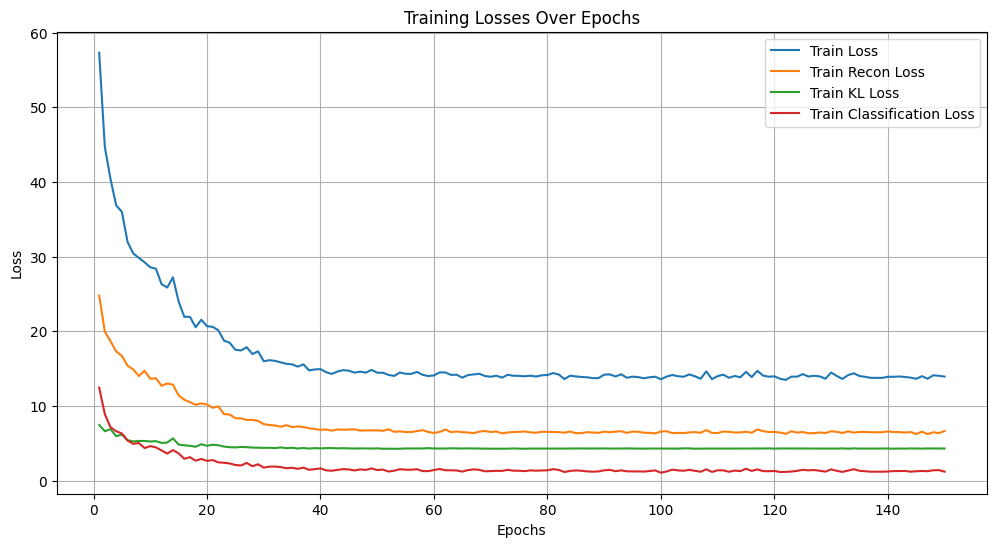

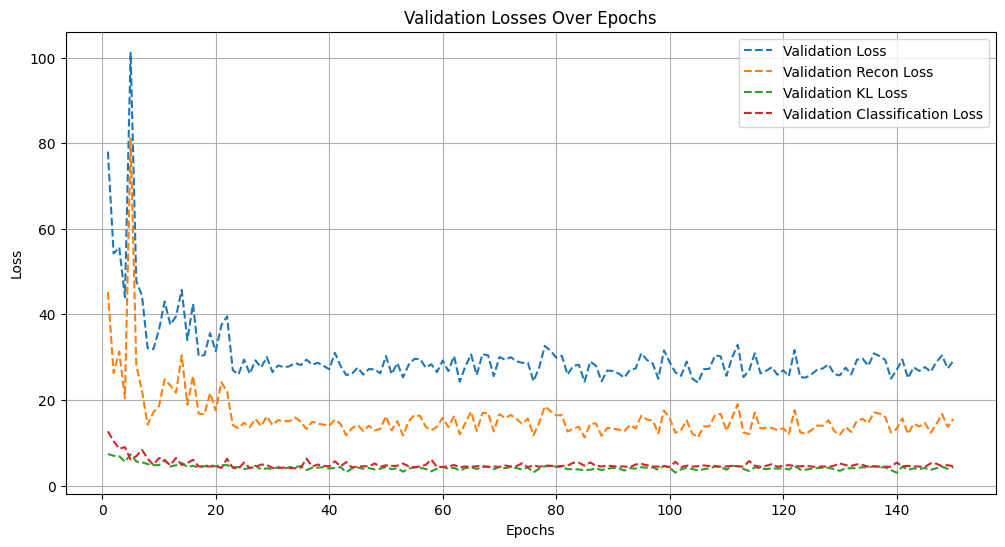

In [ ]:
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

# Initialize lists to store loss values
epochs_list = []
train_losses, val_losses = [], []
train_recon_losses, val_recon_losses = [], []
train_kl_losses, val_kl_losses = [], []
train_class_losses, val_class_losses = [], []

# Train the model
for epoch in range(1, num_epochs + 1):
    # avg_loss, avg_recon, avg_kl, avg_class, accuracy
    train_loss, train_recon_loss, train_kl_loss, train_class_loss, train_accuracy = train_supervised(
        best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, val_recon_loss, val_kl_loss, val_class_loss, val_accuracy = validate_supervised(
        best_model, optimizer, scheduler, epoch, beta, gamma, best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    # Store values for visualization
    epochs_list.append(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_recon_losses.append(train_recon_loss)
    val_recon_losses.append(val_recon_loss)
    train_kl_losses.append(train_kl_loss)
    val_kl_losses.append(val_kl_loss)
    train_class_losses.append(train_class_loss)
    val_class_losses.append(val_class_loss)
    
    # Early stopping
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Plot training losses
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, train_losses, label='Train Loss', linestyle='-')
plt.plot(epochs_list, train_recon_losses, label='Train Recon Loss', linestyle='-')
plt.plot(epochs_list, train_kl_losses, label='Train KL Loss', linestyle='-')
plt.plot(epochs_list, train_class_losses, label='Train Classification Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.grid()
plt.show()



# Plot validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs_list, val_losses, label='Validation Loss', linestyle='--')
plt.plot(epochs_list, val_recon_losses, label='Validation Recon Loss', linestyle='--')
plt.plot(epochs_list, val_kl_losses, label='Validation KL Loss', linestyle='--')
plt.plot(epochs_list, val_class_losses, label='Validation Classification Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses Over Epochs')
plt.legend()
plt.grid()
plt.show()



In [25]:
best_params['gamma']

1.9210647260496314

In [26]:
result = evaluate_classifier_full(best_model, val_loader, device)

result[2]

array([[ 143,    7],
       [  10, 1573]])

In [30]:
def cross_val_performance(data, labels, best_params, num_epochs=50, n_folds=5, batch_size=64):
    """
    Given data (numpy array) and labels (pandas Series), train the model using n-fold CV
    and return the average validation accuracy.
    """
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    
    # Loop over each fold
    for fold, (train_idx, val_idx) in enumerate(skf.split(data, labels)):
        # Split the data
        train_data = data[train_idx]
        val_data = data[val_idx]
        train_labels = labels.iloc[train_idx]
        val_labels = labels.iloc[val_idx]
        
        # Convert to tensors and create DataLoaders
        train_tensor = torch.tensor(train_data, dtype=torch.float32)
        val_tensor = torch.tensor(val_data, dtype=torch.float32)
        train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
        val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)
        
        train_dataset = TensorDataset(train_tensor, train_labels_tensor)
        val_dataset = TensorDataset(val_tensor, val_labels_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Update the input dimension based on the current data shape
        input_dim = train_data.shape[1]
        
        # Initialize the model using the best hyperparameters
        model = SupervisedVAE(
            input_dim=input_dim,
            hidden_dim=best_params["hidden_dim"],
            latent_dim=best_params["latent_dim"],
            dropout_rate=best_params["dropout_rate"],
            activation=get_activation_function(best_params["activation"])
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"])
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=best_params["scheduler_patience"])
        
        # Train the model for a set number of epochs
        for epoch in range(1, num_epochs + 1):
            model.train()
            for batch_data, batch_labels in train_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar, class_logits = model(batch_data)
                loss, _, _, _ = loss_function(
                    recon_batch, batch_data, mu, logvar, class_logits, batch_labels,
                    best_params["beta"], best_params["gamma"],
                    best_params["class_weight"], best_params["classification_multiplier"]
                )
                loss.backward()
                optimizer.step()
            # Optionally update scheduler on the validation loss at each epoch
            model.eval()
            val_loss = 0
            total_correct = 0
            total_samples = 0
            with torch.no_grad():
                for batch_data, batch_labels in val_loader:
                    batch_data = batch_data.to(device)
                    batch_labels = batch_labels.to(device)
                    recon_batch, mu, logvar, class_logits = model(batch_data)
                    loss, _, _, _ = loss_function(
                        recon_batch, batch_data, mu, logvar, class_logits, batch_labels,
                        best_params["beta"], best_params["gamma"],
                        best_params["class_weight"], best_params["classification_multiplier"]
                    )
                    val_loss += loss.item()
                    # Get predictions and count correct predictions
                    preds = (class_logits > 0.5).float().squeeze()
                    total_correct += (preds == batch_labels).sum().item()
                    total_samples += batch_labels.size(0)
            # Use the validation loss to step the scheduler (optional)
            scheduler.step(val_loss)
            # For simplicity, we take the last epoch’s accuracy as the fold's accuracy
            fold_accuracy = total_correct / total_samples
        fold_accuracies.append(fold_accuracy)
    return np.mean(fold_accuracies)


def feature_ablation_analysis(features, frb_data_clean, labels, best_params, num_epochs=50, n_folds=5, batch_size=64):
    """
    For each feature in the list, remove it from the dataset, retrain the model using cross-validation,
    and record the change in validation accuracy.
    """
    ablation_results = {}
    
    # Baseline: performance using all features
    baseline_df = frb_data_clean[features].fillna(0)
    scaler = StandardScaler()
    full_data_scaled = scaler.fit_transform(baseline_df)
    baseline_acc = cross_val_performance(full_data_scaled, labels, best_params, num_epochs, n_folds, batch_size)
    print("Baseline accuracy with all features: {:.4f}".format(baseline_acc))
    
    # Loop over each feature and remove it
    for feature in features:
        reduced_features = [f for f in features if f != feature]
        print(f"\nEvaluating without feature: {feature}")
        df_reduced = frb_data_clean[reduced_features].fillna(0)
        scaler = StandardScaler()
        reduced_data_scaled = scaler.fit_transform(df_reduced)
        
        acc = cross_val_performance(reduced_data_scaled, labels, best_params, num_epochs, n_folds, batch_size)
        drop = baseline_acc - acc
        ablation_results[feature] = {"accuracy": acc, "drop_in_accuracy": drop}
        print(f"Accuracy without {feature}: {acc:.4f} (drop: {drop:.4f})")
    
    return baseline_acc, ablation_results


baseline_acc, ablation_results = feature_ablation_analysis(features, frb_data_clean, labels, best_params, num_epochs=50, n_folds=5, batch_size=64)

print("\n=== Feature Ablation Results ===")
for feature, result in ablation_results.items():
    print(f"{feature}: Accuracy = {result['accuracy']:.4f}, Drop = {result['drop_in_accuracy']:.4f}")


baseline_acc, ablation_results = feature_ablation_analysis(features, frb_data_clean, labels, best_params, num_epochs=50, n_folds=5, batch_size=64)

print("\n=== Feature Ablation Results ===")
for feature, result in ablation_results.items():
    print(f"{feature}: Accuracy = {result['accuracy']:.4f}, Drop = {result['drop_in_accuracy']:.4f}")

Baseline accuracy with all features: 0.9878

Evaluating without feature: Observing_band
Accuracy without Observing_band: 0.9825 (drop: 0.0053)

Evaluating without feature: SNR
Accuracy without SNR: 0.9830 (drop: 0.0047)

Evaluating without feature: Freq_high
Accuracy without Freq_high: 0.9855 (drop: 0.0023)

Evaluating without feature: Freq_low
Accuracy without Freq_low: 0.9850 (drop: 0.0028)

Evaluating without feature: Freq_peak
Accuracy without Freq_peak: 0.9807 (drop: 0.0070)

Evaluating without feature: Width
Accuracy without Width: 0.9793 (drop: 0.0084)

Evaluating without feature: DM_SNR
Accuracy without DM_SNR: 0.9840 (drop: 0.0038)

Evaluating without feature: DM_alig
Accuracy without DM_alig: 0.9886 (drop: -0.0008)

Evaluating without feature: Flux_density
Accuracy without Flux_density: 0.9878 (drop: 0.0000)

Evaluating without feature: Fluence
Accuracy without Fluence: 0.9860 (drop: 0.0017)

Evaluating without feature: Energy
Accuracy without Energy: 0.9870 (drop: 0.0008)

E

In [57]:
# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# Step 2: Filter the dataset to exclude these repeaters
filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
filtered_data_clean = frb_data_clean.loc[filtered_indices]
filtered_labels = labels.loc[filtered_indices]

# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)

def train_supervised_filtered(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader_filtered):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised_filtered(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader_filtered:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False


In [67]:


# Step 7: Train the model with the filtered dataset
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=best_params["scheduler_patience"])

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised_filtered(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, _, _, _, val_accuracy = validate_supervised_filtered(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

# save model
torch.save(best_model.state_dict(), 'model_weights_filtered_repeaters.pth')


=== Final Evaluation ===
Validation Accuracy: 0.8696
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.86      0.96      0.91       150
    Repeater       0.94      0.81      0.87       124

    accuracy                           0.89       274
   macro avg       0.90      0.88      0.89       274
weighted avg       0.90      0.89      0.89       274

Confusion Matrix:
 [[144   6]
 [ 24 100]]


In [68]:
# Step 1: Remove all repeaters from the dataset
non_repeater_indices = frb_data[frb_data['Repeater'] == 0].index
no_repeater_data_clean = frb_data_clean.loc[non_repeater_indices]
no_repeater_labels = labels.loc[non_repeater_indices]

# Step 2: Standardize the no_repeater dataset
scaler = StandardScaler()
no_repeater_data_scaled = scaler.fit_transform(no_repeater_data_clean)

# Step 3: Split the no_repeater dataset into train and validation sets
train_data_no_repeater, val_data_no_repeater, train_labels_no_repeater, val_labels_no_repeater = train_test_split(
    no_repeater_data_scaled, no_repeater_labels, test_size=0.2, random_state=42, stratify=no_repeater_labels
)

# Step 4: Convert to PyTorch tensors
train_tensor_no_repeater = torch.tensor(train_data_no_repeater, dtype=torch.float32)
val_tensor_no_repeater = torch.tensor(val_data_no_repeater, dtype=torch.float32)
train_labels_tensor_no_repeater = torch.tensor(train_labels_no_repeater.values, dtype=torch.long)
val_labels_tensor_no_repeater = torch.tensor(val_labels_no_repeater.values, dtype=torch.long)

# Step 5: Create datasets and dataloaders
batch_size = 64
train_dataset_no_repeater = TensorDataset(train_tensor_no_repeater, train_labels_tensor_no_repeater)
val_dataset_no_repeater = TensorDataset(val_tensor_no_repeater, val_labels_tensor_no_repeater)

train_loader_no_repeater = DataLoader(train_dataset_no_repeater, batch_size=batch_size, shuffle=True)
val_loader_no_repeater = DataLoader(val_dataset_no_repeater, batch_size=batch_size, shuffle=False)

def train_supervised_no_repeater(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader_no_repeater):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = train_loss / len(train_loader_no_repeater.dataset)
    avg_recon = recon_loss_total / len(train_loader_no_repeater.dataset)
    avg_kl = kl_loss_total / len(train_loader_no_repeater.dataset)
    avg_class = classification_loss_total / len(train_loader_no_repeater.dataset)
    accuracy = correct / total
    
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised_no_repeater(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader_no_repeater:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader_no_repeater.dataset)
    avg_recon = recon_loss_total / len(val_loader_no_repeater.dataset)
    avg_kl = kl_loss_total / len(val_loader_no_repeater.dataset)
    avg_class = classification_loss_total / len(val_loader_no_repeater.dataset)
    accuracy = correct / total
    
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False

# Step 7: Train the model with the no_repeater dataset
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=best_params["scheduler_patience"])

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised_no_repeater(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, _, _, _, val_accuracy = validate_supervised_no_repeater(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break
    
def evaluate_classifier_full_oneclass(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    # f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    # class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return conf_matrix, all_preds, all_labels

# Evaluate the model after training

conf_mat_no_repeaters, _, _ = evaluate_classifier_full_oneclass(best_model, val_loader_no_repeater, device)

conf_mat_no_repeaters

# save model weights

torch.save(best_model.state_dict(), 'best_model_no_repeaters.pth')

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.




=== Final Evaluation ===
Validation Accuracy: 0.8897
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.92      0.89      0.90       150
    Repeater       0.87      0.91      0.89       129

    accuracy                           0.90       279
   macro avg       0.90      0.90      0.90       279
weighted avg       0.90      0.90      0.90       279

Confusion Matrix:
 [[133  17]
 [ 12 117]]

=== PCA Visualization ===


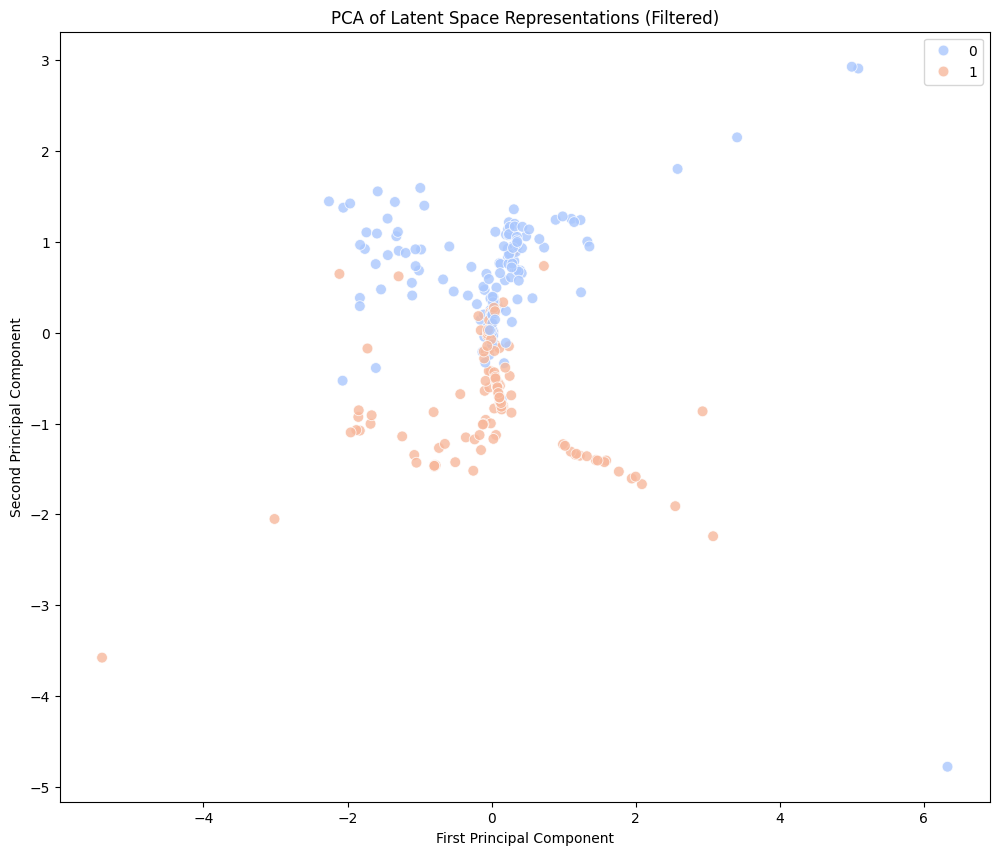


=== Clustering Analysis in Latent Space ===


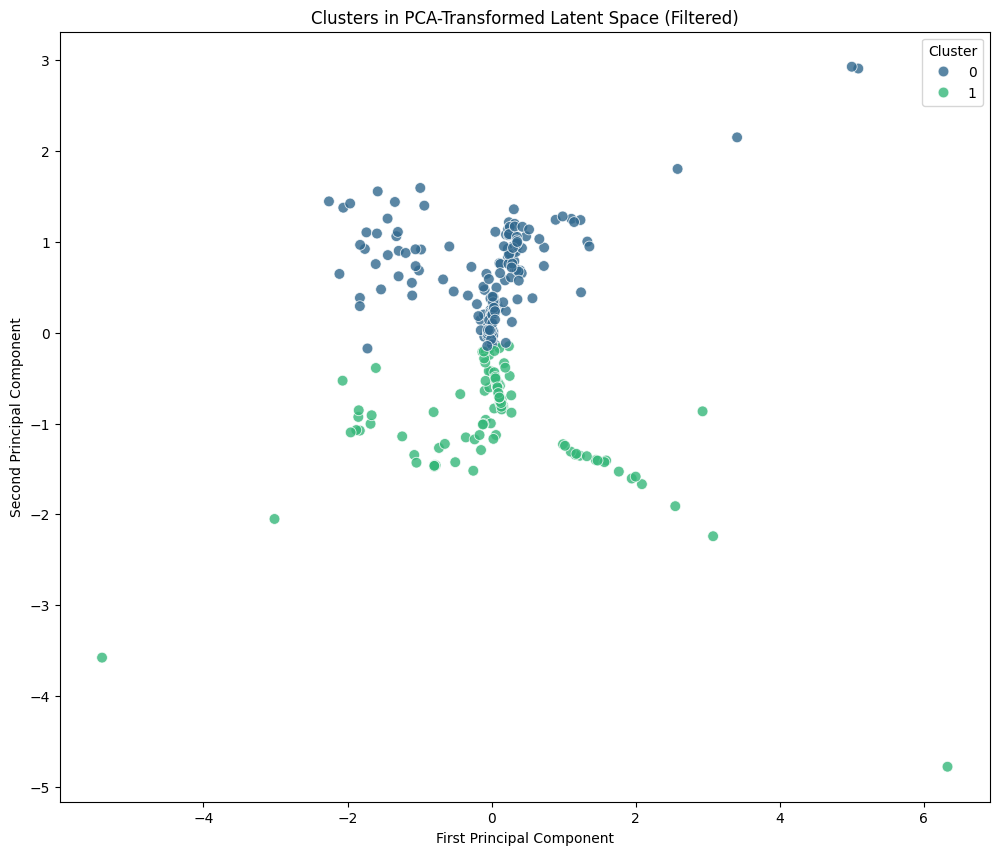

Silhouette Score: 0.38204115629196167
Adjusted Rand Index (ARI): 0.5923499375903463

=== t-SNE Visualization ===


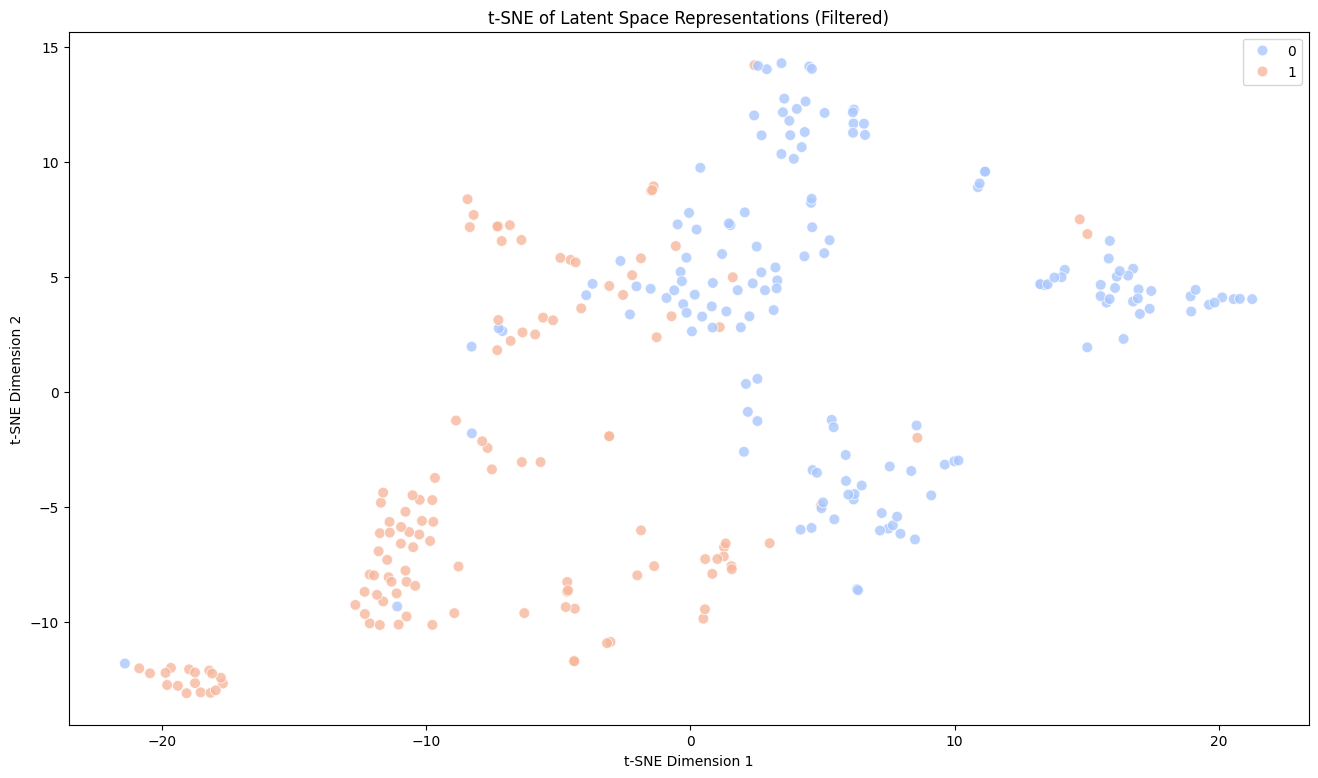


=== UMAP Visualization ===


/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



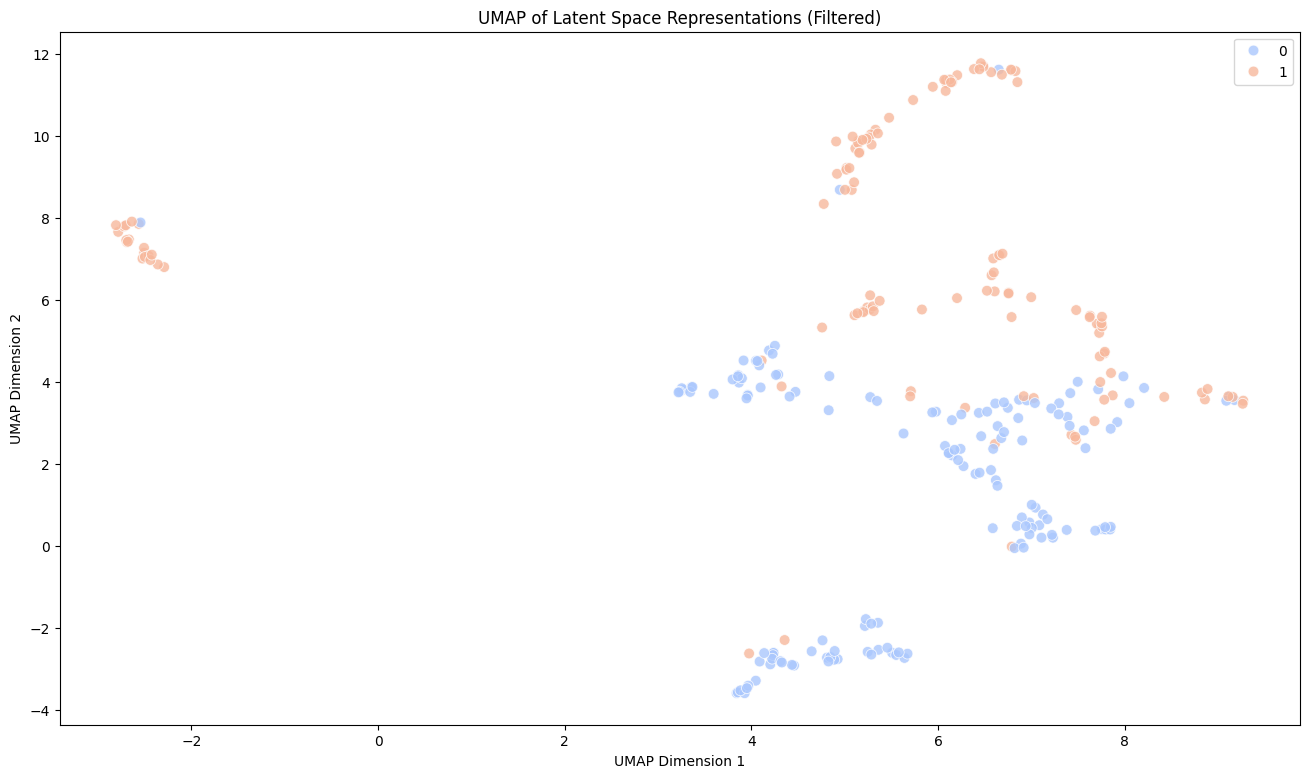


=== Isomap Visualization ===


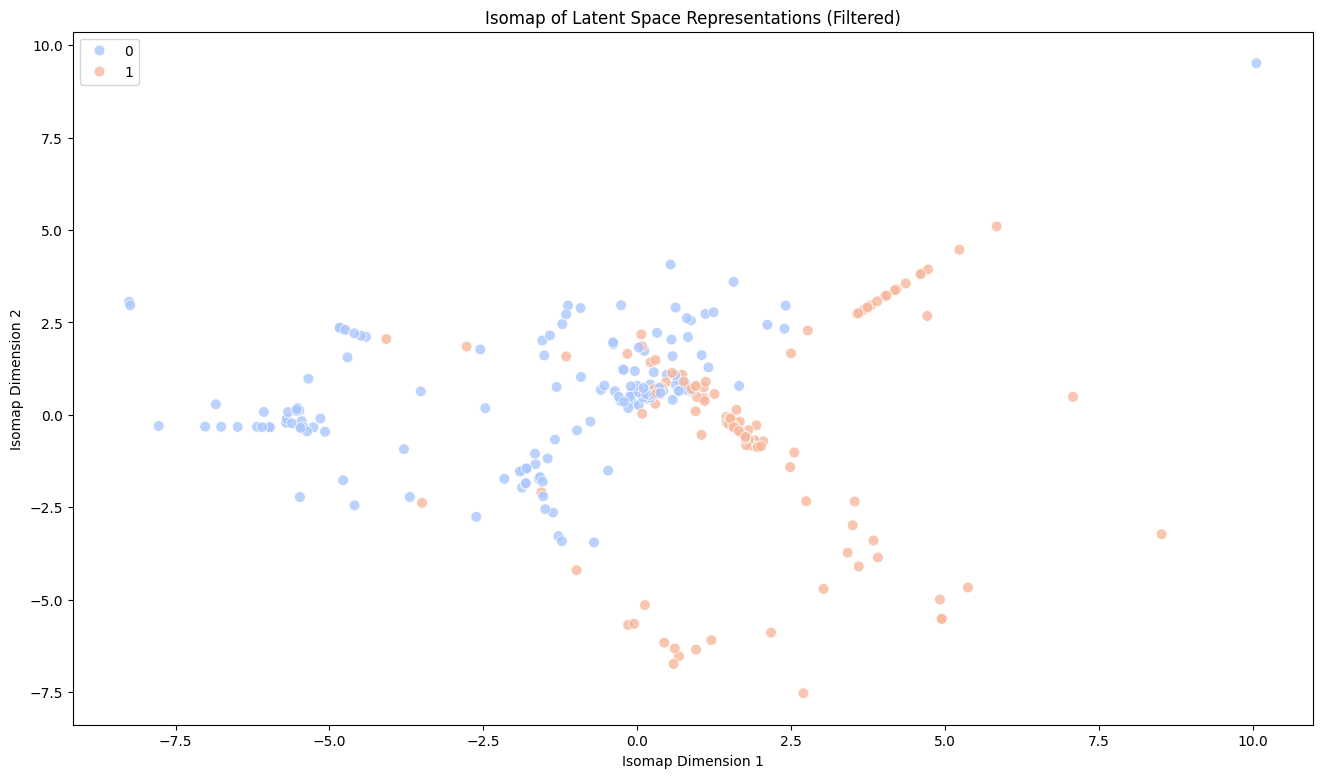

In [50]:
#import DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# # Step 2: Filter the dataset to exclude these repeaters
# filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
# filtered_data_clean = frb_data_clean.loc[filtered_indices]
# filtered_labels = labels.loc[filtered_indices]

top_5_repeaters = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts().head(5).index.tolist()

# Sample 10 signals from each top repeater
sampled_indices = []
for repeater in top_5_repeaters:
    repeater_indices = frb_data[frb_data['Source'] == repeater].index
    sampled = np.random.choice(repeater_indices, size=min(5, len(repeater_indices)), replace=False)
    sampled_indices.extend(sampled)

# Get all other indices excluding the top 5 repeaters
non_top5_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index

# Combine the sampled top5 and the rest
final_indices = np.concatenate([non_top5_indices, sampled_indices])

# Filter the clean data and labels accordingly
filtered_data_clean = frb_data_clean.loc[final_indices]
filtered_labels = labels.loc[final_indices]


# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)

def train_supervised_filtered(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader_filtered):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised_filtered(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader_filtered:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



# Step 7: Train the model with the filtered dataset
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=best_params["scheduler_patience"])

num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train_loss, _, _, _, train_accuracy = train_supervised_filtered(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    
    val_loss, _, _, _, val_accuracy = validate_supervised_filtered(
        best_model, optimizer, scheduler, epoch, best_params["beta"], 
        best_params["gamma"], best_params["class_weight"], best_params["classification_multiplier"]
    )
    scheduler.step(val_loss)
    
    if early_stopping([val_loss], stop_patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(best_model, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(best_model, train_loader_filtered, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader_filtered, device)

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent, val_labels_np, best_model, device, title='PCA of Latent Space Representations (Filtered)')

# Step 3: Perform clustering analysis
print("\n=== Clustering Analysis in Latent Space ===")
cluster_and_visualize(val_latent, val_labels_np, title='Clusters in PCA-Transformed Latent Space (Filtered)')

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent, val_labels_np, title='t-SNE of Latent Space Representations (Filtered)', palette='coolwarm')

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent, val_labels_np, title='UMAP of Latent Space Representations (Filtered)', palette='coolwarm')

# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent, val_labels_np, title='Isomap of Latent Space Representations (Filtered)')

In [52]:
# save model as filtered_model_sampled.pth

torch.save(best_model.state_dict(), 'filtered_model_sampled.pth')